In [1]:
import datetime
print(datetime.datetime.now())

2019-08-15 20:37:16.801822


In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import cohen_kappa_score, make_scorer

import matplotlib.pyplot as plt
import os
import datetime
import numpy as np
import seaborn as sns
os.getcwd()
os.chdir('C:/Users/Mann-A2/Documents/Python Repository/Question 8 - OJ Modeling')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.2.


### Reading Data

In [4]:
oj = pd.read_excel("OJ.xlsx")


#### Exploring Dataset columns

In [5]:
oj.columns
oj.head()

Index(['WeekofPurchase', 'StoreID', 'STORE', 'Store7', 'PriceCH', 'PriceMM',
       'ListPriceDiff', 'DiscCH', 'DiscMM', 'PctDiscCH', 'PctDiscMM',
       'SalePriceCH', 'SalePriceMM', 'PriceDiff', 'SpecialCH', 'SpecialMM',
       'LoyalCH', 'Purchase'],
      dtype='object')

WeekofPurchase  StoreID  STORE Store7  PriceCH  PriceMM  ListPriceDiff  \
0             237        1      1     No     1.75     1.99           0.24   
1             239        1      1     No     1.75     1.99           0.24   
2             245        1      1     No     1.86     2.09           0.23   
3             227        1      1     No     1.69     1.69           0.00   
4             228        7      0    Yes     1.69     1.69           0.00   

   DiscCH  DiscMM  PctDiscCH  PctDiscMM  SalePriceCH  SalePriceMM  PriceDiff  \
0    0.00     0.0   0.000000   0.000000         1.75         1.99       0.24   
1    0.00     0.3   0.000000   0.150754         1.75         1.69      -0.06   
2    0.17     0.0   0.091398   0.000000         1.69         2.09       0.40   
3    0.00     0.0   0.000000   0.000000         1.69         1.69       0.00   
4    0.00     0.0   0.000000   0.000000         1.69         1.69       0.00   

   SpecialCH  SpecialMM   LoyalCH Purchase  
0          0          0  0.500000       CH  
1          0          1  0.600000       CH  
2          0          0  0.680000       CH  
3          0          0  0.400000       MM  
4          0          0  0.956535       CH

#### Checking for missing values

In [6]:
oj.isnull().sum()
oj.isnull().sum().sum()

WeekofPurchase    0
StoreID           0
STORE             0
Store7            0
PriceCH           0
PriceMM           0
ListPriceDiff     0
DiscCH            0
DiscMM            0
PctDiscCH         0
PctDiscMM         0
SalePriceCH       0
SalePriceMM       0
PriceDiff         0
SpecialCH         0
SpecialMM         0
LoyalCH           0
Purchase          0
dtype: int64

0

## Visualizations - Distribution chart of all features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000143680532B0>,
      dtype=object)

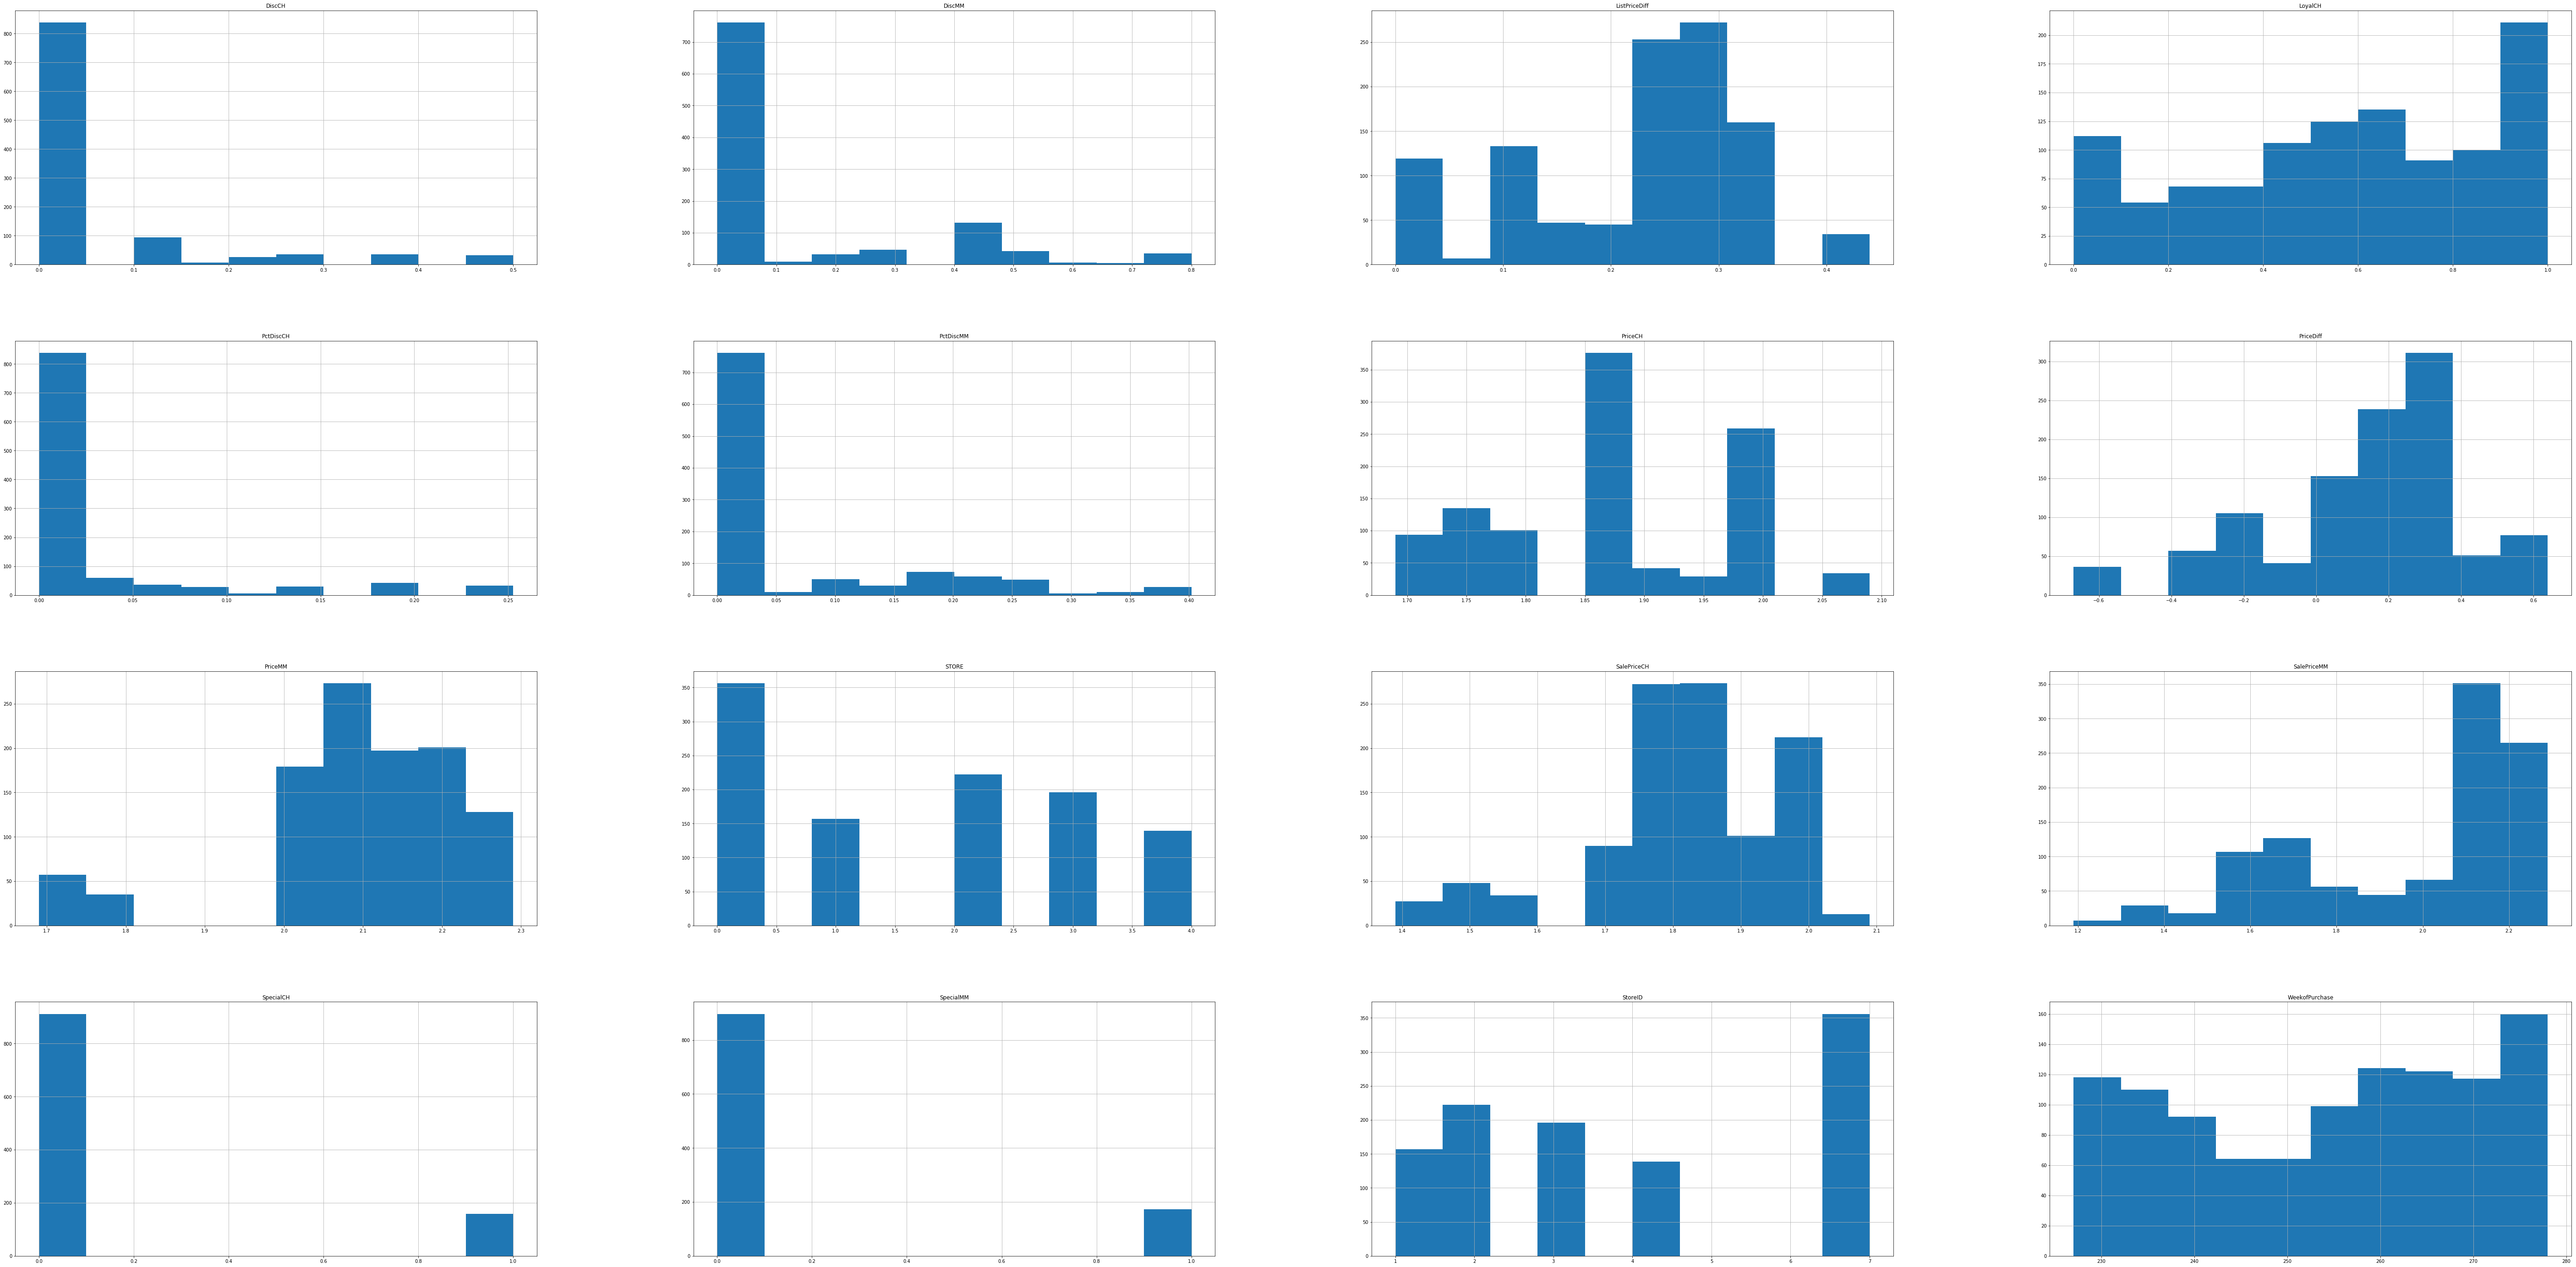

In [7]:
oj.hist(figsize=(100,50))
plt.show()

### Finding correlations between features

In [8]:
corr = oj.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

#### It can be seen that PriceDiff and SalePriceMM are positively correlated. Also, SalePriceMM and DiscMM are negatively correlated. Other Negatively correlated pairs are PriceDiff and DiscMM, PriceDiff and PctDiscMM, SalePriceMM and PctDiscMM.

## Feature Engineering - Data Preprocessing

In [9]:
#Removing 'Store' ans 'Store7' feature as it contains same feature as 'StoreID'. Also, creating dummy features for StoreIDs.

oj = oj.drop('Store7', axis=1)
oj = oj.drop('STORE', axis=1)

#Creating Dummy variables and dropping categorical columns
oj['StoreID'] = oj['StoreID'].astype(str)
dummy_columns = ['StoreID']    
oj_dummies = pd.get_dummies(oj[dummy_columns])
oj = oj.join(oj_dummies)

oj = oj.drop(dummy_columns, axis=1)

#Recoding 'WeekofPurchase', i.e., 227th week is the 1st week, and so on
oj['WeekofPurchase'] = oj['WeekofPurchase'] - 226
#rearranging the columns
df1 = oj.pop('Purchase')
oj['Purchase'] = df1 

oj.to_excel (r'OJ_Dummy_v2.1.xlsx', index = None, header=True)

oj.head()

WeekofPurchase  PriceCH  PriceMM  ListPriceDiff  DiscCH  DiscMM  PctDiscCH  \
0              11     1.75     1.99           0.24    0.00     0.0   0.000000   
1              13     1.75     1.99           0.24    0.00     0.3   0.000000   
2              19     1.86     2.09           0.23    0.17     0.0   0.091398   
3               1     1.69     1.69           0.00    0.00     0.0   0.000000   
4               2     1.69     1.69           0.00    0.00     0.0   0.000000   

   PctDiscMM  SalePriceCH  SalePriceMM  PriceDiff  SpecialCH  SpecialMM  \
0   0.000000         1.75         1.99       0.24          0          0   
1   0.150754         1.75         1.69      -0.06          0          1   
2   0.000000         1.69         2.09       0.40          0          0   
3   0.000000         1.69         1.69       0.00          0          0   
4   0.000000         1.69         1.69       0.00          0          0   

    LoyalCH  StoreID_1  StoreID_2  StoreID_3  StoreID_4  StoreID_7 Purchase  
0  0.500000          1          0          0          0          0       CH  
1  0.600000          1          0          0          0          0       CH  
2  0.680000          1          0          0          0          0       CH  
3  0.400000          1          0          0          0          0       MM  
4  0.956535          0          0          0          0          1       CH

## Creating discount Features : 'Discount_CH_Given' and 'Discount_MM_Given' when discount is given for CH and MM

In [10]:
# oj['Discount_CH_Given'] = np.where(oj['DiscCH'] == 0, 0, 1)
# oj['Discount_MM_Given'] = np.where(oj['DiscMM'] == 0, 0, 1)

# #rearranging the columns
# df1 = oj.pop('Purchase')
# oj['Purchase'] = df1

# oj.to_excel (r'OJ_Dummy_FE_v2.2.xlsx', index = None, header=True)

# oj.head()

#### Note : Creating this feature resulted in reduced performance, hence dropped this part of Feature Engineering.

## Feature Scaling

In [11]:
#=================Feature Scaling ========================
# Scaling the data (Standardization - Z Score normalization)
# scaler = StandardScaler()
# features = ['WeekofPurchase', 'PriceCH', 'PriceMM', 'ListPriceDiff', 'DiscCH', 'DiscMM', 'PctDiscCH', 'PctDiscMM', 'SalePriceCH', 'SalePriceMM', 'PriceDiff', 'LoyalCH']
# oj[features] = scaler.fit_transform(oj[features])

# #rearranging the columns
# df1 = oj.pop('Purchase')
# oj['Purchase'] = df1

# oj.to_excel (r'OJ_Scaled_v2.3.xlsx', index = None, header=True)

# oj.head()

#### Note : FeatureScaling resulted in reduced performance of models, hence did not perform feature scaling on data.

## Model Building

In [5]:
# Reading Feature Engineered data
oj = pd.read_excel("OJ_Dummy_v2.1.xlsx")
oj

WeekofPurchase  PriceCH  PriceMM  ListPriceDiff  DiscCH  DiscMM  \
0                 11     1.75     1.99           0.24    0.00    0.00   
1                 13     1.75     1.99           0.24    0.00    0.30   
2                 19     1.86     2.09           0.23    0.17    0.00   
3                  1     1.69     1.69           0.00    0.00    0.00   
4                  2     1.69     1.69           0.00    0.00    0.00   
5                  4     1.69     1.99           0.30    0.00    0.00   
6                  6     1.69     1.99           0.30    0.00    0.40   
7                  8     1.75     1.99           0.24    0.00    0.40   
8                  9     1.75     1.99           0.24    0.00    0.40   
9                 12     1.75     1.99           0.24    0.00    0.40   
10                14     1.86     2.09           0.23    0.00    0.00   
11                37     1.86     2.13           0.27    0.27    0.00   
12                50     1.99     2.13           0.14    0.00    0.54   
13                42     1.86     2.13           0.27    0.00    0.00   
14                52     2.06     2.13           0.07    0.00    0.00   
15                52     2.06     2.13           0.07    0.00    0.00   
16                14     1.75     1.99           0.24    0.00    0.30   
17                42     1.86     2.18           0.32    0.00    0.00   
18                43     1.86     2.18           0.32    0.00    0.00   
19                28     1.86     2.18           0.32    0.00    0.00   
20                31     1.86     2.18           0.32    0.00    0.00   
21                32     1.76     2.18           0.42    0.00    0.00   
22                33     1.86     2.18           0.32    0.00    0.00   
23                38     1.86     2.13           0.27    0.37    0.00   
24                42     1.86     2.13           0.27    0.00    0.00   
25                43     1.86     2.13           0.27    0.27    0.00   
26                45     1.86     2.13           0.27    0.00    0.00   
27                46     1.86     2.13           0.27    0.00    0.00   
28                48     1.86     2.13           0.27    0.47    0.54   
29                52     2.06     2.13           0.07    0.00    0.00   
...              ...      ...      ...            ...     ...     ...   
1040              12     1.75     1.99           0.24    0.00    0.00   
1041              12     1.75     1.99           0.24    0.00    0.00   
1042              13     1.75     1.99           0.24    0.00    0.30   
1043              14     1.75     1.99           0.24    0.00    0.30   
1044              15     1.86     1.99           0.13    0.00    0.30   
1045              26     1.76     2.09           0.33    0.00    0.00   
1046              27     1.76     2.09           0.33    0.00    0.00   
1047              29     1.76     2.18           0.42    0.00    0.00   
1048              30     1.76     2.18           0.42    0.00    0.00   
1049               2     1.69     1.69           0.00    0.00    0.00   
1050               4     1.69     1.99           0.30    0.00    0.00   
1051               5     1.69     1.99           0.30    0.00    0.00   
1052              11     1.75     1.99           0.24    0.00    0.40   
1053              12     1.75     1.99           0.24    0.00    0.40   
1054              17     1.86     2.09           0.23    0.00    0.00   
1055               1     1.69     1.69           0.00    0.00    0.00   
1056               2     1.69     1.69           0.00    0.00    0.00   
1057               6     1.69     1.99           0.30    0.00    0.00   
1058               7     1.75     1.99           0.24    0.00    0.40   
1059               9     1.69     1.99           0.30    0.00    0.00   
1060              10     1.75     1.99           0.24    0.00    0.00   
1061              16     1.86     1.99           0.13    0.00    0.30   
1062              19     1.86     2.09           0.23    0.00   

In [6]:
# Splitting dataset into training set and test set
from sklearn.model_selection import train_test_split

X=oj.iloc[:,:19] #Selecting all X features
y=oj['Purchase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=123)

X_train.shape
y_train.shape

(856, 19)

(856,)

##### Since the data contains 61% instances for Purchase "CH" and 39% instances of Purchase "MM", performing SMOTE to Balance the dataset.

In [7]:
# Performing SMOTE on train dataset
from imblearn.over_sampling import SMOTE

X_train,y_train = SMOTE().fit_resample(X_train,y_train)
X_train.shape
y_train.shape

(1044, 19)

(1044,)

##### Function for Confusion Matrix

In [13]:
#PLotting confusion matrix

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["CH","MM"], rotation=45)
    plt.yticks(tick_marks, ["CH","MM"])

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual Purchase')
    plt.xlabel('Predicted Purchase')

##### Feature Importances function

In [12]:
def feature_importances(ft):
    """
    This function prints feature importances for different models.
    """
    feature_importances = pd.DataFrame(ft.feature_importances_,
                                   index = X.columns,
                                   columns=['importance']).sort_values('importance',
                                           ascending=False)
    return feature_importances

##### The performance metrics used were Cohen's kappa Score, Matthews Correlation Coefficient (MCC),Precision, Recall, F1 Score and Confusion Matrix.

### 1. Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=123,solver = 'liblinear')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

###### Model Parameters - 1. Logistic Regression

In [21]:
clf.coef_
clf.intercept_
feature_names = X.columns
class_names = [str(x) for x in clf.classes_]

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[-0.0063319 ,  0.80133415, -0.07531892, -0.87665307, -0.42694275,
         0.35035825, -0.2763944 ,  0.06462328,  1.2282769 , -0.42567717,
        -1.65395407,  0.41189228,  0.35847812, -5.52376805,  0.26021135,
         0.33003197,  0.37661015, -0.26117113, -0.26127977]])

array([0.44440255])

array([[112,  19],
       [ 14,  69]], dtype=int64)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CH       0.89      0.85      0.87       131
          MM       0.78      0.83      0.81        83

    accuracy                           0.85       214
   macro avg       0.84      0.84      0.84       214
weighted avg       0.85      0.85      0.85       214



#### Performance Measures - 1. Logistic Regression

confusion matrix:
 [[112  19]
 [ 14  69]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


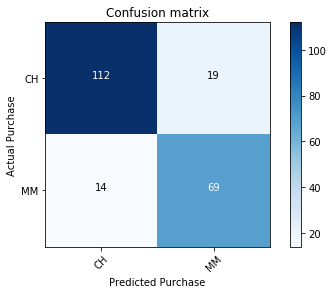

In [23]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [24]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.85 0.83]

Precision for both classes [0.89 0.78]

Recall Score: 0.843143566632944

Precision Score: 0.836489898989899

F1-Score: 0.8393064372994743

Accuracy = 0.85

Kappa = 0.68

Matthews correlation coefficient = 0.68


### 2. Decision Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=123)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [14]:
print(clf.tree_.node_count)
feature_importances(clf)

417


importance
LoyalCH           0.623997
PriceDiff         0.104570
WeekofPurchase    0.100883
ListPriceDiff     0.049693
StoreID_4         0.018407
PriceCH           0.017954
SpecialCH         0.010871
StoreID_2         0.010005
StoreID_7         0.009749
SalePriceMM       0.009541
StoreID_3         0.007754
PriceMM           0.007312
StoreID_1         0.006908
PctDiscMM         0.004977
PctDiscCH         0.004548
SalePriceCH       0.003920
DiscMM            0.003517
SpecialMM         0.003444
DiscCH            0.001949

###### Model Parameters - 1. Decision Tree

confusion matrix:
 [[109  22]
 [ 20  63]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


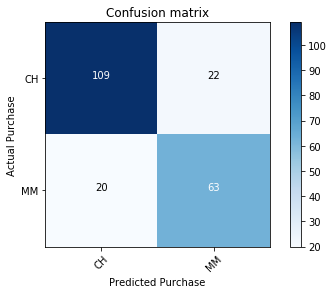

In [15]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [16]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.83 0.76]

Precision for both classes [0.84 0.74]

Recall Score: 0.7955486066403017

Precision Score: 0.7930688554491564

F1-Score: 0.7942307692307691

Accuracy = 0.80

Kappa = 0.59

Matthews correlation coefficient = 0.59


#### Model Tuning - 2. Decision Tree

In [15]:
from sklearn.model_selection import GridSearchCV


parameters = {'criterion':('gini', 'entropy'), 
              'max_depth':[2, 4, 6, 8, 10], 
              'max_leaf_nodes':[5, 10, 50,100], 
              'min_impurity_decrease':[0, 0.1, 0.2], 
              'random_state':[123]}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='entropy', max_depth=3,
                                              max_features=None,
                                              max_leaf_nodes=5,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=10,
                                              min_samples_split=10,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid=False, n_jobs=None,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [2, 4, 6, 8, 10],
                        

In [43]:
clf.best_params_
clf.best_score_
clf.best_estimator_

{'criterion': 'gini',
 'max_depth': 4,
 'max_leaf_nodes': 5,
 'min_impurity_decrease': 0,
 'random_state': 123}

0.6551831501831502

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

#### Tuned Model Parameters - 2. Decision Tree

confusion matrix:
 [[110  21]
 [ 16  67]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


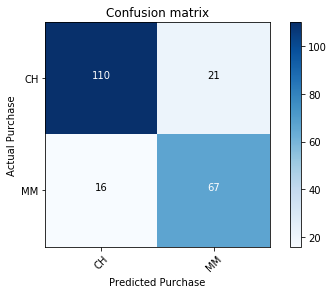

In [44]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [45]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.84 0.81]

Precision for both classes [0.87 0.76]

Recall Score: 0.8234617860756002

Precision Score: 0.8171897546897546

F1-Score: 0.8198284296994106

Accuracy = 0.83

Kappa = 0.64

Matthews correlation coefficient = 0.64


#### Visualization - 2. Decision Tree

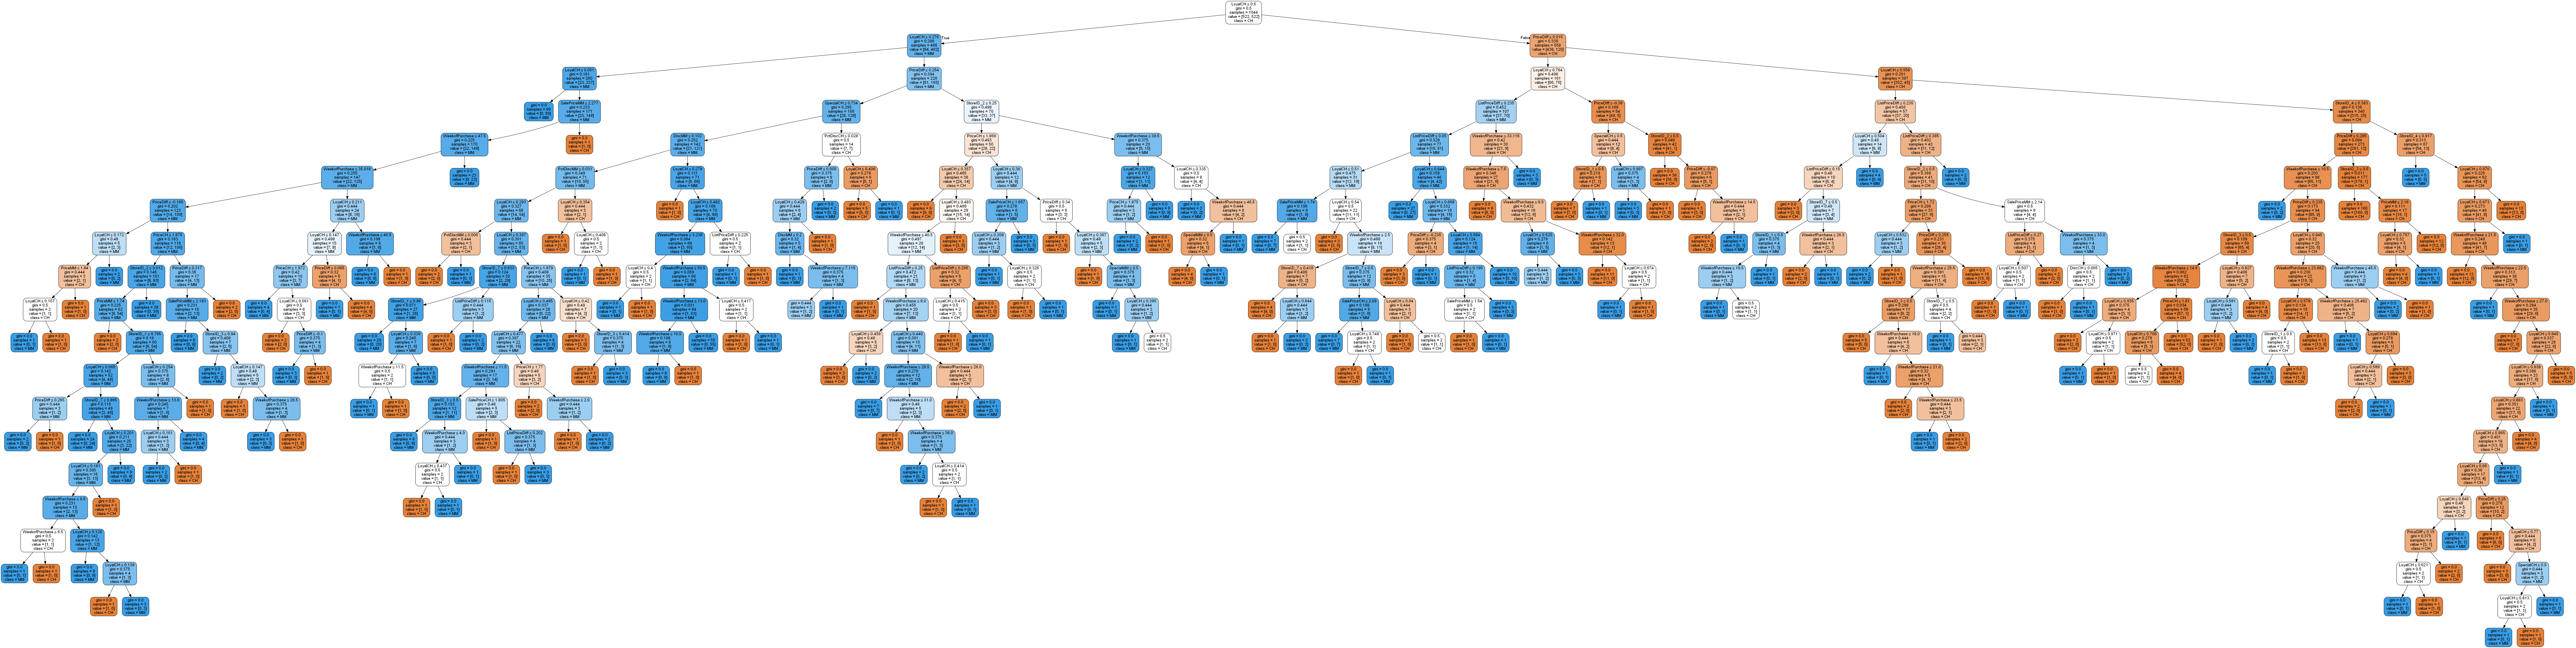

In [26]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,
                feature_names=list(X.columns),
                class_names = clf.classes_)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())



### 3. Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_jobs=3, random_state=123,n_estimators=100)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [52]:
feature_importances(clf)

importance
LoyalCH           0.517942
WeekofPurchase    0.109645
PriceDiff         0.055310
ListPriceDiff     0.044045
SalePriceMM       0.039378
StoreID_3         0.033256
StoreID_4         0.023607
StoreID_7         0.021767
SalePriceCH       0.020635
PriceCH           0.020327
PriceMM           0.018654
PctDiscMM         0.016344
DiscMM            0.014481
SpecialMM         0.013333
StoreID_1         0.011052
SpecialCH         0.010479
PctDiscCH         0.010440
StoreID_2         0.010102
DiscCH            0.009202

###### Model Parameters - 3. Random Forest

confusion matrix:
 [[114  17]
 [ 22  61]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


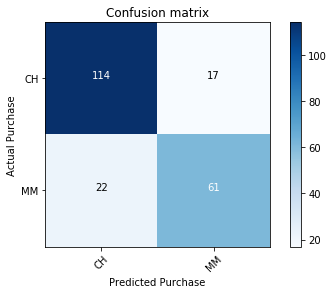

In [53]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [54]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.87 0.73]

Precision for both classes [0.84 0.78]

Recall Score: 0.8025843833348663

Precision Score: 0.8101432880844646

F1-Score: 0.8058482797124712

Accuracy = 0.82

Kappa = 0.61

Matthews correlation coefficient = 0.61


#### Model Tuning - 3. Random Forest

In [55]:
from sklearn.model_selection import GridSearchCV


parameters = {'criterion':('gini', 'entropy'), 
              'max_depth':[2, 4, 6, 8, 10], 
              'max_leaf_nodes':[None, 5, 10, 50,100], 
              'min_impurity_decrease':[0, 0.1, 0.2],
             'random_state':[123]}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=3,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'criter

In [56]:
clf.best_params_
clf.best_score_
clf.best_estimator_

{'criterion': 'gini',
 'max_depth': 10,
 'max_leaf_nodes': 100,
 'min_impurity_decrease': 0,
 'random_state': 123}

0.6707142857142857

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=100,
                       min_impurity_decrease=0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

#### Tuned Model Parameters - 3. Random Forest

confusion matrix:
 [[115  16]
 [ 21  62]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


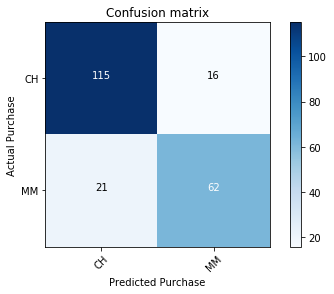

In [57]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [58]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))




Recall for both classes [0.88 0.75]

Precision for both classes [0.85 0.79]

Recall Score: 0.8124252736135381

Precision Score: 0.8202300150829562

F1-Score: 0.8158047781887547

Accuracy = 0.83

Kappa = 0.63

Matthews correlation coefficient = 0.63


### 4. Naive Bayes

In [69]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB(var_smoothing=1e-09)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


###### Model Parameters - 4. Naive Bayes

confusion matrix:
 [[94 37]
 [14 69]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


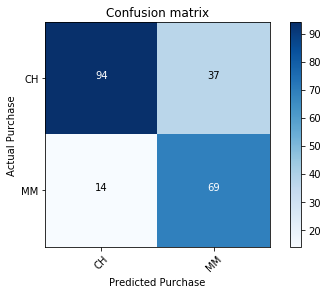

In [70]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [71]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.72 0.83]

Precision for both classes [0.87 0.65]

Recall Score: 0.7744412765566081

Precision Score: 0.7606568832983926

F1-Score: 0.758384804409909

Accuracy = 0.76

Kappa = 0.52

Matthews correlation coefficient = 0.53


#### Model Tuning - 4. Naive Bayes

In [72]:
from sklearn.model_selection import GridSearchCV

parameters = {'var_smoothing':(1e-09,2e-09,3e-09,4e-09,5e-09,1e-08)}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid=False,
             n_jobs=None,
             param_grid={'var_smoothing': (1e-09, 2e-09, 3e-09, 4e-09, 5e-09,
                                           1e-08)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(cohen_kappa_score), verbose=0)

In [73]:
clf.best_params_
clf.best_score_
clf.best_estimator_

{'var_smoothing': 1e-09}

0.521025641025641

GaussianNB(priors=None, var_smoothing=1e-09)

#### Tuned Model Parameters - 4. Naive Bayes

confusion matrix:
 [[94 37]
 [14 69]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


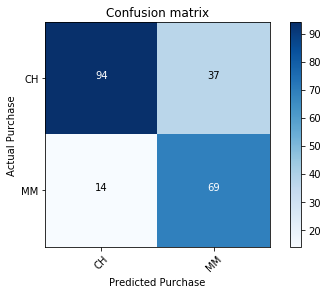

In [74]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [75]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))




Recall for both classes [0.72 0.83]

Precision for both classes [0.87 0.65]

Recall Score: 0.7744412765566081

Precision Score: 0.7606568832983926

F1-Score: 0.758384804409909

Accuracy = 0.76

Kappa = 0.52

Matthews correlation coefficient = 0.53


### 5. KNN

In [91]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Model Parameters - 5. KNN

confusion matrix:
 [[97 34]
 [29 54]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


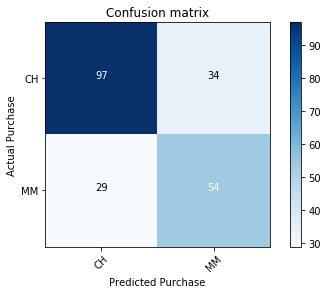

In [92]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [93]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.74 0.65]

Precision for both classes [0.77 0.61]

Recall Score: 0.6955302124528648

Precision Score: 0.6917388167388168

F1-Score: 0.6932213802989965

Accuracy = 0.71

Kappa = 0.39

Matthews correlation coefficient = 0.39


#### Model Tuning - 5. KNN

In [94]:
parameters = {'n_neighbors':(3,5,7,9,11,13,15,17,19,21,23,25)}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
                   
clf.best_params_
clf.best_score_
clf.best_estimator_

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'n_neighbors': (3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(cohen_kappa_score), verbose=0)

{'n_neighbors': 5}

0.48866300366300364

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Tuned Model Parameters - 5. KNN

confusion matrix:
 [[97 34]
 [34 49]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


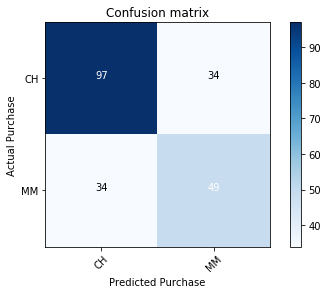

In [95]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [96]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))




Recall for both classes [0.74 0.59]

Precision for both classes [0.74 0.59]

Recall Score: 0.6654097305251541

Precision Score: 0.6654097305251541

F1-Score: 0.6654097305251541

Accuracy = 0.68

Kappa = 0.33

Matthews correlation coefficient = 0.33


### 6. Neural Networks

In [106]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', activation='relu', alpha=1e-3, 
                       hidden_layer_sizes=(3), random_state = 123, verbose=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

clf.loss_
clf.n_layers_

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=3, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=123, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

0.3882376414273526

3

###### Model Parameters - 6. Neural Networks

confusion matrix:
 [[112  19]
 [ 15  68]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


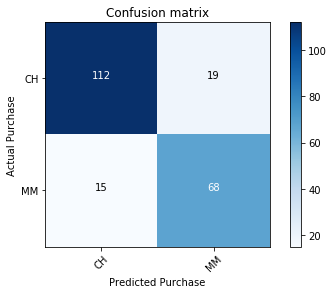

In [98]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [99]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.85 0.82]

Precision for both classes [0.88 0.78]

Recall Score: 0.8371194702474019

Precision Score: 0.8317494795909133

F1-Score: 0.834108527131783

Accuracy = 0.84

Kappa = 0.67

Matthews correlation coefficient = 0.67


#### Model Tuning - 6. Neural Networks

In [107]:
parameters = {'activation':('identity', 'logistic', 'tanh', 'relu'),
             'hidden_layer_sizes':(1,3,5,7,9),
             'solver' : ('lbfgs', 'sgd', 'adam'), 
              'random_state':[123]}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Iteration 1, loss = 1.61157545
Iteration 2, loss = 0.92332543
Iteration 3, loss = 0.69789083
Iteration 4, loss = 0.76568707
Iteration 5, loss = 0.72217643
Iteration 6, loss = 0.68523946
Iteration 7, loss = 0.68467682
Iteration 8, loss = 0.68760377
Iteration 9, loss = 0.68348691
Iteration 10, loss = 0.68228125
Iteration 11, loss = 0.68215951
Iteration 12, loss = 0.68163394
Iteration 13, loss = 0.68027848
Iteration 14, loss = 0.68010185
Iteration 15, loss = 0.68036053
Iteration 16, loss = 0.68014837
Iteration 17, loss = 0.67926152
Iteration 18, loss = 0.67850698
Iteration 19, loss = 0.67876467
Iteration 20, loss = 0.67758433
Iteration 21, loss = 0.67720711
Iteration 22, loss = 0.67708099
Iteration 23, loss = 0.67672656
Iteration 24, loss = 0.67718434
Iteration 25, loss = 0.67639538
Iteration 26, loss = 0.67598870
Iteration 27, loss = 0.67553644
Iteration 28, loss = 0.67504609
Iteration 29, loss = 0.67446320
Iteration 30, loss = 0.67382433
Iteration 31, loss = 0.67396647
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 40, loss = 0.67004219
Iteration 41, loss = 0.66954188
Iteration 42, loss = 0.66985618
Iteration 43, loss = 0.66879567
Iteration 44, loss = 0.66827988
Iteration 45, loss = 0.66824782
Iteration 46, loss = 0.66780481
Iteration 47, loss = 0.66726239
Iteration 48, loss = 0.66713503
Iteration 49, loss = 0.66652973
Iteration 50, loss = 0.66644735
Iteration 51, loss = 0.66651670
Iteration 52, loss = 0.66591483
Iteration 53, loss = 0.66498274
Iteration 54, loss = 0.66545752
Iteration 55, loss = 0.66483644
Iteration 56, loss = 0.66487642
Iteration 57, loss = 0.66435324
Iteration 58, loss = 0.66463965
Iteration 59, loss = 0.66359714
Iteration 60, loss = 0.66288534
Iteration 61, loss = 0.66262795
Iteration 62, loss = 0.66233046
Iteration 63, loss = 0.66262831
Iteration 64, loss = 0.66137408
Iteration 65, loss = 0.66179051
Iteration 66, loss = 0.66121324
Iteration 67, loss = 0.66101419
Iteration 68, loss = 0.66052194
Iteration 69, loss = 0.66105294
Iteration 70, loss = 0.66041479
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 35, loss = 0.66995292
Iteration 36, loss = 0.66936896
Iteration 37, loss = 0.66895318
Iteration 38, loss = 0.66888788
Iteration 39, loss = 0.66901404
Iteration 40, loss = 0.66856526
Iteration 41, loss = 0.66818460
Iteration 42, loss = 0.66760073
Iteration 43, loss = 0.66744466
Iteration 44, loss = 0.66718604
Iteration 45, loss = 0.66677731
Iteration 46, loss = 0.66684185
Iteration 47, loss = 0.66773618
Iteration 48, loss = 0.66742371
Iteration 49, loss = 0.66578645
Iteration 50, loss = 0.66584264
Iteration 51, loss = 0.66655653
Iteration 52, loss = 0.66558029
Iteration 53, loss = 0.66511639
Iteration 54, loss = 0.66454245
Iteration 55, loss = 0.66397230
Iteration 56, loss = 0.66382342
Iteration 57, loss = 0.66362748
Iteration 58, loss = 0.66365351
Iteration 59, loss = 0.66315065
Iteration 60, loss = 0.66342287
Iteration 61, loss = 0.66272749
Iteration 62, loss = 0.66206971
Iteration 63, loss = 0.66181330
Iteration 64, loss = 0.66135039
Iteration 65, loss = 0.66121095
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 29, loss = 0.67384724
Iteration 30, loss = 0.67353614
Iteration 31, loss = 0.67321906
Iteration 32, loss = 0.67293379
Iteration 33, loss = 0.67234917
Iteration 34, loss = 0.67200993
Iteration 35, loss = 0.67263233
Iteration 36, loss = 0.67144211
Iteration 37, loss = 0.67105541
Iteration 38, loss = 0.67105174
Iteration 39, loss = 0.67014404
Iteration 40, loss = 0.66991883
Iteration 41, loss = 0.66994735
Iteration 42, loss = 0.66953629
Iteration 43, loss = 0.66930823
Iteration 44, loss = 0.66880625
Iteration 45, loss = 0.66820408
Iteration 46, loss = 0.66831310
Iteration 47, loss = 0.66960017
Iteration 48, loss = 0.66776661
Iteration 49, loss = 0.66690479
Iteration 50, loss = 0.66817113
Iteration 51, loss = 0.66713607
Iteration 52, loss = 0.66618019
Iteration 53, loss = 0.66786170
Iteration 54, loss = 0.66561313
Iteration 55, loss = 0.66519876
Iteration 56, loss = 0.66495716
Iteration 57, loss = 0.66474777
Iteration 58, loss = 0.66426595
Iteration 59, loss = 0.66374120
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 6, loss = 0.68102379
Iteration 7, loss = 0.68192061
Iteration 8, loss = 0.68716115
Iteration 9, loss = 0.68011684
Iteration 10, loss = 0.67740361
Iteration 11, loss = 0.67671107
Iteration 12, loss = 0.67663316
Iteration 13, loss = 0.67600679
Iteration 14, loss = 0.67604147
Iteration 15, loss = 0.67599314
Iteration 16, loss = 0.67564062
Iteration 17, loss = 0.67468856
Iteration 18, loss = 0.67499901
Iteration 19, loss = 0.67436548
Iteration 20, loss = 0.67374264
Iteration 21, loss = 0.67309436
Iteration 22, loss = 0.67263315
Iteration 23, loss = 0.67258082
Iteration 24, loss = 0.67306156
Iteration 25, loss = 0.67210207
Iteration 26, loss = 0.67131088
Iteration 27, loss = 0.67086033
Iteration 28, loss = 0.67048757
Iteration 29, loss = 0.67068163
Iteration 30, loss = 0.67004899
Iteration 31, loss = 0.66953281
Iteration 32, loss = 0.66936744
Iteration 33, loss = 0.66893870
Iteration 34, loss = 0.66882872
Iteration 35, loss = 0.66891895
Iteration 36, loss = 0.66782121
Iteration 37

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 9, loss = 1.36858980
Iteration 10, loss = 1.32766621
Iteration 11, loss = 1.28668491
Iteration 12, loss = 1.24929238
Iteration 13, loss = 1.21339788
Iteration 14, loss = 1.17914012
Iteration 15, loss = 1.14663852
Iteration 16, loss = 1.11625942
Iteration 17, loss = 1.08640655
Iteration 18, loss = 1.05900220
Iteration 19, loss = 1.03295344
Iteration 20, loss = 1.00812482
Iteration 21, loss = 0.98457986
Iteration 22, loss = 0.96238047
Iteration 23, loss = 0.94262246
Iteration 24, loss = 0.92242698
Iteration 25, loss = 0.90379815
Iteration 26, loss = 0.88586071
Iteration 27, loss = 0.86837648
Iteration 28, loss = 0.85241201
Iteration 29, loss = 0.83692811
Iteration 30, loss = 0.82240336
Iteration 31, loss = 0.80885122
Iteration 32, loss = 0.79679573
Iteration 33, loss = 0.78535808
Iteration 34, loss = 0.77429731
Iteration 35, loss = 0.76416185
Iteration 36, loss = 0.75437967
Iteration 37, loss = 0.74533341
Iteration 38, loss = 0.73747061
Iteration 39, loss = 0.73043439
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 52, loss = 0.67892067
Iteration 53, loss = 0.67713671
Iteration 54, loss = 0.67541496
Iteration 55, loss = 0.67388754
Iteration 56, loss = 0.67249457
Iteration 57, loss = 0.67140107
Iteration 58, loss = 0.67029125
Iteration 59, loss = 0.66941385
Iteration 60, loss = 0.66838672
Iteration 61, loss = 0.66749414
Iteration 62, loss = 0.66658546
Iteration 63, loss = 0.66573111
Iteration 64, loss = 0.66493653
Iteration 65, loss = 0.66410010
Iteration 66, loss = 0.66341555
Iteration 67, loss = 0.66269530
Iteration 68, loss = 0.66204827
Iteration 69, loss = 0.66142877
Iteration 70, loss = 0.66072601
Iteration 71, loss = 0.66020405
Iteration 72, loss = 0.65955673
Iteration 73, loss = 0.65904173
Iteration 74, loss = 0.65847161
Iteration 75, loss = 0.65792001
Iteration 76, loss = 0.65740167
Iteration 77, loss = 0.65688082
Iteration 78, loss = 0.65639212
Iteration 79, loss = 0.65580249
Iteration 80, loss = 0.65531569
Iteration 81, loss = 0.65483653
Iteration 82, loss = 0.65430408
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.74124660
Iteration 3, loss = 1.68537053
Iteration 4, loss = 1.63159731
Iteration 5, loss = 1.58091606
Iteration 6, loss = 1.52987226
Iteration 7, loss = 1.48276457
Iteration 8, loss = 1.43688663
Iteration 9, loss = 1.39202492
Iteration 10, loss = 1.35018549
Iteration 11, loss = 1.30938572
Iteration 12, loss = 1.27196712
Iteration 13, loss = 1.23533403
Iteration 14, loss = 1.20055039
Iteration 15, loss = 1.16735845
Iteration 16, loss = 1.13600172
Iteration 17, loss = 1.10513663
Iteration 18, loss = 1.07659250
Iteration 19, loss = 1.04916401
Iteration 20, loss = 1.02249265
Iteration 21, loss = 0.99811626
Iteration 22, loss = 0.97438067
Iteration 23, loss = 0.95243472
Iteration 24, loss = 0.93155416
Iteration 25, loss = 0.91195832
Iteration 26, loss = 0.89271252
Iteration 27, loss = 0.87522377
Iteration 28, loss = 0.85910530
Iteration 29, loss = 0.84357231
Iteration 30, loss = 0.82938223
Iteration 31, loss = 0.81565502
Iteration 32, loss = 0.80286804
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 43, loss = 0.70690863
Iteration 44, loss = 0.70222361
Iteration 45, loss = 0.69799608
Iteration 46, loss = 0.69396939
Iteration 47, loss = 0.69060279
Iteration 48, loss = 0.68691767
Iteration 49, loss = 0.68411804
Iteration 50, loss = 0.68130692
Iteration 51, loss = 0.67941324
Iteration 52, loss = 0.67735409
Iteration 53, loss = 0.67569192
Iteration 54, loss = 0.67429790
Iteration 55, loss = 0.67292504
Iteration 56, loss = 0.67155452
Iteration 57, loss = 0.67040295
Iteration 58, loss = 0.66926095
Iteration 59, loss = 0.66819467
Iteration 60, loss = 0.66719410
Iteration 61, loss = 0.66620137
Iteration 62, loss = 0.66538129
Iteration 63, loss = 0.66455739
Iteration 64, loss = 0.66384389
Iteration 65, loss = 0.66304346
Iteration 66, loss = 0.66239860
Iteration 67, loss = 0.66178953
Iteration 68, loss = 0.66115889
Iteration 69, loss = 0.66057132
Iteration 70, loss = 0.65999419
Iteration 71, loss = 0.65939653
Iteration 72, loss = 0.65890872
Iteration 73, loss = 0.65829934
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 20, loss = 1.01282132
Iteration 21, loss = 0.98928171
Iteration 22, loss = 0.96600124
Iteration 23, loss = 0.94533070
Iteration 24, loss = 0.92506412
Iteration 25, loss = 0.90602128
Iteration 26, loss = 0.88794177
Iteration 27, loss = 0.87036075
Iteration 28, loss = 0.85526976
Iteration 29, loss = 0.83946044
Iteration 30, loss = 0.82527551
Iteration 31, loss = 0.81191146
Iteration 32, loss = 0.79953033
Iteration 33, loss = 0.78711411
Iteration 34, loss = 0.77609955
Iteration 35, loss = 0.76562401
Iteration 36, loss = 0.75539678
Iteration 37, loss = 0.74662243
Iteration 38, loss = 0.73864081
Iteration 39, loss = 0.73108594
Iteration 40, loss = 0.72447036
Iteration 41, loss = 0.71814959
Iteration 42, loss = 0.71253738
Iteration 43, loss = 0.70781379
Iteration 44, loss = 0.70300647
Iteration 45, loss = 0.69888747
Iteration 46, loss = 0.69489372
Iteration 47, loss = 0.69145492
Iteration 48, loss = 0.68813012
Iteration 49, loss = 0.68523504
Iteration 50, loss = 0.68259093
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70440530
Iteration 2, loss = 0.67937729
Iteration 3, loss = 0.67564870
Iteration 4, loss = 0.67550339
Iteration 5, loss = 0.67387713
Iteration 6, loss = 0.67334398
Iteration 7, loss = 0.67355619
Iteration 8, loss = 0.67289447
Iteration 9, loss = 0.67571619
Iteration 10, loss = 0.67360000
Iteration 11, loss = 0.67134505
Iteration 12, loss = 0.67239633
Iteration 13, loss = 0.67329475
Iteration 14, loss = 0.67047456
Iteration 15, loss = 0.66890600
Iteration 16, loss = 0.66806345
Iteration 17, loss = 0.67126156
Iteration 18, loss = 0.66770527
Iteration 19, loss = 0.66629466
Iteration 20, loss = 0.66707819
Iteration 21, loss = 0.66494975
Iteration 22, loss = 0.66418964
Iteration 23, loss = 0.66307373
Iteration 24, loss = 0.66585815
Iteration 25, loss = 0.66222201
Iteration 26, loss = 0.66224824
Iteration 27, loss = 0.66458648
Iteration 28, loss = 0.66177308
Iteration 29, loss = 0.66258986
Iteration 30, loss = 0.66201075
Iteration 31, loss = 0.65907301
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 22, loss = 0.66363065
Iteration 23, loss = 0.66327977
Iteration 24, loss = 0.66533261
Iteration 25, loss = 0.66191477
Iteration 26, loss = 0.66149471
Iteration 27, loss = 0.66154395
Iteration 28, loss = 0.66239991
Iteration 29, loss = 0.65928874
Iteration 30, loss = 0.66130835
Iteration 31, loss = 0.65907480
Iteration 32, loss = 0.65942631
Iteration 33, loss = 0.65822451
Iteration 34, loss = 0.65797229
Iteration 35, loss = 0.65765227
Iteration 36, loss = 0.65733529
Iteration 37, loss = 0.65836060
Iteration 38, loss = 0.65664890
Iteration 39, loss = 0.65552150
Iteration 40, loss = 0.65479402
Iteration 41, loss = 0.65478541
Iteration 42, loss = 0.65554775
Iteration 43, loss = 0.65460153
Iteration 44, loss = 0.65731506
Iteration 45, loss = 0.65189712
Iteration 46, loss = 0.65209386
Iteration 47, loss = 0.65070622
Iteration 48, loss = 0.65060317
Iteration 49, loss = 0.65079097
Iteration 50, loss = 0.65497968
Iteration 51, loss = 0.65105695
Iteration 52, loss = 0.65699055
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 19, loss = 0.66846006
Iteration 20, loss = 0.66364590
Iteration 21, loss = 0.66445793
Iteration 22, loss = 0.66210311
Iteration 23, loss = 0.66289198
Iteration 24, loss = 0.66280510
Iteration 25, loss = 0.66178655
Iteration 26, loss = 0.66033998
Iteration 27, loss = 0.65945473
Iteration 28, loss = 0.66294915
Iteration 29, loss = 0.65835772
Iteration 30, loss = 0.65847319
Iteration 31, loss = 0.65843645
Iteration 32, loss = 0.66062357
Iteration 33, loss = 0.65730006
Iteration 34, loss = 0.65730299
Iteration 35, loss = 0.65728947
Iteration 36, loss = 0.65566418
Iteration 37, loss = 0.65631907
Iteration 38, loss = 0.65634975
Iteration 39, loss = 0.65407281
Iteration 40, loss = 0.65556092
Iteration 41, loss = 0.65609515
Iteration 42, loss = 0.65363306
Iteration 43, loss = 0.65420163
Iteration 44, loss = 0.65220239
Iteration 45, loss = 0.65128157
Iteration 46, loss = 0.65140103
Iteration 47, loss = 0.65199428
Iteration 48, loss = 0.65019924
Iteration 49, loss = 0.64933073
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 39, loss = 0.65662984
Iteration 40, loss = 0.65670612
Iteration 41, loss = 0.65506270
Iteration 42, loss = 0.65481843
Iteration 43, loss = 0.65442060
Iteration 44, loss = 0.65349960
Iteration 45, loss = 0.65338215
Iteration 46, loss = 0.65289460
Iteration 47, loss = 0.65317505
Iteration 48, loss = 0.65259407
Iteration 49, loss = 0.65397567
Iteration 50, loss = 0.65075482
Iteration 51, loss = 0.65254437
Iteration 52, loss = 0.64949766
Iteration 53, loss = 0.65010874
Iteration 54, loss = 0.64809461
Iteration 55, loss = 0.65189164
Iteration 56, loss = 0.64926574
Iteration 57, loss = 0.65032508
Iteration 58, loss = 0.64875972
Iteration 59, loss = 0.64647555
Iteration 60, loss = 0.64816792
Iteration 61, loss = 0.64636248
Iteration 62, loss = 0.64589112
Iteration 63, loss = 0.64462380
Iteration 64, loss = 0.64383794
Iteration 65, loss = 0.64296692
Iteration 66, loss = 0.64269407
Iteration 67, loss = 0.64338408
Iteration 68, loss = 0.64417810
Iteration 69, loss = 0.64135876
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 38, loss = 0.66414870
Iteration 39, loss = 0.65657298
Iteration 40, loss = 0.65591583
Iteration 41, loss = 0.65407372
Iteration 42, loss = 0.65359253
Iteration 43, loss = 0.65318928
Iteration 44, loss = 0.65255853
Iteration 45, loss = 0.65227866
Iteration 46, loss = 0.65194501
Iteration 47, loss = 0.65144161
Iteration 48, loss = 0.65141820
Iteration 49, loss = 0.65164616
Iteration 50, loss = 0.65012932
Iteration 51, loss = 0.65182754
Iteration 52, loss = 0.64852256
Iteration 53, loss = 0.64763591
Iteration 54, loss = 0.64828070
Iteration 55, loss = 0.64887908
Iteration 56, loss = 0.65245719
Iteration 57, loss = 0.64690553
Iteration 58, loss = 0.64664950
Iteration 59, loss = 0.64543629
Iteration 60, loss = 0.64442639
Iteration 61, loss = 0.64451079
Iteration 62, loss = 0.64415729
Iteration 63, loss = 0.64389140
Iteration 64, loss = 0.64244964
Iteration 65, loss = 0.64248908
Iteration 66, loss = 0.64258667
Iteration 67, loss = 0.64363198
Iteration 68, loss = 0.64407340
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 44, loss = 0.61338676
Iteration 45, loss = 0.61214725
Iteration 46, loss = 0.61086220
Iteration 47, loss = 0.60982794
Iteration 48, loss = 0.60880932
Iteration 49, loss = 0.60748260
Iteration 50, loss = 0.60736928
Iteration 51, loss = 0.60687911
Iteration 52, loss = 0.60586848
Iteration 53, loss = 0.60329895
Iteration 54, loss = 0.60279015
Iteration 55, loss = 0.60170826
Iteration 56, loss = 0.60030749
Iteration 57, loss = 0.59942068
Iteration 58, loss = 0.59827527
Iteration 59, loss = 0.59705668
Iteration 60, loss = 0.59615874
Iteration 61, loss = 0.59537292
Iteration 62, loss = 0.59433847
Iteration 63, loss = 0.59353432
Iteration 64, loss = 0.59271798
Iteration 65, loss = 0.59181777
Iteration 66, loss = 0.59034676
Iteration 67, loss = 0.58930872
Iteration 68, loss = 0.58903889
Iteration 69, loss = 0.58882550
Iteration 70, loss = 0.58685793
Iteration 71, loss = 0.58670635
Iteration 72, loss = 0.58628238
Iteration 73, loss = 0.58407354
Iteration 74, loss = 0.58393582
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 29, loss = 0.63416368
Iteration 30, loss = 0.63236038
Iteration 31, loss = 0.63130532
Iteration 32, loss = 0.62982644
Iteration 33, loss = 0.62873569
Iteration 34, loss = 0.62759622
Iteration 35, loss = 0.62646812
Iteration 36, loss = 0.62537161
Iteration 37, loss = 0.62439650
Iteration 38, loss = 0.62320283
Iteration 39, loss = 0.62180974
Iteration 40, loss = 0.62099701
Iteration 41, loss = 0.62053580
Iteration 42, loss = 0.61851572
Iteration 43, loss = 0.61792758
Iteration 44, loss = 0.61713251
Iteration 45, loss = 0.61567539
Iteration 46, loss = 0.61450695
Iteration 47, loss = 0.61348468
Iteration 48, loss = 0.61239104
Iteration 49, loss = 0.61124762
Iteration 50, loss = 0.61075062
Iteration 51, loss = 0.61087497
Iteration 52, loss = 0.60981040
Iteration 53, loss = 0.60741685
Iteration 54, loss = 0.60766528
Iteration 55, loss = 0.60628109
Iteration 56, loss = 0.60476987
Iteration 57, loss = 0.60343076
Iteration 58, loss = 0.60279435
Iteration 59, loss = 0.60130129
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 48, loss = 0.61026926
Iteration 49, loss = 0.60915924
Iteration 50, loss = 0.60788492
Iteration 51, loss = 0.60729513
Iteration 52, loss = 0.60653885
Iteration 53, loss = 0.60504437
Iteration 54, loss = 0.60392162
Iteration 55, loss = 0.60277718
Iteration 56, loss = 0.60355271
Iteration 57, loss = 0.60201131
Iteration 58, loss = 0.59919941
Iteration 59, loss = 0.59933338
Iteration 60, loss = 0.60057040
Iteration 61, loss = 0.59833374
Iteration 62, loss = 0.59546008
Iteration 63, loss = 0.59462788
Iteration 64, loss = 0.59368339
Iteration 65, loss = 0.59285283
Iteration 66, loss = 0.59203469
Iteration 67, loss = 0.59060373
Iteration 68, loss = 0.58952697
Iteration 69, loss = 0.58995287
Iteration 70, loss = 0.58837316
Iteration 71, loss = 0.58694649
Iteration 72, loss = 0.58599583
Iteration 73, loss = 0.58493968
Iteration 74, loss = 0.58384717
Iteration 75, loss = 0.58321471
Iteration 76, loss = 0.58228799
Iteration 77, loss = 0.58084276
Iteration 78, loss = 0.58031656
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 13, loss = 0.65675827
Iteration 14, loss = 0.65521107
Iteration 15, loss = 0.65342751
Iteration 16, loss = 0.65180225
Iteration 17, loss = 0.65038089
Iteration 18, loss = 0.64864884
Iteration 19, loss = 0.64692498
Iteration 20, loss = 0.64531929
Iteration 21, loss = 0.64391907
Iteration 22, loss = 0.64243871
Iteration 23, loss = 0.64127165
Iteration 24, loss = 0.64039384
Iteration 25, loss = 0.63945357
Iteration 26, loss = 0.63828149
Iteration 27, loss = 0.63672163
Iteration 28, loss = 0.63486027
Iteration 29, loss = 0.63353888
Iteration 30, loss = 0.63239842
Iteration 31, loss = 0.63120329
Iteration 32, loss = 0.63078575
Iteration 33, loss = 0.63005355
Iteration 34, loss = 0.62849492
Iteration 35, loss = 0.62657953
Iteration 36, loss = 0.62592691
Iteration 37, loss = 0.62526719
Iteration 38, loss = 0.62449220
Iteration 39, loss = 0.62341471
Iteration 40, loss = 0.62190346
Iteration 41, loss = 0.62032038
Iteration 42, loss = 0.61952566
Iteration 43, loss = 0.61847514
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 41, loss = 0.61914682
Iteration 42, loss = 0.61823054
Iteration 43, loss = 0.61727180
Iteration 44, loss = 0.61610364
Iteration 45, loss = 0.61506757
Iteration 46, loss = 0.61383955
Iteration 47, loss = 0.61318492
Iteration 48, loss = 0.61199433
Iteration 49, loss = 0.61081030
Iteration 50, loss = 0.61005543
Iteration 51, loss = 0.60959366
Iteration 52, loss = 0.60880117
Iteration 53, loss = 0.60725410
Iteration 54, loss = 0.60642330
Iteration 55, loss = 0.60486552
Iteration 56, loss = 0.60462879
Iteration 57, loss = 0.60488126
Iteration 58, loss = 0.60330151
Iteration 59, loss = 0.60190194
Iteration 60, loss = 0.60084913
Iteration 61, loss = 0.59993256
Iteration 62, loss = 0.59881094
Iteration 63, loss = 0.59775446
Iteration 64, loss = 0.59680080
Iteration 65, loss = 0.59602522
Iteration 66, loss = 0.59502615
Iteration 67, loss = 0.59423777
Iteration 68, loss = 0.59319986
Iteration 69, loss = 0.59284547
Iteration 70, loss = 0.59185246
Iteration 71, loss = 0.59068537
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.91675354
Iteration 2, loss = 0.79050560
Iteration 3, loss = 0.76820333
Iteration 4, loss = 0.78973010
Iteration 5, loss = 0.76258989
Iteration 6, loss = 0.76372626
Iteration 7, loss = 0.75625398
Iteration 8, loss = 0.75692662
Iteration 9, loss = 0.75017697
Iteration 10, loss = 0.75110571
Iteration 11, loss = 0.75284997
Iteration 12, loss = 0.74439705
Iteration 13, loss = 0.74118034
Iteration 14, loss = 0.73607347
Iteration 15, loss = 0.73925872
Iteration 16, loss = 0.73844886
Iteration 17, loss = 0.73507474
Iteration 18, loss = 0.73068383
Iteration 19, loss = 0.72935834
Iteration 20, loss = 0.72999386
Iteration 21, loss = 0.72626464
Iteration 22, loss = 0.72324499
Iteration 23, loss = 0.73275477
Iteration 24, loss = 0.72601780
Iteration 25, loss = 0.71918546
Iteration 26, loss = 0.71704073
Iteration 27, loss = 0.71664307
Iteration 28, loss = 0.72064411
Iteration 29, loss = 0.71835551
Iteration 30, loss = 0.74067274
Iteration 31, loss = 0.71324141
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 0.76349914
Iteration 3, loss = 0.76228375
Iteration 4, loss = 0.76323331
Iteration 5, loss = 0.75239264
Iteration 6, loss = 0.75154824
Iteration 7, loss = 0.75025637
Iteration 8, loss = 0.74936782
Iteration 9, loss = 0.75381751
Iteration 10, loss = 0.74011670
Iteration 11, loss = 0.73655861
Iteration 12, loss = 0.73572798
Iteration 13, loss = 0.73810453
Iteration 14, loss = 0.73249176
Iteration 15, loss = 0.73520900
Iteration 16, loss = 0.73047821
Iteration 17, loss = 0.73450838
Iteration 18, loss = 0.72556648
Iteration 19, loss = 0.72231877
Iteration 20, loss = 0.72245806
Iteration 21, loss = 0.72447321
Iteration 22, loss = 0.71752659
Iteration 23, loss = 0.71644553
Iteration 24, loss = 0.71384924
Iteration 25, loss = 0.71325855
Iteration 26, loss = 0.71237859
Iteration 27, loss = 0.73078123
Iteration 28, loss = 0.73031390
Iteration 29, loss = 0.70630592
Iteration 30, loss = 0.71671539
Iteration 31, loss = 0.71329594
Iteration 32, loss = 0.70591555
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 0.80953126
Iteration 3, loss = 0.76129968
Iteration 4, loss = 0.78049845
Iteration 5, loss = 0.79470267
Iteration 6, loss = 0.75657053
Iteration 7, loss = 0.74877108
Iteration 8, loss = 0.74989901
Iteration 9, loss = 0.75263702
Iteration 10, loss = 0.74472053
Iteration 11, loss = 0.74114453
Iteration 12, loss = 0.73691489
Iteration 13, loss = 0.74190548
Iteration 14, loss = 0.73955676
Iteration 15, loss = 0.73275326
Iteration 16, loss = 0.73154051
Iteration 17, loss = 0.73930857
Iteration 18, loss = 0.72860634
Iteration 19, loss = 0.73057208
Iteration 20, loss = 0.72685495
Iteration 21, loss = 0.72192881
Iteration 22, loss = 0.73396232
Iteration 23, loss = 0.71956864
Iteration 24, loss = 0.72951400
Iteration 25, loss = 0.71861680
Iteration 26, loss = 0.71303134
Iteration 27, loss = 0.73211544
Iteration 28, loss = 0.71848572
Iteration 29, loss = 0.72688618
Iteration 30, loss = 0.71564591
Iteration 31, loss = 0.71185969
Iteration 32, loss = 0.71580979
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 52, loss = 0.68457154
Iteration 53, loss = 0.72544520
Iteration 54, loss = 0.68026489
Iteration 55, loss = 0.68124841
Iteration 56, loss = 0.68067194
Iteration 57, loss = 0.67977285
Iteration 58, loss = 0.67633015
Iteration 59, loss = 0.67758002
Iteration 60, loss = 0.67653559
Iteration 61, loss = 0.67522019
Iteration 62, loss = 0.67886555
Iteration 63, loss = 0.67225714
Iteration 64, loss = 0.67216561
Iteration 65, loss = 0.67047349
Iteration 66, loss = 0.66849177
Iteration 67, loss = 0.66772392
Iteration 68, loss = 0.66664641
Iteration 69, loss = 0.67573582
Iteration 70, loss = 0.66863911
Iteration 71, loss = 0.66831148
Iteration 72, loss = 0.66388363
Iteration 73, loss = 0.66416099
Iteration 74, loss = 0.66209878
Iteration 75, loss = 0.66062705
Iteration 76, loss = 0.65974929
Iteration 77, loss = 0.66419077
Iteration 78, loss = 0.65896858
Iteration 79, loss = 0.65641976
Iteration 80, loss = 0.65900763
Iteration 81, loss = 0.65600834
Iteration 82, loss = 0.65422042
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 50, loss = 0.68389236
Iteration 51, loss = 0.68513251
Iteration 52, loss = 0.68056122
Iteration 53, loss = 0.70518635
Iteration 54, loss = 0.67897520
Iteration 55, loss = 0.68228578
Iteration 56, loss = 0.67789127
Iteration 57, loss = 0.67994597
Iteration 58, loss = 0.67263428
Iteration 59, loss = 0.67680465
Iteration 60, loss = 0.67347708
Iteration 61, loss = 0.67354303
Iteration 62, loss = 0.67135418
Iteration 63, loss = 0.66873996
Iteration 64, loss = 0.66870585
Iteration 65, loss = 0.66741172
Iteration 66, loss = 0.66709726
Iteration 67, loss = 0.66506772
Iteration 68, loss = 0.66375713
Iteration 69, loss = 0.66951117
Iteration 70, loss = 0.66174318
Iteration 71, loss = 0.66639083
Iteration 72, loss = 0.66547396
Iteration 73, loss = 0.65931697
Iteration 74, loss = 0.65881886
Iteration 75, loss = 0.66029861
Iteration 76, loss = 0.66131225
Iteration 77, loss = 0.65821617
Iteration 78, loss = 0.65917375
Iteration 79, loss = 0.65511700
Iteration 80, loss = 0.65734046
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 45, loss = 0.64137545
Iteration 46, loss = 0.63975720
Iteration 47, loss = 0.63743245
Iteration 48, loss = 0.63529603
Iteration 49, loss = 0.63391594
Iteration 50, loss = 0.63184072
Iteration 51, loss = 0.62922475
Iteration 52, loss = 0.62749323
Iteration 53, loss = 0.62537306
Iteration 54, loss = 0.62374748
Iteration 55, loss = 0.62161692
Iteration 56, loss = 0.61964741
Iteration 57, loss = 0.61809493
Iteration 58, loss = 0.61664477
Iteration 59, loss = 0.61451918
Iteration 60, loss = 0.61262577
Iteration 61, loss = 0.61098793
Iteration 62, loss = 0.60938733
Iteration 63, loss = 0.60771960
Iteration 64, loss = 0.60632001
Iteration 65, loss = 0.60453158
Iteration 66, loss = 0.60313517
Iteration 67, loss = 0.60181423
Iteration 68, loss = 0.59981096
Iteration 69, loss = 0.59836705
Iteration 70, loss = 0.59669428
Iteration 71, loss = 0.59521930
Iteration 72, loss = 0.59333086
Iteration 73, loss = 0.59196861
Iteration 74, loss = 0.59091788
Iteration 75, loss = 0.58968268
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 14, loss = 0.71639743
Iteration 15, loss = 0.71324487
Iteration 16, loss = 0.71066396
Iteration 17, loss = 0.70785072
Iteration 18, loss = 0.70413231
Iteration 19, loss = 0.70209151
Iteration 20, loss = 0.69923763
Iteration 21, loss = 0.69615843
Iteration 22, loss = 0.69429767
Iteration 23, loss = 0.69162961
Iteration 24, loss = 0.68881543
Iteration 25, loss = 0.68612524
Iteration 26, loss = 0.68391566
Iteration 27, loss = 0.68162377
Iteration 28, loss = 0.67884947
Iteration 29, loss = 0.67695990
Iteration 30, loss = 0.67447184
Iteration 31, loss = 0.67207045
Iteration 32, loss = 0.67037504
Iteration 33, loss = 0.66919624
Iteration 34, loss = 0.66656883
Iteration 35, loss = 0.66395162
Iteration 36, loss = 0.66117732
Iteration 37, loss = 0.66000188
Iteration 38, loss = 0.65752867
Iteration 39, loss = 0.65518269
Iteration 40, loss = 0.65455555
Iteration 41, loss = 0.65181916
Iteration 42, loss = 0.64912589
Iteration 43, loss = 0.64750690
Iteration 44, loss = 0.64588632
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.93555840
Iteration 3, loss = 0.81370102
Iteration 4, loss = 0.75663020
Iteration 5, loss = 0.74956946
Iteration 6, loss = 0.74889690
Iteration 7, loss = 0.74531039
Iteration 8, loss = 0.73979354
Iteration 9, loss = 0.73414485
Iteration 10, loss = 0.73161385
Iteration 11, loss = 0.72868638
Iteration 12, loss = 0.72520560
Iteration 13, loss = 0.72188275
Iteration 14, loss = 0.71911305
Iteration 15, loss = 0.71599276
Iteration 16, loss = 0.71306435
Iteration 17, loss = 0.70961703
Iteration 18, loss = 0.70684189
Iteration 19, loss = 0.70381375
Iteration 20, loss = 0.70100249
Iteration 21, loss = 0.69825356
Iteration 22, loss = 0.69552774
Iteration 23, loss = 0.69296841
Iteration 24, loss = 0.69034569
Iteration 25, loss = 0.68774022
Iteration 26, loss = 0.68551674
Iteration 27, loss = 0.68299546
Iteration 28, loss = 0.68010955
Iteration 29, loss = 0.67832018
Iteration 30, loss = 0.67581363
Iteration 31, loss = 0.67238795
Iteration 32, loss = 0.67097233
Iteration 33, lo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 41, loss = 0.65219277
Iteration 42, loss = 0.65064348
Iteration 43, loss = 0.64841546
Iteration 44, loss = 0.64756938
Iteration 45, loss = 0.64447733
Iteration 46, loss = 0.64249611
Iteration 47, loss = 0.64061186
Iteration 48, loss = 0.63892700
Iteration 49, loss = 0.63736612
Iteration 50, loss = 0.63529791
Iteration 51, loss = 0.63355189
Iteration 52, loss = 0.63271743
Iteration 53, loss = 0.62980242
Iteration 54, loss = 0.63160075
Iteration 55, loss = 0.62946216
Iteration 56, loss = 0.62571173
Iteration 57, loss = 0.62320076
Iteration 58, loss = 0.62226667
Iteration 59, loss = 0.62096590
Iteration 60, loss = 0.61871176
Iteration 61, loss = 0.61727176
Iteration 62, loss = 0.61573737
Iteration 63, loss = 0.61447572
Iteration 64, loss = 0.61325983
Iteration 65, loss = 0.61155617
Iteration 66, loss = 0.60999045
Iteration 67, loss = 0.60844544
Iteration 68, loss = 0.60718200
Iteration 69, loss = 0.60501248
Iteration 70, loss = 0.60532791
Iteration 71, loss = 0.60408756
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 23, loss = 0.69043816
Iteration 24, loss = 0.68783035
Iteration 25, loss = 0.68517679
Iteration 26, loss = 0.68279102
Iteration 27, loss = 0.68057286
Iteration 28, loss = 0.67791078
Iteration 29, loss = 0.67578292
Iteration 30, loss = 0.67450199
Iteration 31, loss = 0.67129099
Iteration 32, loss = 0.66937055
Iteration 33, loss = 0.66755156
Iteration 34, loss = 0.66516695
Iteration 35, loss = 0.66190187
Iteration 36, loss = 0.65996371
Iteration 37, loss = 0.65831858
Iteration 38, loss = 0.65658109
Iteration 39, loss = 0.65408393
Iteration 40, loss = 0.65154688
Iteration 41, loss = 0.64964021
Iteration 42, loss = 0.64777038
Iteration 43, loss = 0.64560605
Iteration 44, loss = 0.64486958
Iteration 45, loss = 0.64188066
Iteration 46, loss = 0.64005387
Iteration 47, loss = 0.63841110
Iteration 48, loss = 0.63661684
Iteration 49, loss = 0.63511266
Iteration 50, loss = 0.63329474
Iteration 51, loss = 0.63139908
Iteration 52, loss = 0.62981311
Iteration 53, loss = 0.62721999
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 20, loss = 0.71002954
Iteration 21, loss = 0.70857920
Iteration 22, loss = 0.70120947
Iteration 23, loss = 0.69609636
Iteration 24, loss = 0.69326705
Iteration 25, loss = 0.68961050
Iteration 26, loss = 0.68584138
Iteration 27, loss = 0.68236179
Iteration 28, loss = 0.69195191
Iteration 29, loss = 0.67647484
Iteration 30, loss = 0.67575955
Iteration 31, loss = 0.67577274
Iteration 32, loss = 0.67236672
Iteration 33, loss = 0.66870433
Iteration 34, loss = 0.67508663
Iteration 35, loss = 0.66328265
Iteration 36, loss = 0.66455936
Iteration 37, loss = 0.66727955
Iteration 38, loss = 0.66209758
Iteration 39, loss = 0.65851973
Iteration 40, loss = 0.65765557
Iteration 41, loss = 0.65543780
Iteration 42, loss = 0.65141113
Iteration 43, loss = 0.66624773
Iteration 44, loss = 0.65809053
Iteration 45, loss = 0.65947385
Iteration 46, loss = 0.64890364
Iteration 47, loss = 0.64863108
Iteration 48, loss = 0.64552118
Iteration 49, loss = 0.64200501
Iteration 50, loss = 0.64459399
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 23, loss = 0.70199445
Iteration 24, loss = 0.69394690
Iteration 25, loss = 0.69068890
Iteration 26, loss = 0.68653348
Iteration 27, loss = 0.68549319
Iteration 28, loss = 0.69078374
Iteration 29, loss = 0.68306106
Iteration 30, loss = 0.67829314
Iteration 31, loss = 0.68140209
Iteration 32, loss = 0.67755190
Iteration 33, loss = 0.67703509
Iteration 34, loss = 0.67134363
Iteration 35, loss = 0.66581798
Iteration 36, loss = 0.66868430
Iteration 37, loss = 0.66544893
Iteration 38, loss = 0.66447040
Iteration 39, loss = 0.66089128
Iteration 40, loss = 0.65792128
Iteration 41, loss = 0.66037341
Iteration 42, loss = 0.65537331
Iteration 43, loss = 0.65845431
Iteration 44, loss = 0.65899074
Iteration 45, loss = 0.66578096
Iteration 46, loss = 0.65030657
Iteration 47, loss = 0.66363714
Iteration 48, loss = 0.65075526
Iteration 49, loss = 0.64817987
Iteration 50, loss = 0.64743982
Iteration 51, loss = 0.66080582
Iteration 52, loss = 0.64541398
Iteration 53, loss = 0.64923957
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 12, loss = 0.79499365
Iteration 13, loss = 0.78207270
Iteration 14, loss = 0.76398525
Iteration 15, loss = 0.75883067
Iteration 16, loss = 0.74485198
Iteration 17, loss = 0.73344864
Iteration 18, loss = 0.72486814
Iteration 19, loss = 0.71720448
Iteration 20, loss = 0.71233257
Iteration 21, loss = 0.70700823
Iteration 22, loss = 0.70139533
Iteration 23, loss = 0.69815550
Iteration 24, loss = 0.69174871
Iteration 25, loss = 0.68867700
Iteration 26, loss = 0.68470588
Iteration 27, loss = 0.68945466
Iteration 28, loss = 0.67919389
Iteration 29, loss = 0.67944452
Iteration 30, loss = 0.67254707
Iteration 31, loss = 0.67019553
Iteration 32, loss = 0.67838938
Iteration 33, loss = 0.66605869
Iteration 34, loss = 0.66854542
Iteration 35, loss = 0.66203674
Iteration 36, loss = 0.66942959
Iteration 37, loss = 0.65777917
Iteration 38, loss = 0.65959654
Iteration 39, loss = 0.65972480
Iteration 40, loss = 0.65468785
Iteration 41, loss = 0.64998449
Iteration 42, loss = 0.65030929
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 22, loss = 0.70127630
Iteration 23, loss = 0.70077671
Iteration 24, loss = 0.69618749
Iteration 25, loss = 0.68954254
Iteration 26, loss = 0.68945311
Iteration 27, loss = 0.68674721
Iteration 28, loss = 0.67986108
Iteration 29, loss = 0.67744818
Iteration 30, loss = 0.67492239
Iteration 31, loss = 0.67368658
Iteration 32, loss = 0.67868087
Iteration 33, loss = 0.67792969
Iteration 34, loss = 0.67091392
Iteration 35, loss = 0.66395559
Iteration 36, loss = 0.66165971
Iteration 37, loss = 0.66334517
Iteration 38, loss = 0.67433527
Iteration 39, loss = 0.65772837
Iteration 40, loss = 0.65551081
Iteration 41, loss = 0.65523005
Iteration 42, loss = 0.65543892
Iteration 43, loss = 0.65705375
Iteration 44, loss = 0.65024995
Iteration 45, loss = 0.64854788
Iteration 46, loss = 0.64976203
Iteration 47, loss = 0.64597913
Iteration 48, loss = 0.64503375
Iteration 49, loss = 0.65044386
Iteration 50, loss = 0.64565503
Iteration 51, loss = 0.64327857
Iteration 52, loss = 0.64154819
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 14, loss = 0.76588761
Iteration 15, loss = 0.77661539
Iteration 16, loss = 0.74785858
Iteration 17, loss = 0.73644038
Iteration 18, loss = 0.73339011
Iteration 19, loss = 0.72564923
Iteration 20, loss = 0.71822973
Iteration 21, loss = 0.71383110
Iteration 22, loss = 0.70556937
Iteration 23, loss = 0.70410912
Iteration 24, loss = 0.69960577
Iteration 25, loss = 0.69564433
Iteration 26, loss = 0.69279855
Iteration 27, loss = 0.69710383
Iteration 28, loss = 0.68568923
Iteration 29, loss = 0.68124627
Iteration 30, loss = 0.67902128
Iteration 31, loss = 0.67624888
Iteration 32, loss = 0.67662057
Iteration 33, loss = 0.67258174
Iteration 34, loss = 0.67186147
Iteration 35, loss = 0.66850541
Iteration 36, loss = 0.66896100
Iteration 37, loss = 0.67780040
Iteration 38, loss = 0.67624745
Iteration 39, loss = 0.66034265
Iteration 40, loss = 0.65860275
Iteration 41, loss = 0.66050205
Iteration 42, loss = 0.65613828
Iteration 43, loss = 0.65857665
Iteration 44, loss = 0.65541920
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 26, loss = 0.75346573
Iteration 27, loss = 0.74565704
Iteration 28, loss = 0.73799021
Iteration 29, loss = 0.73130033
Iteration 30, loss = 0.72389035
Iteration 31, loss = 0.71646704
Iteration 32, loss = 0.70915178
Iteration 33, loss = 0.70232339
Iteration 34, loss = 0.69588309
Iteration 35, loss = 0.68917603
Iteration 36, loss = 0.68308734
Iteration 37, loss = 0.67658726
Iteration 38, loss = 0.67032260
Iteration 39, loss = 0.66544849
Iteration 40, loss = 0.65992498
Iteration 41, loss = 0.65407214
Iteration 42, loss = 0.64882680
Iteration 43, loss = 0.64412785
Iteration 44, loss = 0.63932815
Iteration 45, loss = 0.63406818
Iteration 46, loss = 0.63064913
Iteration 47, loss = 0.62595868
Iteration 48, loss = 0.62170159
Iteration 49, loss = 0.61762062
Iteration 50, loss = 0.61394498
Iteration 51, loss = 0.60987813
Iteration 52, loss = 0.60636600
Iteration 53, loss = 0.60312799
Iteration 54, loss = 0.59979486
Iteration 55, loss = 0.59620337
Iteration 56, loss = 0.59321120
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 13, loss = 0.88145948
Iteration 14, loss = 0.86099897
Iteration 15, loss = 0.84725149
Iteration 16, loss = 0.83706315
Iteration 17, loss = 0.82882857
Iteration 18, loss = 0.82066188
Iteration 19, loss = 0.81182286
Iteration 20, loss = 0.80332085
Iteration 21, loss = 0.79409648
Iteration 22, loss = 0.78523437
Iteration 23, loss = 0.77650398
Iteration 24, loss = 0.76787171
Iteration 25, loss = 0.75989628
Iteration 26, loss = 0.75195940
Iteration 27, loss = 0.74431253
Iteration 28, loss = 0.73654847
Iteration 29, loss = 0.72990116
Iteration 30, loss = 0.72274517
Iteration 31, loss = 0.71583529
Iteration 32, loss = 0.70896874
Iteration 33, loss = 0.70236670
Iteration 34, loss = 0.69634681
Iteration 35, loss = 0.68984576
Iteration 36, loss = 0.68374668
Iteration 37, loss = 0.67749373
Iteration 38, loss = 0.67145522
Iteration 39, loss = 0.66622149
Iteration 40, loss = 0.66095504
Iteration 41, loss = 0.65577896
Iteration 42, loss = 0.65048361
Iteration 43, loss = 0.64571753
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 31, loss = 0.71688133
Iteration 32, loss = 0.70966940
Iteration 33, loss = 0.70316870
Iteration 34, loss = 0.69645116
Iteration 35, loss = 0.68966353
Iteration 36, loss = 0.68324129
Iteration 37, loss = 0.67700384
Iteration 38, loss = 0.67107271
Iteration 39, loss = 0.66578095
Iteration 40, loss = 0.66036649
Iteration 41, loss = 0.65418516
Iteration 42, loss = 0.64913623
Iteration 43, loss = 0.64425794
Iteration 44, loss = 0.63952136
Iteration 45, loss = 0.63457380
Iteration 46, loss = 0.63014223
Iteration 47, loss = 0.62570735
Iteration 48, loss = 0.62135066
Iteration 49, loss = 0.61768279
Iteration 50, loss = 0.61415751
Iteration 51, loss = 0.61079079
Iteration 52, loss = 0.60700551
Iteration 53, loss = 0.60321322
Iteration 54, loss = 0.59982935
Iteration 55, loss = 0.59697238
Iteration 56, loss = 0.59374510
Iteration 57, loss = 0.59069971
Iteration 58, loss = 0.58762319
Iteration 59, loss = 0.58462904
Iteration 60, loss = 0.58175761
Iteration 61, loss = 0.58056385
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 6, loss = 1.28136837
Iteration 7, loss = 1.05254763
Iteration 8, loss = 0.93177094
Iteration 9, loss = 0.90002209
Iteration 10, loss = 0.90400523
Iteration 11, loss = 0.91030702
Iteration 12, loss = 0.90121187
Iteration 13, loss = 0.88137502
Iteration 14, loss = 0.86274643
Iteration 15, loss = 0.84890200
Iteration 16, loss = 0.83971902
Iteration 17, loss = 0.83143238
Iteration 18, loss = 0.82307573
Iteration 19, loss = 0.81355406
Iteration 20, loss = 0.80462290
Iteration 21, loss = 0.79540312
Iteration 22, loss = 0.78648188
Iteration 23, loss = 0.77802874
Iteration 24, loss = 0.76965741
Iteration 25, loss = 0.76171841
Iteration 26, loss = 0.75412140
Iteration 27, loss = 0.74679387
Iteration 28, loss = 0.73917747
Iteration 29, loss = 0.73181997
Iteration 30, loss = 0.72424773
Iteration 31, loss = 0.71731954
Iteration 32, loss = 0.71021576
Iteration 33, loss = 0.70420365
Iteration 34, loss = 0.69775841
Iteration 35, loss = 0.69103083
Iteration 36, loss = 0.68442944
Iteration 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 6, loss = 1.29023426
Iteration 7, loss = 1.06301856
Iteration 8, loss = 0.93797159
Iteration 9, loss = 0.90632762
Iteration 10, loss = 0.90942527
Iteration 11, loss = 0.91327033
Iteration 12, loss = 0.90358914
Iteration 13, loss = 0.88491364
Iteration 14, loss = 0.86684933
Iteration 15, loss = 0.85327440
Iteration 16, loss = 0.84590613
Iteration 17, loss = 0.83815383
Iteration 18, loss = 0.82952480
Iteration 19, loss = 0.81935264
Iteration 20, loss = 0.81032413
Iteration 21, loss = 0.80122658
Iteration 22, loss = 0.79280096
Iteration 23, loss = 0.78444027
Iteration 24, loss = 0.77589351
Iteration 25, loss = 0.76777789
Iteration 26, loss = 0.76023429
Iteration 27, loss = 0.75235388
Iteration 28, loss = 0.74496767
Iteration 29, loss = 0.73767880
Iteration 30, loss = 0.73028928
Iteration 31, loss = 0.72319236
Iteration 32, loss = 0.71595226
Iteration 33, loss = 0.70942115
Iteration 34, loss = 0.70262368
Iteration 35, loss = 0.69601630
Iteration 36, loss = 0.68975026
Iteration 37

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 4, loss = 0.79596098
Iteration 5, loss = 0.79153731
Iteration 6, loss = 0.78892003
Iteration 7, loss = 0.78780341
Iteration 8, loss = 0.79328146
Iteration 9, loss = 0.77625672
Iteration 10, loss = 0.77171201
Iteration 11, loss = 0.76979330
Iteration 12, loss = 0.76780523
Iteration 13, loss = 0.76189605
Iteration 14, loss = 0.75697053
Iteration 15, loss = 0.75453197
Iteration 16, loss = 0.76742559
Iteration 17, loss = 0.75992838
Iteration 18, loss = 0.74547080
Iteration 19, loss = 0.74752692
Iteration 20, loss = 0.73927466
Iteration 21, loss = 0.77837003
Iteration 22, loss = 0.73573669
Iteration 23, loss = 0.73711447
Iteration 24, loss = 0.73701179
Iteration 25, loss = 0.72925753
Iteration 26, loss = 0.72174670
Iteration 27, loss = 0.72126658
Iteration 28, loss = 0.72285145
Iteration 29, loss = 0.71580037
Iteration 30, loss = 0.71533680
Iteration 31, loss = 0.71183566
Iteration 32, loss = 0.70945989
Iteration 33, loss = 0.70805212
Iteration 34, loss = 0.71175918
Iteration 35,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 53, loss = 0.67290117
Iteration 54, loss = 0.67008914
Iteration 55, loss = 0.66636495
Iteration 56, loss = 0.66406423
Iteration 57, loss = 0.66551475
Iteration 58, loss = 0.65960894
Iteration 59, loss = 0.65701071
Iteration 60, loss = 0.66072779
Iteration 61, loss = 0.65535536
Iteration 62, loss = 0.66506180
Iteration 63, loss = 0.66443889
Iteration 64, loss = 0.65170562
Iteration 65, loss = 0.65604000
Iteration 66, loss = 0.64509436
Iteration 67, loss = 0.65921018
Iteration 68, loss = 0.64800299
Iteration 69, loss = 0.64554234
Iteration 70, loss = 0.65742968
Iteration 71, loss = 0.64263531
Iteration 72, loss = 0.64558681
Iteration 73, loss = 0.63759639
Iteration 74, loss = 0.64234251
Iteration 75, loss = 0.64193204
Iteration 76, loss = 0.63433705
Iteration 77, loss = 0.63262599
Iteration 78, loss = 0.63306991
Iteration 79, loss = 0.62777528
Iteration 80, loss = 0.63217817
Iteration 81, loss = 0.63042040
Iteration 82, loss = 0.63097628
Iteration 83, loss = 0.62482344
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 49, loss = 0.67430781
Iteration 50, loss = 0.68851144
Iteration 51, loss = 0.67724321
Iteration 52, loss = 0.67385717
Iteration 53, loss = 0.67735482
Iteration 54, loss = 0.66948808
Iteration 55, loss = 0.66497504
Iteration 56, loss = 0.66599964
Iteration 57, loss = 0.66538776
Iteration 58, loss = 0.66197124
Iteration 59, loss = 0.66097624
Iteration 60, loss = 0.65736286
Iteration 61, loss = 0.66167941
Iteration 62, loss = 0.65801367
Iteration 63, loss = 0.66213352
Iteration 64, loss = 0.65734917
Iteration 65, loss = 0.65402242
Iteration 66, loss = 0.65143129
Iteration 67, loss = 0.66010947
Iteration 68, loss = 0.64437278
Iteration 69, loss = 0.64419750
Iteration 70, loss = 0.65845544
Iteration 71, loss = 0.63914934
Iteration 72, loss = 0.63760760
Iteration 73, loss = 0.63626921
Iteration 74, loss = 0.63314768
Iteration 75, loss = 0.64291294
Iteration 76, loss = 0.63718575
Iteration 77, loss = 0.63981860
Iteration 78, loss = 0.62866025
Iteration 79, loss = 0.63199656
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 31, loss = 0.70955840
Iteration 32, loss = 0.71373923
Iteration 33, loss = 0.70346507
Iteration 34, loss = 0.71686545
Iteration 35, loss = 0.70541949
Iteration 36, loss = 0.69720511
Iteration 37, loss = 0.69944637
Iteration 38, loss = 0.69492133
Iteration 39, loss = 0.69178516
Iteration 40, loss = 0.69172300
Iteration 41, loss = 0.72158814
Iteration 42, loss = 0.68654158
Iteration 43, loss = 0.68975261
Iteration 44, loss = 0.68402665
Iteration 45, loss = 0.69408942
Iteration 46, loss = 0.68775528
Iteration 47, loss = 0.68307211
Iteration 48, loss = 0.68073115
Iteration 49, loss = 0.67344944
Iteration 50, loss = 0.68240551
Iteration 51, loss = 0.67078016
Iteration 52, loss = 0.66808149
Iteration 53, loss = 0.68049833
Iteration 54, loss = 0.66371836
Iteration 55, loss = 0.66813163
Iteration 56, loss = 0.65944941
Iteration 57, loss = 0.66981215
Iteration 58, loss = 0.66381675
Iteration 59, loss = 0.66818222
Iteration 60, loss = 0.65341965
Iteration 61, loss = 0.65556379
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 12, loss = 0.79028583
Iteration 13, loss = 0.76940551
Iteration 14, loss = 0.76175161
Iteration 15, loss = 0.76829367
Iteration 16, loss = 0.75248339
Iteration 17, loss = 0.78686211
Iteration 18, loss = 0.74913202
Iteration 19, loss = 0.74445224
Iteration 20, loss = 0.74024582
Iteration 21, loss = 0.74118753
Iteration 22, loss = 0.74318392
Iteration 23, loss = 0.74637878
Iteration 24, loss = 0.73345286
Iteration 25, loss = 0.72882621
Iteration 26, loss = 0.73398530
Iteration 27, loss = 0.72708312
Iteration 28, loss = 0.72985440
Iteration 29, loss = 0.73827667
Iteration 30, loss = 0.71815951
Iteration 31, loss = 0.71882753
Iteration 32, loss = 0.72155299
Iteration 33, loss = 0.70956475
Iteration 34, loss = 0.71873467
Iteration 35, loss = 0.70729459
Iteration 36, loss = 0.70329688
Iteration 37, loss = 0.69973599
Iteration 38, loss = 0.71118731
Iteration 39, loss = 0.69489366
Iteration 40, loss = 0.69259330
Iteration 41, loss = 0.70500549
Iteration 42, loss = 0.69657534
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.15134827
Iteration 3, loss = 0.89919919
Iteration 4, loss = 0.81208931
Iteration 5, loss = 0.83315810
Iteration 6, loss = 0.84016346
Iteration 7, loss = 0.80958964
Iteration 8, loss = 0.78171115
Iteration 9, loss = 0.77401625
Iteration 10, loss = 0.76964998
Iteration 11, loss = 0.76185651
Iteration 12, loss = 0.75284488
Iteration 13, loss = 0.74647277
Iteration 14, loss = 0.74072756
Iteration 15, loss = 0.73473528
Iteration 16, loss = 0.72828078
Iteration 17, loss = 0.72236392
Iteration 18, loss = 0.71694534
Iteration 19, loss = 0.71155373
Iteration 20, loss = 0.70640324
Iteration 21, loss = 0.70175323
Iteration 22, loss = 0.69705967
Iteration 23, loss = 0.69143273
Iteration 24, loss = 0.68763000
Iteration 25, loss = 0.68441769
Iteration 26, loss = 0.67833802
Iteration 27, loss = 0.67332015
Iteration 28, loss = 0.66937919
Iteration 29, loss = 0.66532556
Iteration 30, loss = 0.66125616
Iteration 31, loss = 0.65819066
Iteration 32, loss = 0.65450939
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 21, loss = 0.70215261
Iteration 22, loss = 0.69735731
Iteration 23, loss = 0.69240957
Iteration 24, loss = 0.68835954
Iteration 25, loss = 0.68449729
Iteration 26, loss = 0.68006315
Iteration 27, loss = 0.67626931
Iteration 28, loss = 0.67302189
Iteration 29, loss = 0.66846972
Iteration 30, loss = 0.66498741
Iteration 31, loss = 0.66139715
Iteration 32, loss = 0.65758008
Iteration 33, loss = 0.65382738
Iteration 34, loss = 0.65023570
Iteration 35, loss = 0.64694321
Iteration 36, loss = 0.64390292
Iteration 37, loss = 0.64068726
Iteration 38, loss = 0.63778053
Iteration 39, loss = 0.63482630
Iteration 40, loss = 0.63177699
Iteration 41, loss = 0.62924968
Iteration 42, loss = 0.62614244
Iteration 43, loss = 0.62320828
Iteration 44, loss = 0.62046313
Iteration 45, loss = 0.61794868
Iteration 46, loss = 0.61596816
Iteration 47, loss = 0.61368938
Iteration 48, loss = 0.61017112
Iteration 49, loss = 0.60843489
Iteration 50, loss = 0.60641962
Iteration 51, loss = 0.60531677
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 34, loss = 0.64710740
Iteration 35, loss = 0.64394505
Iteration 36, loss = 0.64064159
Iteration 37, loss = 0.63750299
Iteration 38, loss = 0.63442577
Iteration 39, loss = 0.63137098
Iteration 40, loss = 0.62869252
Iteration 41, loss = 0.62747884
Iteration 42, loss = 0.62310035
Iteration 43, loss = 0.62226038
Iteration 44, loss = 0.61894437
Iteration 45, loss = 0.61405281
Iteration 46, loss = 0.61221930
Iteration 47, loss = 0.60923362
Iteration 48, loss = 0.60664157
Iteration 49, loss = 0.60435027
Iteration 50, loss = 0.60155940
Iteration 51, loss = 0.60186285
Iteration 52, loss = 0.59770914
Iteration 53, loss = 0.59870936
Iteration 54, loss = 0.59471721
Iteration 55, loss = 0.59022507
Iteration 56, loss = 0.58916035
Iteration 57, loss = 0.58581720
Iteration 58, loss = 0.58376176
Iteration 59, loss = 0.58170979
Iteration 60, loss = 0.58021240
Iteration 61, loss = 0.57758727
Iteration 62, loss = 0.57539327
Iteration 63, loss = 0.57401002
Iteration 64, loss = 0.57307302
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 49, loss = 0.60762282
Iteration 50, loss = 0.60518209
Iteration 51, loss = 0.60318321
Iteration 52, loss = 0.60048661
Iteration 53, loss = 0.59890020
Iteration 54, loss = 0.59683448
Iteration 55, loss = 0.59455430
Iteration 56, loss = 0.59336330
Iteration 57, loss = 0.59023695
Iteration 58, loss = 0.58811543
Iteration 59, loss = 0.58585948
Iteration 60, loss = 0.58475308
Iteration 61, loss = 0.58208245
Iteration 62, loss = 0.58055690
Iteration 63, loss = 0.57997745
Iteration 64, loss = 0.57796407
Iteration 65, loss = 0.57503514
Iteration 66, loss = 0.57453461
Iteration 67, loss = 0.57179984
Iteration 68, loss = 0.57033985
Iteration 69, loss = 0.56898274
Iteration 70, loss = 0.56667140
Iteration 71, loss = 0.56638145
Iteration 72, loss = 0.56468363
Iteration 73, loss = 0.56330486
Iteration 74, loss = 0.56418932
Iteration 75, loss = 0.56071388
Iteration 76, loss = 0.55841650
Iteration 77, loss = 0.55668372
Iteration 78, loss = 0.55695196
Iteration 79, loss = 0.55471083
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 21, loss = 0.69988286
Iteration 22, loss = 0.69547576
Iteration 23, loss = 0.69104589
Iteration 24, loss = 0.68673479
Iteration 25, loss = 0.68302582
Iteration 26, loss = 0.67869831
Iteration 27, loss = 0.67440690
Iteration 28, loss = 0.67056469
Iteration 29, loss = 0.66786020
Iteration 30, loss = 0.66584662
Iteration 31, loss = 0.66058303
Iteration 32, loss = 0.65571899
Iteration 33, loss = 0.65335901
Iteration 34, loss = 0.65128371
Iteration 35, loss = 0.64836856
Iteration 36, loss = 0.64353959
Iteration 37, loss = 0.64049057
Iteration 38, loss = 0.63752074
Iteration 39, loss = 0.63496584
Iteration 40, loss = 0.63170847
Iteration 41, loss = 0.62967950
Iteration 42, loss = 0.62759499
Iteration 43, loss = 0.62464967
Iteration 44, loss = 0.62161869
Iteration 45, loss = 0.61829993
Iteration 46, loss = 0.61646210
Iteration 47, loss = 0.61405479
Iteration 48, loss = 0.61180409
Iteration 49, loss = 0.61056725
Iteration 50, loss = 0.60720244
Iteration 51, loss = 0.60780506
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.79776796
Iteration 2, loss = 0.79588087
Iteration 3, loss = 0.79296975
Iteration 4, loss = 0.78957287
Iteration 5, loss = 0.78576806
Iteration 6, loss = 0.78195208
Iteration 7, loss = 0.77827241
Iteration 8, loss = 0.77454454
Iteration 9, loss = 0.77099273
Iteration 10, loss = 0.76749301
Iteration 11, loss = 0.76388304
Iteration 12, loss = 0.76064660
Iteration 13, loss = 0.75742367
Iteration 14, loss = 0.75435864
Iteration 15, loss = 0.75132599
Iteration 16, loss = 0.74841752
Iteration 17, loss = 0.74535147
Iteration 18, loss = 0.74244728
Iteration 19, loss = 0.73959950
Iteration 20, loss = 0.73685782
Iteration 21, loss = 0.73433862
Iteration 22, loss = 0.73217313
Iteration 23, loss = 0.73043226
Iteration 24, loss = 0.72881713
Iteration 25, loss = 0.72741866
Iteration 26, loss = 0.72615055
Iteration 27, loss = 0.72489306
Iteration 28, loss = 0.72381382
Iteration 29, loss = 0.72280471
Iteration 30, loss = 0.72185567
Iteration 31, loss = 0.72097608
Iteration 32, los

Iteration 55, loss = 0.70746334
Iteration 56, loss = 0.70708795
Iteration 57, loss = 0.70675313
Iteration 58, loss = 0.70639555
Iteration 59, loss = 0.70605785
Iteration 60, loss = 0.70577019
Iteration 61, loss = 0.70540275
Iteration 62, loss = 0.70507910
Iteration 63, loss = 0.70475554
Iteration 64, loss = 0.70446497
Iteration 65, loss = 0.70414248
Iteration 66, loss = 0.70383966
Iteration 67, loss = 0.70356376
Iteration 68, loss = 0.70323119
Iteration 69, loss = 0.70298149
Iteration 70, loss = 0.70271104
Iteration 71, loss = 0.70243612
Iteration 72, loss = 0.70220325
Iteration 73, loss = 0.70196124
Iteration 74, loss = 0.70174393
Iteration 75, loss = 0.70150627
Iteration 76, loss = 0.70127218
Iteration 77, loss = 0.70106630
Iteration 78, loss = 0.70086735
Iteration 79, loss = 0.70066844
Iteration 80, loss = 0.70045522
Iteration 81, loss = 0.70021592
Iteration 82, loss = 0.69999058
Iteration 83, loss = 0.69979863
Iteration 84, loss = 0.69961918
Iteration 85, loss = 0.69949167
Iteratio

Iteration 108, loss = 0.69639611
Iteration 109, loss = 0.69630445
Iteration 110, loss = 0.69621277
Iteration 111, loss = 0.69612216
Iteration 112, loss = 0.69604372
Iteration 113, loss = 0.69595720
Iteration 114, loss = 0.69588542
Iteration 115, loss = 0.69580049
Iteration 116, loss = 0.69571864
Iteration 117, loss = 0.69563729
Iteration 118, loss = 0.69556844
Iteration 119, loss = 0.69545293
Iteration 120, loss = 0.69537488
Iteration 121, loss = 0.69528183
Iteration 122, loss = 0.69520734
Iteration 123, loss = 0.69510699
Iteration 124, loss = 0.69501494
Iteration 125, loss = 0.69495314
Iteration 126, loss = 0.69486430
Iteration 127, loss = 0.69478828
Iteration 128, loss = 0.69470851
Iteration 129, loss = 0.69463636
Iteration 130, loss = 0.69456411
Iteration 131, loss = 0.69450927
Iteration 132, loss = 0.69445905
Iteration 133, loss = 0.69440083
Iteration 134, loss = 0.69434683
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss =

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 64, loss = 0.71797057
Iteration 65, loss = 0.71756184
Iteration 66, loss = 0.71718724
Iteration 67, loss = 0.71678674
Iteration 68, loss = 0.71637209
Iteration 69, loss = 0.71597502
Iteration 70, loss = 0.71555017
Iteration 71, loss = 0.71519523
Iteration 72, loss = 0.71478000
Iteration 73, loss = 0.71443263
Iteration 74, loss = 0.71403366
Iteration 75, loss = 0.71367032
Iteration 76, loss = 0.71335926
Iteration 77, loss = 0.71301299
Iteration 78, loss = 0.71267631
Iteration 79, loss = 0.71229787
Iteration 80, loss = 0.71198863
Iteration 81, loss = 0.71167155
Iteration 82, loss = 0.71131140
Iteration 83, loss = 0.71096652
Iteration 84, loss = 0.71066951
Iteration 85, loss = 0.71033785
Iteration 86, loss = 0.71002865
Iteration 87, loss = 0.70973603
Iteration 88, loss = 0.70945719
Iteration 89, loss = 0.70914298
Iteration 90, loss = 0.70890325
Iteration 91, loss = 0.70860298
Iteration 92, loss = 0.70834139
Iteration 93, loss = 0.70805059
Iteration 94, loss = 0.70778049
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 17, loss = 0.74900240
Iteration 18, loss = 0.74680432
Iteration 19, loss = 0.74496147
Iteration 20, loss = 0.74335057
Iteration 21, loss = 0.74210396
Iteration 22, loss = 0.74092594
Iteration 23, loss = 0.73995404
Iteration 24, loss = 0.73905317
Iteration 25, loss = 0.73824707
Iteration 26, loss = 0.73739713
Iteration 27, loss = 0.73668291
Iteration 28, loss = 0.73600447
Iteration 29, loss = 0.73534143
Iteration 30, loss = 0.73471668
Iteration 31, loss = 0.73407392
Iteration 32, loss = 0.73345560
Iteration 33, loss = 0.73282152
Iteration 34, loss = 0.73221326
Iteration 35, loss = 0.73161097
Iteration 36, loss = 0.73098087
Iteration 37, loss = 0.73038039
Iteration 38, loss = 0.72981407
Iteration 39, loss = 0.72928432
Iteration 40, loss = 0.72877908
Iteration 41, loss = 0.72823765
Iteration 42, loss = 0.72776179
Iteration 43, loss = 0.72726677
Iteration 44, loss = 0.72675052
Iteration 45, loss = 0.72626446
Iteration 46, loss = 0.72575620
Iteration 47, loss = 0.72525070
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 37, loss = 0.73034319
Iteration 38, loss = 0.72979940
Iteration 39, loss = 0.72924387
Iteration 40, loss = 0.72874209
Iteration 41, loss = 0.72822870
Iteration 42, loss = 0.72773090
Iteration 43, loss = 0.72725340
Iteration 44, loss = 0.72675497
Iteration 45, loss = 0.72624944
Iteration 46, loss = 0.72573933
Iteration 47, loss = 0.72525025
Iteration 48, loss = 0.72469580
Iteration 49, loss = 0.72421690
Iteration 50, loss = 0.72369327
Iteration 51, loss = 0.72327514
Iteration 52, loss = 0.72278962
Iteration 53, loss = 0.72236327
Iteration 54, loss = 0.72194947
Iteration 55, loss = 0.72153551
Iteration 56, loss = 0.72107518
Iteration 57, loss = 0.72065582
Iteration 58, loss = 0.72022301
Iteration 59, loss = 0.71978324
Iteration 60, loss = 0.71936405
Iteration 61, loss = 0.71894312
Iteration 62, loss = 0.71853467
Iteration 63, loss = 0.71812401
Iteration 64, loss = 0.71772659
Iteration 65, loss = 0.71730483
Iteration 66, loss = 0.71690578
Iteration 67, loss = 0.71655417
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 47, loss = 0.72526491
Iteration 48, loss = 0.72477732
Iteration 49, loss = 0.72430257
Iteration 50, loss = 0.72381768
Iteration 51, loss = 0.72339311
Iteration 52, loss = 0.72294590
Iteration 53, loss = 0.72254227
Iteration 54, loss = 0.72210657
Iteration 55, loss = 0.72169187
Iteration 56, loss = 0.72124982
Iteration 57, loss = 0.72085261
Iteration 58, loss = 0.72043286
Iteration 59, loss = 0.72001074
Iteration 60, loss = 0.71960001
Iteration 61, loss = 0.71913578
Iteration 62, loss = 0.71871067
Iteration 63, loss = 0.71827118
Iteration 64, loss = 0.71786013
Iteration 65, loss = 0.71740746
Iteration 66, loss = 0.71697578
Iteration 67, loss = 0.71658235
Iteration 68, loss = 0.71615941
Iteration 69, loss = 0.71578824
Iteration 70, loss = 0.71541674
Iteration 71, loss = 0.71503882
Iteration 72, loss = 0.71470202
Iteration 73, loss = 0.71431369
Iteration 74, loss = 0.71397027
Iteration 75, loss = 0.71361883
Iteration 76, loss = 0.71326154
Iteration 77, loss = 0.71294403
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.72263657
Iteration 2, loss = 0.72198968
Iteration 3, loss = 0.72092511
Iteration 4, loss = 0.71987915
Iteration 5, loss = 0.71863649
Iteration 6, loss = 0.71747348
Iteration 7, loss = 0.71631096
Iteration 8, loss = 0.71517743
Iteration 9, loss = 0.71403113
Iteration 10, loss = 0.71277161
Iteration 11, loss = 0.71173073
Iteration 12, loss = 0.71079424
Iteration 13, loss = 0.70975222
Iteration 14, loss = 0.70894653
Iteration 15, loss = 0.70820000
Iteration 16, loss = 0.70746142
Iteration 17, loss = 0.70669875
Iteration 18, loss = 0.70608775
Iteration 19, loss = 0.70537538
Iteration 20, loss = 0.70472630
Iteration 21, loss = 0.70404673
Iteration 22, loss = 0.70341359
Iteration 23, loss = 0.70287628
Iteration 24, loss = 0.70228868
Iteration 25, loss = 0.70176695
Iteration 26, loss = 0.70129317
Iteration 27, loss = 0.70079004
Iteration 28, loss = 0.70028010
Iteration 29, loss = 0.69986572
Iteration 30, loss = 0.69945610
Iteration 31, loss = 0.69910652
Iteration 32, los

Iteration 42, loss = 0.69566246
Iteration 43, loss = 0.69543237
Iteration 44, loss = 0.69524647
Iteration 45, loss = 0.69505095
Iteration 46, loss = 0.69488682
Iteration 47, loss = 0.69472758
Iteration 48, loss = 0.69454954
Iteration 49, loss = 0.69436808
Iteration 50, loss = 0.69422997
Iteration 51, loss = 0.69404394
Iteration 52, loss = 0.69389358
Iteration 53, loss = 0.69372422
Iteration 54, loss = 0.69358509
Iteration 55, loss = 0.69345643
Iteration 56, loss = 0.69332539
Iteration 57, loss = 0.69318292
Iteration 58, loss = 0.69309285
Iteration 59, loss = 0.69294526
Iteration 60, loss = 0.69286373
Iteration 61, loss = 0.69278536
Iteration 62, loss = 0.69270737
Iteration 63, loss = 0.69264960
Iteration 64, loss = 0.69255122
Iteration 65, loss = 0.69246865
Iteration 66, loss = 0.69240343
Iteration 67, loss = 0.69233642
Iteration 68, loss = 0.69227802
Iteration 69, loss = 0.69220439
Iteration 70, loss = 0.69212336
Training loss did not improve more than tol=0.000100 for 10 consecutive 

Iteration 194, loss = 0.57906438
Iteration 195, loss = 0.57851133
Iteration 196, loss = 0.57781936
Iteration 197, loss = 0.57717484
Iteration 198, loss = 0.57649493
Iteration 199, loss = 0.57582463
Iteration 200, loss = 0.57503585
Iteration 1, loss = 0.72227869
Iteration 2, loss = 0.72092461
Iteration 3, loss = 0.71960918
Iteration 4, loss = 0.71853927
Iteration 5, loss = 0.71743011
Iteration 6, loss = 0.71638742
Iteration 7, loss = 0.71533441
Iteration 8, loss = 0.71434523
Iteration 9, loss = 0.71331422
Iteration 10, loss = 0.71222342
Iteration 11, loss = 0.71106358
Iteration 12, loss = 0.71000870
Iteration 13, loss = 0.70859552
Iteration 14, loss = 0.70741430
Iteration 15, loss = 0.70599560
Iteration 16, loss = 0.70431253
Iteration 17, loss = 0.70268257
Iteration 18, loss = 0.70096645
Iteration 19, loss = 0.69929105
Iteration 20, loss = 0.69792511
Iteration 21, loss = 0.69688576
Iteration 22, loss = 0.69620054
Iteration 23, loss = 0.69570938
Iteration 24, loss = 0.69521816
Iteration 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 48, loss = 0.69003117
Iteration 49, loss = 0.68980186
Iteration 50, loss = 0.68956947
Iteration 51, loss = 0.68932051
Iteration 52, loss = 0.68907611
Iteration 53, loss = 0.68880275
Iteration 54, loss = 0.68853528
Iteration 55, loss = 0.68827931
Iteration 56, loss = 0.68802971
Iteration 57, loss = 0.68777024
Iteration 58, loss = 0.68751298
Iteration 59, loss = 0.68722247
Iteration 60, loss = 0.68694540
Iteration 61, loss = 0.68666780
Iteration 62, loss = 0.68638044
Iteration 63, loss = 0.68611523
Iteration 64, loss = 0.68579295
Iteration 65, loss = 0.68552341
Iteration 66, loss = 0.68515442
Iteration 67, loss = 0.68483284
Iteration 68, loss = 0.68447134
Iteration 69, loss = 0.68412820
Iteration 70, loss = 0.68376560
Iteration 71, loss = 0.68337911
Iteration 72, loss = 0.68300636
Iteration 73, loss = 0.68257621
Iteration 74, loss = 0.68214746
Iteration 75, loss = 0.68165792
Iteration 76, loss = 0.68118613
Iteration 77, loss = 0.68070976
Iteration 78, loss = 0.68023444
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 14, loss = 0.70791004
Iteration 15, loss = 0.70657721
Iteration 16, loss = 0.70508680
Iteration 17, loss = 0.70346864
Iteration 18, loss = 0.70169595
Iteration 19, loss = 0.69996725
Iteration 20, loss = 0.69788071
Iteration 21, loss = 0.69613651
Iteration 22, loss = 0.69494555
Iteration 23, loss = 0.69400430
Iteration 24, loss = 0.69316394
Iteration 25, loss = 0.69262787
Iteration 26, loss = 0.69211583
Iteration 27, loss = 0.69167557
Iteration 28, loss = 0.69126709
Iteration 29, loss = 0.69092777
Iteration 30, loss = 0.69061484
Iteration 31, loss = 0.69033644
Iteration 32, loss = 0.69002426
Iteration 33, loss = 0.68969588
Iteration 34, loss = 0.68940028
Iteration 35, loss = 0.68908714
Iteration 36, loss = 0.68882917
Iteration 37, loss = 0.68854379
Iteration 38, loss = 0.68823398
Iteration 39, loss = 0.68793362
Iteration 40, loss = 0.68765784
Iteration 41, loss = 0.68735579
Iteration 42, loss = 0.68706670
Iteration 43, loss = 0.68676207
Iteration 44, loss = 0.68643094
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 40, loss = 0.69097365
Iteration 41, loss = 0.69074072
Iteration 42, loss = 0.69048892
Iteration 43, loss = 0.69024523
Iteration 44, loss = 0.69000024
Iteration 45, loss = 0.68973956
Iteration 46, loss = 0.68950184
Iteration 47, loss = 0.68923348
Iteration 48, loss = 0.68896890
Iteration 49, loss = 0.68870443
Iteration 50, loss = 0.68841655
Iteration 51, loss = 0.68812368
Iteration 52, loss = 0.68784262
Iteration 53, loss = 0.68752625
Iteration 54, loss = 0.68724602
Iteration 55, loss = 0.68691408
Iteration 56, loss = 0.68659785
Iteration 57, loss = 0.68627639
Iteration 58, loss = 0.68596510
Iteration 59, loss = 0.68562657
Iteration 60, loss = 0.68528855
Iteration 61, loss = 0.68493209
Iteration 62, loss = 0.68458767
Iteration 63, loss = 0.68419304
Iteration 64, loss = 0.68381584
Iteration 65, loss = 0.68341481
Iteration 66, loss = 0.68298967
Iteration 67, loss = 0.68261709
Iteration 68, loss = 0.68215218
Iteration 69, loss = 0.68168658
Iteration 70, loss = 0.68122148
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 26, loss = 0.69323452
Iteration 27, loss = 0.69292067
Iteration 28, loss = 0.69264885
Iteration 29, loss = 0.69239108
Iteration 30, loss = 0.69213122
Iteration 31, loss = 0.69186196
Iteration 32, loss = 0.69161545
Iteration 33, loss = 0.69134909
Iteration 34, loss = 0.69106777
Iteration 35, loss = 0.69082300
Iteration 36, loss = 0.69056917
Iteration 37, loss = 0.69034380
Iteration 38, loss = 0.69011330
Iteration 39, loss = 0.68988148
Iteration 40, loss = 0.68961158
Iteration 41, loss = 0.68934381
Iteration 42, loss = 0.68907281
Iteration 43, loss = 0.68881261
Iteration 44, loss = 0.68851556
Iteration 45, loss = 0.68822313
Iteration 46, loss = 0.68796534
Iteration 47, loss = 0.68766135
Iteration 48, loss = 0.68737160
Iteration 49, loss = 0.68711081
Iteration 50, loss = 0.68676988
Iteration 51, loss = 0.68645564
Iteration 52, loss = 0.68617113
Iteration 53, loss = 0.68584723
Iteration 54, loss = 0.68553750
Iteration 55, loss = 0.68517814
Iteration 56, loss = 0.68488033
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.69993522
Iteration 2, loss = 0.69961173
Iteration 3, loss = 0.69896280
Iteration 4, loss = 0.69832608
Iteration 5, loss = 0.69767017
Iteration 6, loss = 0.69721477
Iteration 7, loss = 0.69681419
Iteration 8, loss = 0.69658554
Iteration 9, loss = 0.69635917
Iteration 10, loss = 0.69615490
Iteration 11, loss = 0.69604095
Iteration 12, loss = 0.69596987
Iteration 13, loss = 0.69586472
Iteration 14, loss = 0.69577648
Iteration 15, loss = 0.69570294
Iteration 16, loss = 0.69558405
Iteration 17, loss = 0.69548076
Iteration 18, loss = 0.69540075
Iteration 19, loss = 0.69534389
Iteration 20, loss = 0.69530893
Iteration 21, loss = 0.69518935
Iteration 22, loss = 0.69512607
Iteration 23, loss = 0.69502732
Iteration 24, loss = 0.69493234
Iteration 25, loss = 0.69483874
Iteration 26, loss = 0.69481743
Iteration 27, loss = 0.69469752
Iteration 28, loss = 0.69461711
Iteration 29, loss = 0.69464320
Iteration 30, loss = 0.69455802
Iteration 31, loss = 0.69443426
Iteration 32, los

Iteration 2, loss = 0.69735952
Iteration 3, loss = 0.69554028
Iteration 4, loss = 0.69444813
Iteration 5, loss = 0.69351660
Iteration 6, loss = 0.69271159
Iteration 7, loss = 0.69211080
Iteration 8, loss = 0.69163889
Iteration 9, loss = 0.69114757
Iteration 10, loss = 0.69059800
Iteration 11, loss = 0.69019303
Iteration 12, loss = 0.68981210
Iteration 13, loss = 0.68934995
Iteration 14, loss = 0.68898058
Iteration 15, loss = 0.68858524
Iteration 16, loss = 0.68819599
Iteration 17, loss = 0.68782669
Iteration 18, loss = 0.68743236
Iteration 19, loss = 0.68705491
Iteration 20, loss = 0.68679419
Iteration 21, loss = 0.68635263
Iteration 22, loss = 0.68598389
Iteration 23, loss = 0.68558930
Iteration 24, loss = 0.68519355
Iteration 25, loss = 0.68479934
Iteration 26, loss = 0.68454776
Iteration 27, loss = 0.68409246
Iteration 28, loss = 0.68369753
Iteration 29, loss = 0.68350224
Iteration 30, loss = 0.68310996
Iteration 31, loss = 0.68263759
Iteration 32, loss = 0.68213767
Iteration 33, lo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.69719838
Iteration 3, loss = 0.69552261
Iteration 4, loss = 0.69454199
Iteration 5, loss = 0.69346462
Iteration 6, loss = 0.69257033
Iteration 7, loss = 0.69212148
Iteration 8, loss = 0.69153868
Iteration 9, loss = 0.69120942
Iteration 10, loss = 0.69069302
Iteration 11, loss = 0.69035010
Iteration 12, loss = 0.68994263
Iteration 13, loss = 0.68952610
Iteration 14, loss = 0.68912653
Iteration 15, loss = 0.68873929
Iteration 16, loss = 0.68839103
Iteration 17, loss = 0.68805591
Iteration 18, loss = 0.68763628
Iteration 19, loss = 0.68728796
Iteration 20, loss = 0.68697199
Iteration 21, loss = 0.68656212
Iteration 22, loss = 0.68625193
Iteration 23, loss = 0.68586487
Iteration 24, loss = 0.68552849
Iteration 25, loss = 0.68517801
Iteration 26, loss = 0.68488660
Iteration 27, loss = 0.68452795
Iteration 28, loss = 0.68408560
Iteration 29, loss = 0.68380017
Iteration 30, loss = 0.68341443
Iteration 31, loss = 0.68303949
Iteration 32, loss = 0.68264300
Iteration 33, lo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 16, loss = 0.68767131
Iteration 17, loss = 0.68725312
Iteration 18, loss = 0.68683921
Iteration 19, loss = 0.68642785
Iteration 20, loss = 0.68602627
Iteration 21, loss = 0.68558825
Iteration 22, loss = 0.68516820
Iteration 23, loss = 0.68473196
Iteration 24, loss = 0.68429869
Iteration 25, loss = 0.68381959
Iteration 26, loss = 0.68344295
Iteration 27, loss = 0.68300337
Iteration 28, loss = 0.68248540
Iteration 29, loss = 0.68211840
Iteration 30, loss = 0.68170375
Iteration 31, loss = 0.68131746
Iteration 32, loss = 0.68091821
Iteration 33, loss = 0.68055339
Iteration 34, loss = 0.68008399
Iteration 35, loss = 0.67969379
Iteration 36, loss = 0.67930934
Iteration 37, loss = 0.67891253
Iteration 38, loss = 0.67847604
Iteration 39, loss = 0.67810281
Iteration 40, loss = 0.67774452
Iteration 41, loss = 0.67732022
Iteration 42, loss = 0.67691503
Iteration 43, loss = 0.67649619
Iteration 44, loss = 0.67614752
Iteration 45, loss = 0.67566959
Iteration 46, loss = 0.67525456
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 28, loss = 0.68417439
Iteration 29, loss = 0.68374649
Iteration 30, loss = 0.68341200
Iteration 31, loss = 0.68309515
Iteration 32, loss = 0.68275901
Iteration 33, loss = 0.68240385
Iteration 34, loss = 0.68197945
Iteration 35, loss = 0.68162131
Iteration 36, loss = 0.68130035
Iteration 37, loss = 0.68095643
Iteration 38, loss = 0.68061444
Iteration 39, loss = 0.68024759
Iteration 40, loss = 0.67986256
Iteration 41, loss = 0.67940587
Iteration 42, loss = 0.67896748
Iteration 43, loss = 0.67851032
Iteration 44, loss = 0.67815510
Iteration 45, loss = 0.67763853
Iteration 46, loss = 0.67722900
Iteration 47, loss = 0.67681008
Iteration 48, loss = 0.67640864
Iteration 49, loss = 0.67599797
Iteration 50, loss = 0.67548913
Iteration 51, loss = 0.67502672
Iteration 52, loss = 0.67464670
Iteration 53, loss = 0.67403897
Iteration 54, loss = 0.67369181
Iteration 55, loss = 0.67310075
Iteration 56, loss = 0.67260444
Iteration 57, loss = 0.67211520
Iteration 58, loss = 0.67146914
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 34, loss = 0.68088284
Iteration 35, loss = 0.68049409
Iteration 36, loss = 0.68014322
Iteration 37, loss = 0.67978307
Iteration 38, loss = 0.67943616
Iteration 39, loss = 0.67909609
Iteration 40, loss = 0.67872735
Iteration 41, loss = 0.67827696
Iteration 42, loss = 0.67788743
Iteration 43, loss = 0.67746938
Iteration 44, loss = 0.67714612
Iteration 45, loss = 0.67663597
Iteration 46, loss = 0.67620117
Iteration 47, loss = 0.67579716
Iteration 48, loss = 0.67541253
Iteration 49, loss = 0.67500374
Iteration 50, loss = 0.67459405
Iteration 51, loss = 0.67414683
Iteration 52, loss = 0.67371525
Iteration 53, loss = 0.67315915
Iteration 54, loss = 0.67287445
Iteration 55, loss = 0.67252908
Iteration 56, loss = 0.67212722
Iteration 57, loss = 0.67185263
Iteration 58, loss = 0.67129975
Iteration 59, loss = 0.67074847
Iteration 60, loss = 0.67011364
Iteration 61, loss = 0.66937282
Iteration 62, loss = 0.66869726
Iteration 63, loss = 0.66801247
Iteration 64, loss = 0.66729634
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.73040080
Iteration 2, loss = 0.72834379
Iteration 3, loss = 0.72541158
Iteration 4, loss = 0.72223340
Iteration 5, loss = 0.71870204
Iteration 6, loss = 0.71535374
Iteration 7, loss = 0.71223438
Iteration 8, loss = 0.70902550
Iteration 9, loss = 0.70638453
Iteration 10, loss = 0.70403698
Iteration 11, loss = 0.70181587
Iteration 12, loss = 0.70020236
Iteration 13, loss = 0.69888691
Iteration 14, loss = 0.69786317
Iteration 15, loss = 0.69724524
Iteration 16, loss = 0.69662997
Iteration 17, loss = 0.69618618
Iteration 18, loss = 0.69593120
Iteration 19, loss = 0.69552561
Iteration 20, loss = 0.69529782
Iteration 21, loss = 0.69509383
Iteration 22, loss = 0.69489740
Iteration 23, loss = 0.69474335
Iteration 24, loss = 0.69456749
Iteration 25, loss = 0.69441549
Iteration 26, loss = 0.69428959
Iteration 27, loss = 0.69415680
Iteration 28, loss = 0.69401193
Iteration 29, loss = 0.69396030
Iteration 30, loss = 0.69380653
Iteration 31, loss = 0.69368605
Iteration 32, los

Iteration 57, loss = 0.69083628
Iteration 58, loss = 0.69073635
Iteration 59, loss = 0.69070567
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 0.72873501
Iteration 2, loss = 0.72307484
Iteration 3, loss = 0.71782695
Iteration 4, loss = 0.71307227
Iteration 5, loss = 0.70821205
Iteration 6, loss = 0.70385513
Iteration 7, loss = 0.70027621
Iteration 8, loss = 0.69671640
Iteration 9, loss = 0.69394731
Iteration 10, loss = 0.69171159
Iteration 11, loss = 0.68968454
Iteration 12, loss = 0.68838527
Iteration 13, loss = 0.68728136
Iteration 14, loss = 0.68642877
Iteration 15, loss = 0.68582874
Iteration 16, loss = 0.68513470
Iteration 17, loss = 0.68444917
Iteration 18, loss = 0.68390636
Iteration 19, loss = 0.68311119
Iteration 20, loss = 0.68235050
Iteration 21, loss = 0.68162353
Iteration 22, loss = 0.68094734
Iteration 23, loss = 0.68026043
Iteration 24, loss = 0.67956697
Iteration 25, loss = 0.67887839
Iteration 26, loss = 0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 14, loss = 0.68665723
Iteration 15, loss = 0.68587287
Iteration 16, loss = 0.68534488
Iteration 17, loss = 0.68467871
Iteration 18, loss = 0.68405726
Iteration 19, loss = 0.68344263
Iteration 20, loss = 0.68274171
Iteration 21, loss = 0.68212428
Iteration 22, loss = 0.68145165
Iteration 23, loss = 0.68080960
Iteration 24, loss = 0.68009163
Iteration 25, loss = 0.67944074
Iteration 26, loss = 0.67878074
Iteration 27, loss = 0.67811130
Iteration 28, loss = 0.67739231
Iteration 29, loss = 0.67678160
Iteration 30, loss = 0.67601040
Iteration 31, loss = 0.67532789
Iteration 32, loss = 0.67447043
Iteration 33, loss = 0.67365847
Iteration 34, loss = 0.67285560
Iteration 35, loss = 0.67190601
Iteration 36, loss = 0.67099502
Iteration 37, loss = 0.66996241
Iteration 38, loss = 0.66905798
Iteration 39, loss = 0.66815538
Iteration 40, loss = 0.66730287
Iteration 41, loss = 0.66642197
Iteration 42, loss = 0.66552824
Iteration 43, loss = 0.66461311
Iteration 44, loss = 0.66374327
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 22, loss = 0.68009132
Iteration 23, loss = 0.67938164
Iteration 24, loss = 0.67867596
Iteration 25, loss = 0.67788028
Iteration 26, loss = 0.67711894
Iteration 27, loss = 0.67628997
Iteration 28, loss = 0.67560110
Iteration 29, loss = 0.67472168
Iteration 30, loss = 0.67375053
Iteration 31, loss = 0.67291055
Iteration 32, loss = 0.67194208
Iteration 33, loss = 0.67122057
Iteration 34, loss = 0.67028553
Iteration 35, loss = 0.66933628
Iteration 36, loss = 0.66850359
Iteration 37, loss = 0.66769247
Iteration 38, loss = 0.66687673
Iteration 39, loss = 0.66618549
Iteration 40, loss = 0.66540399
Iteration 41, loss = 0.66442883
Iteration 42, loss = 0.66349783
Iteration 43, loss = 0.66256343
Iteration 44, loss = 0.66179607
Iteration 45, loss = 0.66087156
Iteration 46, loss = 0.66001250
Iteration 47, loss = 0.65917230
Iteration 48, loss = 0.65826391
Iteration 49, loss = 0.65747860
Iteration 50, loss = 0.65661789
Iteration 51, loss = 0.65590068
Iteration 52, loss = 0.65504193
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 26, loss = 0.67891785
Iteration 27, loss = 0.67834008
Iteration 28, loss = 0.67763660
Iteration 29, loss = 0.67690963
Iteration 30, loss = 0.67601847
Iteration 31, loss = 0.67527663
Iteration 32, loss = 0.67440516
Iteration 33, loss = 0.67373852
Iteration 34, loss = 0.67305381
Iteration 35, loss = 0.67212330
Iteration 36, loss = 0.67116141
Iteration 37, loss = 0.67022356
Iteration 38, loss = 0.66928350
Iteration 39, loss = 0.66866000
Iteration 40, loss = 0.66770189
Iteration 41, loss = 0.66673928
Iteration 42, loss = 0.66584112
Iteration 43, loss = 0.66492901
Iteration 44, loss = 0.66408620
Iteration 45, loss = 0.66319783
Iteration 46, loss = 0.66224150
Iteration 47, loss = 0.66135224
Iteration 48, loss = 0.66037263
Iteration 49, loss = 0.65938896
Iteration 50, loss = 0.65828252
Iteration 51, loss = 0.65744504
Iteration 52, loss = 0.65637923
Iteration 53, loss = 0.65514444
Iteration 54, loss = 0.65402269
Iteration 55, loss = 0.65292496
Iteration 56, loss = 0.65182681
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 40, loss = 0.66719240
Iteration 41, loss = 0.66610358
Iteration 42, loss = 0.66513676
Iteration 43, loss = 0.66433851
Iteration 44, loss = 0.66359771
Iteration 45, loss = 0.66265037
Iteration 46, loss = 0.66183774
Iteration 47, loss = 0.66101012
Iteration 48, loss = 0.66005053
Iteration 49, loss = 0.65913347
Iteration 50, loss = 0.65818972
Iteration 51, loss = 0.65741200
Iteration 52, loss = 0.65646135
Iteration 53, loss = 0.65533080
Iteration 54, loss = 0.65429071
Iteration 55, loss = 0.65326268
Iteration 56, loss = 0.65208540
Iteration 57, loss = 0.65096207
Iteration 58, loss = 0.64987683
Iteration 59, loss = 0.64913051
Iteration 60, loss = 0.64759231
Iteration 61, loss = 0.64659899
Iteration 62, loss = 0.64544749
Iteration 63, loss = 0.64421400
Iteration 64, loss = 0.64299550
Iteration 65, loss = 0.64168819
Iteration 66, loss = 0.64050402
Iteration 67, loss = 0.63927878
Iteration 68, loss = 0.63816730
Iteration 69, loss = 0.63686456
Iteration 70, loss = 0.63562865
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.69984719
Iteration 2, loss = 0.69954817
Iteration 3, loss = 0.69917175
Iteration 4, loss = 0.69873332
Iteration 5, loss = 0.69831819
Iteration 6, loss = 0.69796091
Iteration 7, loss = 0.69760424
Iteration 8, loss = 0.69728749
Iteration 9, loss = 0.69706885
Iteration 10, loss = 0.69685419
Iteration 11, loss = 0.69661870
Iteration 12, loss = 0.69643846
Iteration 13, loss = 0.69626192
Iteration 14, loss = 0.69612033
Iteration 15, loss = 0.69599976
Iteration 16, loss = 0.69587137
Iteration 17, loss = 0.69575395
Iteration 18, loss = 0.69564342
Iteration 19, loss = 0.69554265
Iteration 20, loss = 0.69544180
Iteration 21, loss = 0.69534849
Iteration 22, loss = 0.69525469
Iteration 23, loss = 0.69516519
Iteration 24, loss = 0.69507856
Iteration 25, loss = 0.69499254
Iteration 26, loss = 0.69491577
Iteration 27, loss = 0.69485111
Iteration 28, loss = 0.69478493
Iteration 29, loss = 0.69472425
Iteration 30, loss = 0.69465326
Iteration 31, loss = 0.69458545
Training loss did

Iteration 69, loss = 0.64029849
Iteration 70, loss = 0.63741030
Iteration 71, loss = 0.63485558
Iteration 72, loss = 0.63277207
Iteration 73, loss = 0.63101532
Iteration 74, loss = 0.62922939
Iteration 75, loss = 0.62727195
Iteration 76, loss = 0.62522713
Iteration 77, loss = 0.62331777
Iteration 78, loss = 0.62130693
Iteration 79, loss = 0.61955642
Iteration 80, loss = 0.61782851
Iteration 81, loss = 0.61588546
Iteration 82, loss = 0.61386888
Iteration 83, loss = 0.61202113
Iteration 84, loss = 0.61042864
Iteration 85, loss = 0.60914286
Iteration 86, loss = 0.60758513
Iteration 87, loss = 0.60554900
Iteration 88, loss = 0.60447581
Iteration 89, loss = 0.60268908
Iteration 90, loss = 0.60055511
Iteration 91, loss = 0.59880842
Iteration 92, loss = 0.59708187
Iteration 93, loss = 0.59544780
Iteration 94, loss = 0.59369639
Iteration 95, loss = 0.59213548
Iteration 96, loss = 0.59093268
Iteration 97, loss = 0.58933885
Iteration 98, loss = 0.58704477
Iteration 99, loss = 0.58640472
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 8, loss = 0.69271770
Iteration 9, loss = 0.69206330
Iteration 10, loss = 0.69155243
Iteration 11, loss = 0.69106865
Iteration 12, loss = 0.69063680
Iteration 13, loss = 0.69021017
Iteration 14, loss = 0.68984295
Iteration 15, loss = 0.68938208
Iteration 16, loss = 0.68891710
Iteration 17, loss = 0.68853300
Iteration 18, loss = 0.68803634
Iteration 19, loss = 0.68767576
Iteration 20, loss = 0.68732474
Iteration 21, loss = 0.68701256
Iteration 22, loss = 0.68655480
Iteration 23, loss = 0.68615352
Iteration 24, loss = 0.68585348
Iteration 25, loss = 0.68541771
Iteration 26, loss = 0.68505651
Iteration 27, loss = 0.68465762
Iteration 28, loss = 0.68426165
Iteration 29, loss = 0.68386659
Iteration 30, loss = 0.68344870
Iteration 31, loss = 0.68295295
Iteration 32, loss = 0.68246221
Iteration 33, loss = 0.68195842
Iteration 34, loss = 0.68137457
Iteration 35, loss = 0.68088977
Iteration 36, loss = 0.68038811
Iteration 37, loss = 0.67983162
Iteration 38, loss = 0.67923487
Iteration

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 7, loss = 0.69185213
Iteration 8, loss = 0.69086946
Iteration 9, loss = 0.69005769
Iteration 10, loss = 0.68927595
Iteration 11, loss = 0.68836971
Iteration 12, loss = 0.68767058
Iteration 13, loss = 0.68698662
Iteration 14, loss = 0.68630841
Iteration 15, loss = 0.68572448
Iteration 16, loss = 0.68516346
Iteration 17, loss = 0.68451068
Iteration 18, loss = 0.68394195
Iteration 19, loss = 0.68342867
Iteration 20, loss = 0.68287068
Iteration 21, loss = 0.68241843
Iteration 22, loss = 0.68193253
Iteration 23, loss = 0.68152083
Iteration 24, loss = 0.68108644
Iteration 25, loss = 0.68068031
Iteration 26, loss = 0.68020939
Iteration 27, loss = 0.67972092
Iteration 28, loss = 0.67934063
Iteration 29, loss = 0.67896914
Iteration 30, loss = 0.67852519
Iteration 31, loss = 0.67818850
Iteration 32, loss = 0.67776312
Iteration 33, loss = 0.67727808
Iteration 34, loss = 0.67675537
Iteration 35, loss = 0.67626965
Iteration 36, loss = 0.67564086
Iteration 37, loss = 0.67498436
Iteration 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 22, loss = 0.68551648
Iteration 23, loss = 0.68511750
Iteration 24, loss = 0.68472813
Iteration 25, loss = 0.68425939
Iteration 26, loss = 0.68383176
Iteration 27, loss = 0.68333577
Iteration 28, loss = 0.68305555
Iteration 29, loss = 0.68256617
Iteration 30, loss = 0.68202310
Iteration 31, loss = 0.68146230
Iteration 32, loss = 0.68099881
Iteration 33, loss = 0.68044415
Iteration 34, loss = 0.67985533
Iteration 35, loss = 0.67921149
Iteration 36, loss = 0.67866699
Iteration 37, loss = 0.67808266
Iteration 38, loss = 0.67741218
Iteration 39, loss = 0.67671564
Iteration 40, loss = 0.67604370
Iteration 41, loss = 0.67532046
Iteration 42, loss = 0.67461872
Iteration 43, loss = 0.67392828
Iteration 44, loss = 0.67319737
Iteration 45, loss = 0.67246510
Iteration 46, loss = 0.67172011
Iteration 47, loss = 0.67090938
Iteration 48, loss = 0.67017158
Iteration 49, loss = 0.66934393
Iteration 50, loss = 0.66848923
Iteration 51, loss = 0.66761415
Iteration 52, loss = 0.66670934
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 27, loss = 0.68312891
Iteration 28, loss = 0.68272664
Iteration 29, loss = 0.68247581
Iteration 30, loss = 0.68206955
Iteration 31, loss = 0.68179510
Iteration 32, loss = 0.68143995
Iteration 33, loss = 0.68090698
Iteration 34, loss = 0.68035865
Iteration 35, loss = 0.67975728
Iteration 36, loss = 0.67934896
Iteration 37, loss = 0.67890133
Iteration 38, loss = 0.67836804
Iteration 39, loss = 0.67779427
Iteration 40, loss = 0.67717968
Iteration 41, loss = 0.67652732
Iteration 42, loss = 0.67583357
Iteration 43, loss = 0.67521801
Iteration 44, loss = 0.67442751
Iteration 45, loss = 0.67372500
Iteration 46, loss = 0.67302586
Iteration 47, loss = 0.67239887
Iteration 48, loss = 0.67169498
Iteration 49, loss = 0.67101824
Iteration 50, loss = 0.67021216
Iteration 51, loss = 0.66951079
Iteration 52, loss = 0.66871467
Iteration 53, loss = 0.66792985
Iteration 54, loss = 0.66701734
Iteration 55, loss = 0.66606209
Iteration 56, loss = 0.66517099
Iteration 57, loss = 0.66419906
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.97955145
Iteration 2, loss = 0.97487173
Iteration 3, loss = 0.96762444
Iteration 4, loss = 0.95930660
Iteration 5, loss = 0.94989654
Iteration 6, loss = 0.94045063
Iteration 7, loss = 0.93099552
Iteration 8, loss = 0.92127236
Iteration 9, loss = 0.91184665
Iteration 10, loss = 0.90226976
Iteration 11, loss = 0.89251815
Iteration 12, loss = 0.88243665
Iteration 13, loss = 0.87114132
Iteration 14, loss = 0.85351096
Iteration 15, loss = 0.80423528
Iteration 16, loss = 0.75610515
Iteration 17, loss = 0.75042408
Iteration 18, loss = 0.74795689
Iteration 19, loss = 0.74558749
Iteration 20, loss = 0.74312047
Iteration 21, loss = 0.74077112
Iteration 22, loss = 0.73861576
Iteration 23, loss = 0.73663617
Iteration 24, loss = 0.73469688
Iteration 25, loss = 0.73282245
Iteration 26, loss = 0.73095143
Iteration 27, loss = 0.72896688
Iteration 28, loss = 0.72715782
Iteration 29, loss = 0.72541030
Iteration 30, loss = 0.72373285
Iteration 31, loss = 0.72214618
Iteration 32, los

Iteration 11, loss = 0.89249258
Iteration 12, loss = 0.88196831
Iteration 13, loss = 0.86948796
Iteration 14, loss = 0.84895451
Iteration 15, loss = 0.79480802
Iteration 16, loss = 0.75430767
Iteration 17, loss = 0.74986309
Iteration 18, loss = 0.74729961
Iteration 19, loss = 0.74473365
Iteration 20, loss = 0.74231708
Iteration 21, loss = 0.74008250
Iteration 22, loss = 0.73781186
Iteration 23, loss = 0.73573290
Iteration 24, loss = 0.73374571
Iteration 25, loss = 0.73168373
Iteration 26, loss = 0.72977334
Iteration 27, loss = 0.72800990
Iteration 28, loss = 0.72638301
Iteration 29, loss = 0.72468917
Iteration 30, loss = 0.72315335
Iteration 31, loss = 0.72156345
Iteration 32, loss = 0.72014464
Iteration 33, loss = 0.71869223
Iteration 34, loss = 0.71728989
Iteration 35, loss = 0.71600145
Iteration 36, loss = 0.71453459
Iteration 37, loss = 0.71332139
Iteration 38, loss = 0.71229913
Iteration 39, loss = 0.71129916
Iteration 40, loss = 0.71043396
Iteration 41, loss = 0.70958451
Iteratio

Iteration 174, loss = 0.68005390
Iteration 175, loss = 0.67991820
Iteration 176, loss = 0.67978977
Iteration 177, loss = 0.67958890
Iteration 178, loss = 0.67913022
Iteration 179, loss = 0.67909440
Iteration 180, loss = 0.67900138
Iteration 181, loss = 0.67851683
Iteration 182, loss = 0.67813456
Iteration 183, loss = 0.67827970
Iteration 184, loss = 0.67773447
Iteration 185, loss = 0.67800728
Iteration 186, loss = 0.67821882
Iteration 187, loss = 0.67698274
Iteration 188, loss = 0.67766511
Iteration 189, loss = 0.67773746
Iteration 190, loss = 0.67706442
Iteration 191, loss = 0.67571932
Iteration 192, loss = 0.67575596
Iteration 193, loss = 0.67576162
Iteration 194, loss = 0.67659972
Iteration 195, loss = 0.67570296
Iteration 196, loss = 0.67511583
Iteration 197, loss = 0.67467059
Iteration 198, loss = 0.67448182
Iteration 199, loss = 0.67401215
Iteration 200, loss = 0.67313914
Iteration 1, loss = 0.97880990
Iteration 2, loss = 0.97401689
Iteration 3, loss = 0.96898704
Iteration 4, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 44, loss = 0.73667684
Iteration 45, loss = 0.73568010
Iteration 46, loss = 0.73468678
Iteration 47, loss = 0.73369349
Iteration 48, loss = 0.73277848
Iteration 49, loss = 0.73177239
Iteration 50, loss = 0.73084161
Iteration 51, loss = 0.72994487
Iteration 52, loss = 0.72896596
Iteration 53, loss = 0.72804864
Iteration 54, loss = 0.72713022
Iteration 55, loss = 0.72625130
Iteration 56, loss = 0.72538469
Iteration 57, loss = 0.72461279
Iteration 58, loss = 0.72381027
Iteration 59, loss = 0.72305873
Iteration 60, loss = 0.72220107
Iteration 61, loss = 0.72144024
Iteration 62, loss = 0.72065235
Iteration 63, loss = 0.71985931
Iteration 64, loss = 0.71912153
Iteration 65, loss = 0.71836669
Iteration 66, loss = 0.71761771
Iteration 67, loss = 0.71680155
Iteration 68, loss = 0.71596252
Iteration 69, loss = 0.71517854
Iteration 70, loss = 0.71433259
Iteration 71, loss = 0.71351623
Iteration 72, loss = 0.71263502
Iteration 73, loss = 0.71171606
Iteration 74, loss = 0.71079307
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 12, loss = 0.92758483
Iteration 13, loss = 0.92281380
Iteration 14, loss = 0.91760861
Iteration 15, loss = 0.91207552
Iteration 16, loss = 0.90625406
Iteration 17, loss = 0.89957320
Iteration 18, loss = 0.89156713
Iteration 19, loss = 0.88192608
Iteration 20, loss = 0.86905810
Iteration 21, loss = 0.85201057
Iteration 22, loss = 0.83111748
Iteration 23, loss = 0.80586197
Iteration 24, loss = 0.78230825
Iteration 25, loss = 0.76705979
Iteration 26, loss = 0.76044897
Iteration 27, loss = 0.75720173
Iteration 28, loss = 0.75524258
Iteration 29, loss = 0.75373547
Iteration 30, loss = 0.75216783
Iteration 31, loss = 0.75081648
Iteration 32, loss = 0.74947989
Iteration 33, loss = 0.74819517
Iteration 34, loss = 0.74698149
Iteration 35, loss = 0.74585059
Iteration 36, loss = 0.74468035
Iteration 37, loss = 0.74347398
Iteration 38, loss = 0.74241307
Iteration 39, loss = 0.74131975
Iteration 40, loss = 0.74023213
Iteration 41, loss = 0.73918454
Iteration 42, loss = 0.73821043
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 45, loss = 0.73715862
Iteration 46, loss = 0.73613382
Iteration 47, loss = 0.73512185
Iteration 48, loss = 0.73410929
Iteration 49, loss = 0.73308397
Iteration 50, loss = 0.73215698
Iteration 51, loss = 0.73122724
Iteration 52, loss = 0.73036366
Iteration 53, loss = 0.72952737
Iteration 54, loss = 0.72865502
Iteration 55, loss = 0.72778929
Iteration 56, loss = 0.72692889
Iteration 57, loss = 0.72611243
Iteration 58, loss = 0.72526525
Iteration 59, loss = 0.72444432
Iteration 60, loss = 0.72370104
Iteration 61, loss = 0.72282863
Iteration 62, loss = 0.72203544
Iteration 63, loss = 0.72123209
Iteration 64, loss = 0.72047268
Iteration 65, loss = 0.71966044
Iteration 66, loss = 0.71888649
Iteration 67, loss = 0.71815029
Iteration 68, loss = 0.71730196
Iteration 69, loss = 0.71658887
Iteration 70, loss = 0.71584719
Iteration 71, loss = 0.71507633
Iteration 72, loss = 0.71433584
Iteration 73, loss = 0.71356699
Iteration 74, loss = 0.71280968
Iteration 75, loss = 0.71199114
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 19, loss = 0.88910666
Iteration 20, loss = 0.87912525
Iteration 21, loss = 0.86687168
Iteration 22, loss = 0.85039790
Iteration 23, loss = 0.82882803
Iteration 24, loss = 0.80405671
Iteration 25, loss = 0.77970440
Iteration 26, loss = 0.76610920
Iteration 27, loss = 0.75957984
Iteration 28, loss = 0.75671808
Iteration 29, loss = 0.75474155
Iteration 30, loss = 0.75322534
Iteration 31, loss = 0.75177648
Iteration 32, loss = 0.75047215
Iteration 33, loss = 0.74913336
Iteration 34, loss = 0.74783456
Iteration 35, loss = 0.74659736
Iteration 36, loss = 0.74520215
Iteration 37, loss = 0.74394539
Iteration 38, loss = 0.74281998
Iteration 39, loss = 0.74167904
Iteration 40, loss = 0.74063635
Iteration 41, loss = 0.73957772
Iteration 42, loss = 0.73855102
Iteration 43, loss = 0.73756623
Iteration 44, loss = 0.73654722
Iteration 45, loss = 0.73552386
Iteration 46, loss = 0.73449523
Iteration 47, loss = 0.73351083
Iteration 48, loss = 0.73241767
Iteration 49, loss = 0.73146338
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 19, loss = 0.88613572
Iteration 20, loss = 0.87364875
Iteration 21, loss = 0.85872589
Iteration 22, loss = 0.83941960
Iteration 23, loss = 0.81758043
Iteration 24, loss = 0.79366217
Iteration 25, loss = 0.77340984
Iteration 26, loss = 0.76354395
Iteration 27, loss = 0.75835387
Iteration 28, loss = 0.75605310
Iteration 29, loss = 0.75413383
Iteration 30, loss = 0.75265566
Iteration 31, loss = 0.75131279
Iteration 32, loss = 0.75005105
Iteration 33, loss = 0.74871678
Iteration 34, loss = 0.74745797
Iteration 35, loss = 0.74620756
Iteration 36, loss = 0.74487794
Iteration 37, loss = 0.74369636
Iteration 38, loss = 0.74253649
Iteration 39, loss = 0.74141957
Iteration 40, loss = 0.74033180
Iteration 41, loss = 0.73925153
Iteration 42, loss = 0.73822671
Iteration 43, loss = 0.73724338
Iteration 44, loss = 0.73621713
Iteration 45, loss = 0.73524728
Iteration 46, loss = 0.73425768
Iteration 47, loss = 0.73329553
Iteration 48, loss = 0.73232266
Iteration 49, loss = 0.73137858
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70617958
Iteration 2, loss = 0.70551649
Iteration 3, loss = 0.70440637
Iteration 4, loss = 0.70342982
Iteration 5, loss = 0.70225083
Iteration 6, loss = 0.70122031
Iteration 7, loss = 0.70023045
Iteration 8, loss = 0.69930979
Iteration 9, loss = 0.69841100
Iteration 10, loss = 0.69738669
Iteration 11, loss = 0.69664977
Iteration 12, loss = 0.69607209
Iteration 13, loss = 0.69537968
Iteration 14, loss = 0.69495934
Iteration 15, loss = 0.69459941
Iteration 16, loss = 0.69425175
Iteration 17, loss = 0.69387093
Iteration 18, loss = 0.69363178
Iteration 19, loss = 0.69330001
Iteration 20, loss = 0.69303476
Iteration 21, loss = 0.69272698
Iteration 22, loss = 0.69246812
Iteration 23, loss = 0.69229890
Iteration 24, loss = 0.69207221
Iteration 25, loss = 0.69189637
Iteration 26, loss = 0.69175683
Iteration 27, loss = 0.69159568
Iteration 28, loss = 0.69142576
Iteration 29, loss = 0.69132820
Iteration 30, loss = 0.69122952
Iteration 31, loss = 0.69116339
Iteration 32, los

Iteration 69, loss = 0.59573215
Iteration 70, loss = 0.59258883
Iteration 71, loss = 0.59116099
Iteration 72, loss = 0.58878387
Iteration 73, loss = 0.58486798
Iteration 74, loss = 0.58337981
Iteration 75, loss = 0.58052892
Iteration 76, loss = 0.57722637
Iteration 77, loss = 0.57550060
Iteration 78, loss = 0.57193629
Iteration 79, loss = 0.56909676
Iteration 80, loss = 0.56599323
Iteration 81, loss = 0.56330272
Iteration 82, loss = 0.55986940
Iteration 83, loss = 0.55710054
Iteration 84, loss = 0.55474299
Iteration 85, loss = 0.55279821
Iteration 86, loss = 0.55047335
Iteration 87, loss = 0.54897862
Iteration 88, loss = 0.54601054
Iteration 89, loss = 0.54363883
Iteration 90, loss = 0.54175083
Iteration 91, loss = 0.53961043
Iteration 92, loss = 0.53754890
Iteration 93, loss = 0.53582664
Iteration 94, loss = 0.53381700
Iteration 95, loss = 0.53246068
Iteration 96, loss = 0.53023636
Iteration 97, loss = 0.52829268
Iteration 98, loss = 0.52668374
Iteration 99, loss = 0.52410399
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 13, loss = 0.69392282
Iteration 14, loss = 0.69351122
Iteration 15, loss = 0.69302297
Iteration 16, loss = 0.69250702
Iteration 17, loss = 0.69211464
Iteration 18, loss = 0.69175866
Iteration 19, loss = 0.69130860
Iteration 20, loss = 0.69095361
Iteration 21, loss = 0.69058998
Iteration 22, loss = 0.69035006
Iteration 23, loss = 0.69017331
Iteration 24, loss = 0.68991493
Iteration 25, loss = 0.68977001
Iteration 26, loss = 0.68962028
Iteration 27, loss = 0.68939799
Iteration 28, loss = 0.68918191
Iteration 29, loss = 0.68901703
Iteration 30, loss = 0.68881434
Iteration 31, loss = 0.68856044
Iteration 32, loss = 0.68833807
Iteration 33, loss = 0.68813454
Iteration 34, loss = 0.68790167
Iteration 35, loss = 0.68760013
Iteration 36, loss = 0.68739478
Iteration 37, loss = 0.68718679
Iteration 38, loss = 0.68689665
Iteration 39, loss = 0.68659039
Iteration 40, loss = 0.68629461
Iteration 41, loss = 0.68604952
Iteration 42, loss = 0.68561951
Iteration 43, loss = 0.68522991
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 34, loss = 0.67531877
Iteration 35, loss = 0.67446215
Iteration 36, loss = 0.67383810
Iteration 37, loss = 0.67312696
Iteration 38, loss = 0.67242339
Iteration 39, loss = 0.67169708
Iteration 40, loss = 0.67107122
Iteration 41, loss = 0.67043109
Iteration 42, loss = 0.66973423
Iteration 43, loss = 0.66905330
Iteration 44, loss = 0.66836732
Iteration 45, loss = 0.66755756
Iteration 46, loss = 0.66692038
Iteration 47, loss = 0.66609216
Iteration 48, loss = 0.66533136
Iteration 49, loss = 0.66451779
Iteration 50, loss = 0.66369345
Iteration 51, loss = 0.66264081
Iteration 52, loss = 0.66129774
Iteration 53, loss = 0.65940365
Iteration 54, loss = 0.65706300
Iteration 55, loss = 0.65412098
Iteration 56, loss = 0.65159732
Iteration 57, loss = 0.64867580
Iteration 58, loss = 0.64578566
Iteration 59, loss = 0.64392284
Iteration 60, loss = 0.64178265
Iteration 61, loss = 0.63877053
Iteration 62, loss = 0.63587487
Iteration 63, loss = 0.63356285
Iteration 64, loss = 0.63107526
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 0.70439625
Iteration 3, loss = 0.70299307
Iteration 4, loss = 0.70162025
Iteration 5, loss = 0.70039316
Iteration 6, loss = 0.69925576
Iteration 7, loss = 0.69822027
Iteration 8, loss = 0.69737304
Iteration 9, loss = 0.69657399
Iteration 10, loss = 0.69577185
Iteration 11, loss = 0.69520386
Iteration 12, loss = 0.69463793
Iteration 13, loss = 0.69397660
Iteration 14, loss = 0.69350711
Iteration 15, loss = 0.69301035
Iteration 16, loss = 0.69243335
Iteration 17, loss = 0.69193126
Iteration 18, loss = 0.69143386
Iteration 19, loss = 0.69115219
Iteration 20, loss = 0.69073347
Iteration 21, loss = 0.69048374
Iteration 22, loss = 0.69021275
Iteration 23, loss = 0.68996844
Iteration 24, loss = 0.68968793
Iteration 25, loss = 0.68949082
Iteration 26, loss = 0.68919984
Iteration 27, loss = 0.68891867
Iteration 28, loss = 0.68874758
Iteration 29, loss = 0.68853755
Iteration 30, loss = 0.68830216
Iteration 31, loss = 0.68804319
Iteration 32, loss = 0.68775257
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 21, loss = 0.68907640
Iteration 22, loss = 0.68872286
Iteration 23, loss = 0.68830863
Iteration 24, loss = 0.68783135
Iteration 25, loss = 0.68735381
Iteration 26, loss = 0.68678961
Iteration 27, loss = 0.68623211
Iteration 28, loss = 0.68570477
Iteration 29, loss = 0.68512925
Iteration 30, loss = 0.68447424
Iteration 31, loss = 0.68377100
Iteration 32, loss = 0.68300225
Iteration 33, loss = 0.68204033
Iteration 34, loss = 0.68100102
Iteration 35, loss = 0.68003841
Iteration 36, loss = 0.67893778
Iteration 37, loss = 0.67801065
Iteration 38, loss = 0.67726870
Iteration 39, loss = 0.67636135
Iteration 40, loss = 0.67539037
Iteration 41, loss = 0.67459575
Iteration 42, loss = 0.67350920
Iteration 43, loss = 0.67252021
Iteration 44, loss = 0.67118541
Iteration 45, loss = 0.66988999
Iteration 46, loss = 0.66841072
Iteration 47, loss = 0.66650500
Iteration 48, loss = 0.66377204
Iteration 49, loss = 0.66107856
Iteration 50, loss = 0.65820420
Iteration 51, loss = 0.65515596
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.72508423
Iteration 2, loss = 0.70836858
Iteration 3, loss = 0.70057849
Iteration 4, loss = 0.69829326
Iteration 5, loss = 0.69668665
Iteration 6, loss = 0.69629804
Iteration 7, loss = 0.69590151
Iteration 8, loss = 0.69566663
Iteration 9, loss = 0.69549078
Iteration 10, loss = 0.69535902
Iteration 11, loss = 0.69510431
Iteration 12, loss = 0.69492993
Iteration 13, loss = 0.69473006
Iteration 14, loss = 0.69451583
Iteration 15, loss = 0.69439063
Iteration 16, loss = 0.69416965
Iteration 17, loss = 0.69397203
Iteration 18, loss = 0.69381659
Iteration 19, loss = 0.69368624
Iteration 20, loss = 0.69353599
Iteration 21, loss = 0.69340447
Iteration 22, loss = 0.69326522
Iteration 23, loss = 0.69311594
Iteration 24, loss = 0.69303057
Iteration 25, loss = 0.69293037
Iteration 26, loss = 0.69286500
Iteration 27, loss = 0.69274788
Iteration 28, loss = 0.69267432
Iteration 29, loss = 0.69262492
Iteration 30, loss = 0.69258260
Iteration 31, loss = 0.69247279
Iteration 32, los

Iteration 83, loss = 0.61443850
Iteration 84, loss = 0.61266887
Iteration 85, loss = 0.61022575
Iteration 86, loss = 0.60743940
Iteration 87, loss = 0.60538104
Iteration 88, loss = 0.60294872
Iteration 89, loss = 0.60049095
Iteration 90, loss = 0.59768206
Iteration 91, loss = 0.59503362
Iteration 92, loss = 0.59195889
Iteration 93, loss = 0.58951411
Iteration 94, loss = 0.58677375
Iteration 95, loss = 0.58392847
Iteration 96, loss = 0.58107799
Iteration 97, loss = 0.57852483
Iteration 98, loss = 0.57580223
Iteration 99, loss = 0.57329215
Iteration 100, loss = 0.57073121
Iteration 101, loss = 0.56837639
Iteration 102, loss = 0.56588199
Iteration 103, loss = 0.56310440
Iteration 104, loss = 0.56049568
Iteration 105, loss = 0.55827054
Iteration 106, loss = 0.55638351
Iteration 107, loss = 0.55359534
Iteration 108, loss = 0.55195391
Iteration 109, loss = 0.54909440
Iteration 110, loss = 0.54738850
Iteration 111, loss = 0.54489874
Iteration 112, loss = 0.54244128
Iteration 113, loss = 0.543

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 39, loss = 0.68132033
Iteration 40, loss = 0.68107564
Iteration 41, loss = 0.68074340
Iteration 42, loss = 0.68040631
Iteration 43, loss = 0.68019674
Iteration 44, loss = 0.67987662
Iteration 45, loss = 0.67972478
Iteration 46, loss = 0.67947641
Iteration 47, loss = 0.67933337
Iteration 48, loss = 0.67906009
Iteration 49, loss = 0.67869975
Iteration 50, loss = 0.67819517
Iteration 51, loss = 0.67787798
Iteration 52, loss = 0.67741117
Iteration 53, loss = 0.67706643
Iteration 54, loss = 0.67662944
Iteration 55, loss = 0.67612281
Iteration 56, loss = 0.67533808
Iteration 57, loss = 0.67407040
Iteration 58, loss = 0.67186731
Iteration 59, loss = 0.66927037
Iteration 60, loss = 0.66858618
Iteration 61, loss = 0.66735961
Iteration 62, loss = 0.66539004
Iteration 63, loss = 0.66390828
Iteration 64, loss = 0.66244839
Iteration 65, loss = 0.66087183
Iteration 66, loss = 0.65914406
Iteration 67, loss = 0.65750548
Iteration 68, loss = 0.65585181
Iteration 69, loss = 0.65420121
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 45, loss = 0.67293480
Iteration 46, loss = 0.67267746
Iteration 47, loss = 0.67242482
Iteration 48, loss = 0.67216393
Iteration 49, loss = 0.67186288
Iteration 50, loss = 0.67157059
Iteration 51, loss = 0.67123193
Iteration 52, loss = 0.67095620
Iteration 53, loss = 0.67053701
Iteration 54, loss = 0.67031044
Iteration 55, loss = 0.67011790
Iteration 56, loss = 0.66984485
Iteration 57, loss = 0.66953398
Iteration 58, loss = 0.66920322
Iteration 59, loss = 0.66895672
Iteration 60, loss = 0.66855282
Iteration 61, loss = 0.66810925
Iteration 62, loss = 0.66741819
Iteration 63, loss = 0.66603646
Iteration 64, loss = 0.66383679
Iteration 65, loss = 0.66265532
Iteration 66, loss = 0.66171722
Iteration 67, loss = 0.66001500
Iteration 68, loss = 0.65865790
Iteration 69, loss = 0.65720310
Iteration 70, loss = 0.65546952
Iteration 71, loss = 0.65393059
Iteration 72, loss = 0.65224690
Iteration 73, loss = 0.65057000
Iteration 74, loss = 0.64873045
Iteration 75, loss = 0.64707565
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 7, loss = 0.69580665
Iteration 8, loss = 0.69441978
Iteration 9, loss = 0.69336522
Iteration 10, loss = 0.69237741
Iteration 11, loss = 0.69171931
Iteration 12, loss = 0.69100342
Iteration 13, loss = 0.69035066
Iteration 14, loss = 0.68983228
Iteration 15, loss = 0.68923375
Iteration 16, loss = 0.68874019
Iteration 17, loss = 0.68824214
Iteration 18, loss = 0.68789269
Iteration 19, loss = 0.68750835
Iteration 20, loss = 0.68727417
Iteration 21, loss = 0.68687623
Iteration 22, loss = 0.68663465
Iteration 23, loss = 0.68628150
Iteration 24, loss = 0.68598132
Iteration 25, loss = 0.68564926
Iteration 26, loss = 0.68532659
Iteration 27, loss = 0.68504037
Iteration 28, loss = 0.68465906
Iteration 29, loss = 0.68431905
Iteration 30, loss = 0.68406638
Iteration 31, loss = 0.68380088
Iteration 32, loss = 0.68354788
Iteration 33, loss = 0.68336150
Iteration 34, loss = 0.68304775
Iteration 35, loss = 0.68276995
Iteration 36, loss = 0.68247335
Iteration 37, loss = 0.68219908
Iteration 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 2, loss = 0.71302606
Iteration 3, loss = 0.70644368
Iteration 4, loss = 0.70062847
Iteration 5, loss = 0.69753333
Iteration 6, loss = 0.69485861
Iteration 7, loss = 0.69303395
Iteration 8, loss = 0.69164265
Iteration 9, loss = 0.69067659
Iteration 10, loss = 0.68952861
Iteration 11, loss = 0.68864784
Iteration 12, loss = 0.68776155
Iteration 13, loss = 0.68711226
Iteration 14, loss = 0.68653234
Iteration 15, loss = 0.68590130
Iteration 16, loss = 0.68541652
Iteration 17, loss = 0.68493590
Iteration 18, loss = 0.68460773
Iteration 19, loss = 0.68420084
Iteration 20, loss = 0.68393629
Iteration 21, loss = 0.68355619
Iteration 22, loss = 0.68323552
Iteration 23, loss = 0.68284593
Iteration 24, loss = 0.68251901
Iteration 25, loss = 0.68217114
Iteration 26, loss = 0.68182759
Iteration 27, loss = 0.68149556
Iteration 28, loss = 0.68112243
Iteration 29, loss = 0.68083763
Iteration 30, loss = 0.68056985
Iteration 31, loss = 0.68027488
Iteration 32, loss = 0.67997182
Iteration 33, lo

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.13562877
Iteration 2, loss = 1.11063706
Iteration 3, loss = 1.07507210
Iteration 4, loss = 1.03591861
Iteration 5, loss = 0.99472366
Iteration 6, loss = 0.95538492
Iteration 7, loss = 0.91740079
Iteration 8, loss = 0.87620186
Iteration 9, loss = 0.81176237
Iteration 10, loss = 0.77134563
Iteration 11, loss = 0.75584763
Iteration 12, loss = 0.74669356
Iteration 13, loss = 0.74010807
Iteration 14, loss = 0.73588354
Iteration 15, loss = 0.73284328
Iteration 16, loss = 0.73033076
Iteration 17, loss = 0.72815026
Iteration 18, loss = 0.72663088
Iteration 19, loss = 0.72495481
Iteration 20, loss = 0.72371591
Iteration 21, loss = 0.72264159
Iteration 22, loss = 0.72164164
Iteration 23, loss = 0.72074181
Iteration 24, loss = 0.71987514
Iteration 25, loss = 0.71915081
Iteration 26, loss = 0.71846923
Iteration 27, loss = 0.71781420
Iteration 28, loss = 0.71717138
Iteration 29, loss = 0.71664031
Iteration 30, loss = 0.71603671
Iteration 31, loss = 0.71543545
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 30, loss = 0.71599691
Iteration 31, loss = 0.71552819
Iteration 32, loss = 0.71491351
Iteration 33, loss = 0.71438097
Iteration 34, loss = 0.71392462
Iteration 35, loss = 0.71330650
Iteration 36, loss = 0.71276401
Iteration 37, loss = 0.71222840
Iteration 38, loss = 0.71171005
Iteration 39, loss = 0.71126445
Iteration 40, loss = 0.71076104
Iteration 41, loss = 0.71029536
Iteration 42, loss = 0.70975682
Iteration 43, loss = 0.70929654
Iteration 44, loss = 0.70873764
Iteration 45, loss = 0.70819879
Iteration 46, loss = 0.70767449
Iteration 47, loss = 0.70711716
Iteration 48, loss = 0.70658148
Iteration 49, loss = 0.70605327
Iteration 50, loss = 0.70552722
Iteration 51, loss = 0.70490653
Iteration 52, loss = 0.70422432
Iteration 53, loss = 0.70353415
Iteration 54, loss = 0.70280813
Iteration 55, loss = 0.70210215
Iteration 56, loss = 0.70136630
Iteration 57, loss = 0.70054964
Iteration 58, loss = 0.69978915
Iteration 59, loss = 0.69891346
Iteration 60, loss = 0.69809514
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.11134719
Iteration 3, loss = 1.07607143
Iteration 4, loss = 1.03663474
Iteration 5, loss = 0.99738618
Iteration 6, loss = 0.95794824
Iteration 7, loss = 0.92149775
Iteration 8, loss = 0.88209987
Iteration 9, loss = 0.82096999
Iteration 10, loss = 0.77689426
Iteration 11, loss = 0.76233128
Iteration 12, loss = 0.75206955
Iteration 13, loss = 0.74591668
Iteration 14, loss = 0.74087323
Iteration 15, loss = 0.73741720
Iteration 16, loss = 0.73479315
Iteration 17, loss = 0.73252755
Iteration 18, loss = 0.73067256
Iteration 19, loss = 0.72902153
Iteration 20, loss = 0.72760828
Iteration 21, loss = 0.72629600
Iteration 22, loss = 0.72512120
Iteration 23, loss = 0.72410485
Iteration 24, loss = 0.72311840
Iteration 25, loss = 0.72197484
Iteration 26, loss = 0.72103602
Iteration 27, loss = 0.72007607
Iteration 28, loss = 0.71924502
Iteration 29, loss = 0.71826532
Iteration 30, loss = 0.71729938
Iteration 31, loss = 0.71639215
Iteration 32, loss = 0.71554391
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 12, loss = 0.74791568
Iteration 13, loss = 0.74163577
Iteration 14, loss = 0.73694732
Iteration 15, loss = 0.73353421
Iteration 16, loss = 0.73067752
Iteration 17, loss = 0.72857663
Iteration 18, loss = 0.72688611
Iteration 19, loss = 0.72513934
Iteration 20, loss = 0.72395615
Iteration 21, loss = 0.72268764
Iteration 22, loss = 0.72158393
Iteration 23, loss = 0.72065412
Iteration 24, loss = 0.71965940
Iteration 25, loss = 0.71881990
Iteration 26, loss = 0.71806655
Iteration 27, loss = 0.71737185
Iteration 28, loss = 0.71663998
Iteration 29, loss = 0.71591581
Iteration 30, loss = 0.71510972
Iteration 31, loss = 0.71437880
Iteration 32, loss = 0.71365956
Iteration 33, loss = 0.71294271
Iteration 34, loss = 0.71228216
Iteration 35, loss = 0.71156699
Iteration 36, loss = 0.71098980
Iteration 37, loss = 0.71034142
Iteration 38, loss = 0.70967845
Iteration 39, loss = 0.70913983
Iteration 40, loss = 0.70845451
Iteration 41, loss = 0.70783849
Iteration 42, loss = 0.70722157
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 29, loss = 0.71635254
Iteration 30, loss = 0.71541079
Iteration 31, loss = 0.71454458
Iteration 32, loss = 0.71364671
Iteration 33, loss = 0.71286911
Iteration 34, loss = 0.71196274
Iteration 35, loss = 0.71098875
Iteration 36, loss = 0.71016742
Iteration 37, loss = 0.70924271
Iteration 38, loss = 0.70840014
Iteration 39, loss = 0.70764647
Iteration 40, loss = 0.70676377
Iteration 41, loss = 0.70586570
Iteration 42, loss = 0.70494131
Iteration 43, loss = 0.70404799
Iteration 44, loss = 0.70297691
Iteration 45, loss = 0.70187584
Iteration 46, loss = 0.70078127
Iteration 47, loss = 0.69966894
Iteration 48, loss = 0.69858649
Iteration 49, loss = 0.69763831
Iteration 50, loss = 0.69686571
Iteration 51, loss = 0.69615956
Iteration 52, loss = 0.69547856
Iteration 53, loss = 0.69494530
Iteration 54, loss = 0.69440755
Iteration 55, loss = 0.69386407
Iteration 56, loss = 0.69338882
Iteration 57, loss = 0.69281494
Iteration 58, loss = 0.69234508
Iteration 59, loss = 0.69221157
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.10987203
Iteration 3, loss = 1.08750662
Iteration 4, loss = 1.06550058
Iteration 5, loss = 1.04272319
Iteration 6, loss = 1.01981972
Iteration 7, loss = 0.99670670
Iteration 8, loss = 0.97180521
Iteration 9, loss = 0.94513699
Iteration 10, loss = 0.91483927
Iteration 11, loss = 0.87859050
Iteration 12, loss = 0.83943805
Iteration 13, loss = 0.80219314
Iteration 14, loss = 0.77394648
Iteration 15, loss = 0.75525879
Iteration 16, loss = 0.74097683
Iteration 17, loss = 0.72887943
Iteration 18, loss = 0.71962003
Iteration 19, loss = 0.71012791
Iteration 20, loss = 0.70242152
Iteration 21, loss = 0.69614097
Iteration 22, loss = 0.69022481
Iteration 23, loss = 0.68640970
Iteration 24, loss = 0.68385505
Iteration 25, loss = 0.68134942
Iteration 26, loss = 0.67944598
Iteration 27, loss = 0.67746973
Iteration 28, loss = 0.67531867
Iteration 29, loss = 0.67352404
Iteration 30, loss = 0.67112567
Iteration 31, loss = 0.66883919
Iteration 32, loss = 0.66649222
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.10752286
Iteration 3, loss = 1.08557987
Iteration 4, loss = 1.06387356
Iteration 5, loss = 1.04145072
Iteration 6, loss = 1.01921612
Iteration 7, loss = 0.99689654
Iteration 8, loss = 0.97235694
Iteration 9, loss = 0.94602193
Iteration 10, loss = 0.91545268
Iteration 11, loss = 0.87953622
Iteration 12, loss = 0.84052416
Iteration 13, loss = 0.80310210
Iteration 14, loss = 0.77448498
Iteration 15, loss = 0.75417419
Iteration 16, loss = 0.74006520
Iteration 17, loss = 0.72786138
Iteration 18, loss = 0.71813675
Iteration 19, loss = 0.70892370
Iteration 20, loss = 0.70099916
Iteration 21, loss = 0.69422077
Iteration 22, loss = 0.68858831
Iteration 23, loss = 0.68484272
Iteration 24, loss = 0.68258549
Iteration 25, loss = 0.68056378
Iteration 26, loss = 0.67882080
Iteration 27, loss = 0.67681444
Iteration 28, loss = 0.67491699
Iteration 29, loss = 0.67314836
Iteration 30, loss = 0.67126777
Iteration 31, loss = 0.66935433
Iteration 32, loss = 0.66718936
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 1.06515694
Iteration 5, loss = 1.04323839
Iteration 6, loss = 1.02022078
Iteration 7, loss = 0.99721718
Iteration 8, loss = 0.97243022
Iteration 9, loss = 0.94608451
Iteration 10, loss = 0.91546466
Iteration 11, loss = 0.88027670
Iteration 12, loss = 0.83953018
Iteration 13, loss = 0.80303937
Iteration 14, loss = 0.77385959
Iteration 15, loss = 0.75451968
Iteration 16, loss = 0.74054546
Iteration 17, loss = 0.72814205
Iteration 18, loss = 0.71762325
Iteration 19, loss = 0.70815419
Iteration 20, loss = 0.69980601
Iteration 21, loss = 0.69254449
Iteration 22, loss = 0.68630183
Iteration 23, loss = 0.68271555
Iteration 24, loss = 0.68004054
Iteration 25, loss = 0.67772236
Iteration 26, loss = 0.67573173
Iteration 27, loss = 0.67366576
Iteration 28, loss = 0.67162809
Iteration 29, loss = 0.66957467
Iteration 30, loss = 0.66726204
Iteration 31, loss = 0.66520456
Iteration 32, loss = 0.66292721
Iteration 33, loss = 0.66082690
Iteration 34, loss = 0.65822379
Iteration 35, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 10, loss = 0.91697219
Iteration 11, loss = 0.88295606
Iteration 12, loss = 0.84238506
Iteration 13, loss = 0.80567938
Iteration 14, loss = 0.77664880
Iteration 15, loss = 0.75619760
Iteration 16, loss = 0.74085117
Iteration 17, loss = 0.72889276
Iteration 18, loss = 0.71886222
Iteration 19, loss = 0.70894023
Iteration 20, loss = 0.70138819
Iteration 21, loss = 0.69442922
Iteration 22, loss = 0.68831591
Iteration 23, loss = 0.68473975
Iteration 24, loss = 0.68161503
Iteration 25, loss = 0.67990735
Iteration 26, loss = 0.67794385
Iteration 27, loss = 0.67632883
Iteration 28, loss = 0.67427289
Iteration 29, loss = 0.67238581
Iteration 30, loss = 0.67032539
Iteration 31, loss = 0.66837710
Iteration 32, loss = 0.66617891
Iteration 33, loss = 0.66429925
Iteration 34, loss = 0.66243307
Iteration 35, loss = 0.65968297
Iteration 36, loss = 0.65659202
Iteration 37, loss = 0.65354058
Iteration 38, loss = 0.65010617
Iteration 39, loss = 0.64698016
Iteration 40, loss = 0.64290179
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 15, loss = 0.75908962
Iteration 16, loss = 0.74385717
Iteration 17, loss = 0.73196140
Iteration 18, loss = 0.72170749
Iteration 19, loss = 0.71183718
Iteration 20, loss = 0.70383506
Iteration 21, loss = 0.69646160
Iteration 22, loss = 0.68997494
Iteration 23, loss = 0.68588719
Iteration 24, loss = 0.68230123
Iteration 25, loss = 0.68012535
Iteration 26, loss = 0.67809857
Iteration 27, loss = 0.67631375
Iteration 28, loss = 0.67470821
Iteration 29, loss = 0.67272628
Iteration 30, loss = 0.67084100
Iteration 31, loss = 0.66906318
Iteration 32, loss = 0.66709485
Iteration 33, loss = 0.66501479
Iteration 34, loss = 0.66293977
Iteration 35, loss = 0.66042159
Iteration 36, loss = 0.65788719
Iteration 37, loss = 0.65504591
Iteration 38, loss = 0.65198796
Iteration 39, loss = 0.64880776
Iteration 40, loss = 0.64439397
Iteration 41, loss = 0.63960978
Iteration 42, loss = 0.63559332
Iteration 43, loss = 0.63206558
Iteration 44, loss = 0.62878543
Iteration 45, loss = 0.62501765
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70362639
Iteration 2, loss = 0.70271000
Iteration 3, loss = 0.70172587
Iteration 4, loss = 0.70074720
Iteration 5, loss = 0.69998942
Iteration 6, loss = 0.69933172
Iteration 7, loss = 0.69876109
Iteration 8, loss = 0.69830375
Iteration 9, loss = 0.69785268
Iteration 10, loss = 0.69749491
Iteration 11, loss = 0.69715820
Iteration 12, loss = 0.69685845
Iteration 13, loss = 0.69662231
Iteration 14, loss = 0.69632817
Iteration 15, loss = 0.69607667
Iteration 16, loss = 0.69587315
Iteration 17, loss = 0.69565835
Iteration 18, loss = 0.69546537
Iteration 19, loss = 0.69529750
Iteration 20, loss = 0.69513901
Iteration 21, loss = 0.69497818
Iteration 22, loss = 0.69480403
Iteration 23, loss = 0.69467111
Iteration 24, loss = 0.69450776
Iteration 25, loss = 0.69437233
Iteration 26, loss = 0.69423617
Iteration 27, loss = 0.69413697
Iteration 28, loss = 0.69402391
Iteration 29, loss = 0.69392206
Iteration 30, loss = 0.69381381
Iteration 31, loss = 0.69369432
Iteration 32, los

Iteration 6, loss = 0.69318106
Iteration 7, loss = 0.69218816
Iteration 8, loss = 0.69130312
Iteration 9, loss = 0.69052472
Iteration 10, loss = 0.68969891
Iteration 11, loss = 0.68877805
Iteration 12, loss = 0.68797559
Iteration 13, loss = 0.68704699
Iteration 14, loss = 0.68609500
Iteration 15, loss = 0.68494380
Iteration 16, loss = 0.68397319
Iteration 17, loss = 0.68259646
Iteration 18, loss = 0.68121322
Iteration 19, loss = 0.67967465
Iteration 20, loss = 0.67804848
Iteration 21, loss = 0.67627123
Iteration 22, loss = 0.67479391
Iteration 23, loss = 0.67256385
Iteration 24, loss = 0.67043914
Iteration 25, loss = 0.66912336
Iteration 26, loss = 0.66679721
Iteration 27, loss = 0.66421959
Iteration 28, loss = 0.66236203
Iteration 29, loss = 0.66055266
Iteration 30, loss = 0.65855339
Iteration 31, loss = 0.65680027
Iteration 32, loss = 0.65531252
Iteration 33, loss = 0.65307084
Iteration 34, loss = 0.65102216
Iteration 35, loss = 0.64895480
Iteration 36, loss = 0.64702015
Iteration 37

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 8, loss = 0.69265767
Iteration 9, loss = 0.69190812
Iteration 10, loss = 0.69128883
Iteration 11, loss = 0.69074195
Iteration 12, loss = 0.69020065
Iteration 13, loss = 0.68963606
Iteration 14, loss = 0.68909676
Iteration 15, loss = 0.68838107
Iteration 16, loss = 0.68766447
Iteration 17, loss = 0.68686018
Iteration 18, loss = 0.68589135
Iteration 19, loss = 0.68482673
Iteration 20, loss = 0.68384370
Iteration 21, loss = 0.68262020
Iteration 22, loss = 0.68138327
Iteration 23, loss = 0.67992357
Iteration 24, loss = 0.67852932
Iteration 25, loss = 0.67695499
Iteration 26, loss = 0.67568874
Iteration 27, loss = 0.67378708
Iteration 28, loss = 0.67203069
Iteration 29, loss = 0.67042217
Iteration 30, loss = 0.66862012
Iteration 31, loss = 0.66653622
Iteration 32, loss = 0.66511551
Iteration 33, loss = 0.66363140
Iteration 34, loss = 0.66157491
Iteration 35, loss = 0.65958982
Iteration 36, loss = 0.65779758
Iteration 37, loss = 0.65597117
Iteration 38, loss = 0.65411005
Iteration

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 46, loss = 0.62623648
Iteration 47, loss = 0.62437672
Iteration 48, loss = 0.62250159
Iteration 49, loss = 0.62051816
Iteration 50, loss = 0.61865535
Iteration 51, loss = 0.61754664
Iteration 52, loss = 0.61523457
Iteration 53, loss = 0.61401966
Iteration 54, loss = 0.61198384
Iteration 55, loss = 0.60899475
Iteration 56, loss = 0.60691200
Iteration 57, loss = 0.60453445
Iteration 58, loss = 0.60215812
Iteration 59, loss = 0.59983834
Iteration 60, loss = 0.59788137
Iteration 61, loss = 0.59519214
Iteration 62, loss = 0.59292797
Iteration 63, loss = 0.59065006
Iteration 64, loss = 0.58905508
Iteration 65, loss = 0.58635588
Iteration 66, loss = 0.58423509
Iteration 67, loss = 0.58148007
Iteration 68, loss = 0.57952629
Iteration 69, loss = 0.57726457
Iteration 70, loss = 0.57488337
Iteration 71, loss = 0.57351378
Iteration 72, loss = 0.57092176
Iteration 73, loss = 0.56868081
Iteration 74, loss = 0.56674982
Iteration 75, loss = 0.56433547
Iteration 76, loss = 0.56215870
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 34, loss = 0.65358995
Iteration 35, loss = 0.65222886
Iteration 36, loss = 0.65019533
Iteration 37, loss = 0.64777060
Iteration 38, loss = 0.64558584
Iteration 39, loss = 0.64376127
Iteration 40, loss = 0.64183795
Iteration 41, loss = 0.63955786
Iteration 42, loss = 0.63793071
Iteration 43, loss = 0.63583658
Iteration 44, loss = 0.63360896
Iteration 45, loss = 0.63149613
Iteration 46, loss = 0.62933774
Iteration 47, loss = 0.62716201
Iteration 48, loss = 0.62539619
Iteration 49, loss = 0.62287209
Iteration 50, loss = 0.62077288
Iteration 51, loss = 0.61855504
Iteration 52, loss = 0.61615220
Iteration 53, loss = 0.61425155
Iteration 54, loss = 0.61196997
Iteration 55, loss = 0.60955789
Iteration 56, loss = 0.60786570
Iteration 57, loss = 0.60497593
Iteration 58, loss = 0.60258916
Iteration 59, loss = 0.60001571
Iteration 60, loss = 0.59814325
Iteration 61, loss = 0.59575657
Iteration 62, loss = 0.59327764
Iteration 63, loss = 0.59150457
Iteration 64, loss = 0.58994997
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 37, loss = 0.65292072
Iteration 38, loss = 0.65043898
Iteration 39, loss = 0.64862167
Iteration 40, loss = 0.64656144
Iteration 41, loss = 0.64429326
Iteration 42, loss = 0.64238290
Iteration 43, loss = 0.64017699
Iteration 44, loss = 0.63775629
Iteration 45, loss = 0.63559150
Iteration 46, loss = 0.63339624
Iteration 47, loss = 0.63131304
Iteration 48, loss = 0.62918887
Iteration 49, loss = 0.62711353
Iteration 50, loss = 0.62474512
Iteration 51, loss = 0.62300639
Iteration 52, loss = 0.62021546
Iteration 53, loss = 0.61816761
Iteration 54, loss = 0.61620907
Iteration 55, loss = 0.61269749
Iteration 56, loss = 0.61058196
Iteration 57, loss = 0.60819621
Iteration 58, loss = 0.60562651
Iteration 59, loss = 0.60294442
Iteration 60, loss = 0.60042084
Iteration 61, loss = 0.59810229
Iteration 62, loss = 0.59521729
Iteration 63, loss = 0.59284421
Iteration 64, loss = 0.59032591
Iteration 65, loss = 0.58780081
Iteration 66, loss = 0.58524419
Iteration 67, loss = 0.58229695
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 18, loss = 0.81378332
Iteration 19, loss = 0.81110743
Iteration 20, loss = 0.80841443
Iteration 21, loss = 0.80582186
Iteration 22, loss = 0.80337427
Iteration 23, loss = 0.80105450
Iteration 24, loss = 0.79875112
Iteration 25, loss = 0.79648358
Iteration 26, loss = 0.79420116
Iteration 27, loss = 0.79181164
Iteration 28, loss = 0.78953719
Iteration 29, loss = 0.78729050
Iteration 30, loss = 0.78508098
Iteration 31, loss = 0.78292969
Iteration 32, loss = 0.78095426
Iteration 33, loss = 0.77892597
Iteration 34, loss = 0.77690682
Iteration 35, loss = 0.77495937
Iteration 36, loss = 0.77298020
Iteration 37, loss = 0.77105350
Iteration 38, loss = 0.76929691
Iteration 39, loss = 0.76752922
Iteration 40, loss = 0.76581249
Iteration 41, loss = 0.76417336
Iteration 42, loss = 0.76253873
Iteration 43, loss = 0.76089195
Iteration 44, loss = 0.75931276
Iteration 45, loss = 0.75780854
Iteration 46, loss = 0.75633594
Iteration 47, loss = 0.75486488
Iteration 48, loss = 0.75350883
Iterati

Iteration 160, loss = 0.69667771
Iteration 161, loss = 0.69660673
Iteration 162, loss = 0.69652943
Iteration 163, loss = 0.69645911
Iteration 164, loss = 0.69639393
Iteration 165, loss = 0.69632235
Iteration 166, loss = 0.69625563
Iteration 167, loss = 0.69617630
Iteration 168, loss = 0.69608527
Iteration 169, loss = 0.69603723
Iteration 170, loss = 0.69597656
Iteration 171, loss = 0.69589301
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.63769577
Iteration 2, loss = 0.97724444
Iteration 3, loss = 0.86029879
Iteration 4, loss = 0.85698288
Iteration 5, loss = 0.85360283
Iteration 6, loss = 0.85007236
Iteration 7, loss = 0.84669897
Iteration 8, loss = 0.84336144
Iteration 9, loss = 0.83993388
Iteration 10, loss = 0.83666882
Iteration 11, loss = 0.83351494
Iteration 12, loss = 0.83053298
Iteration 13, loss = 0.82753599
Iteration 14, loss = 0.82462384
Iteration 15, loss = 0.82176984
Iteration 16, loss = 0.81902051
Iteration 1

Iteration 113, loss = 0.70523424
Iteration 114, loss = 0.70494560
Iteration 115, loss = 0.70467345
Iteration 116, loss = 0.70442618
Iteration 117, loss = 0.70410865
Iteration 118, loss = 0.70387505
Iteration 119, loss = 0.70355047
Iteration 120, loss = 0.70328381
Iteration 121, loss = 0.70296156
Iteration 122, loss = 0.70272860
Iteration 123, loss = 0.70241805
Iteration 124, loss = 0.70215251
Iteration 125, loss = 0.70194278
Iteration 126, loss = 0.70172162
Iteration 127, loss = 0.70151550
Iteration 128, loss = 0.70125782
Iteration 129, loss = 0.70104803
Iteration 130, loss = 0.70082001
Iteration 131, loss = 0.70062007
Iteration 132, loss = 0.70046562
Iteration 133, loss = 0.70027291
Iteration 134, loss = 0.70010309
Iteration 135, loss = 0.69993159
Iteration 136, loss = 0.69976707
Iteration 137, loss = 0.69959787
Iteration 138, loss = 0.69941872
Iteration 139, loss = 0.69926782
Iteration 140, loss = 0.69910172
Iteration 141, loss = 0.69891839
Iteration 142, loss = 0.69878186
Iteration 

Iteration 21, loss = 1.01745045
Iteration 22, loss = 0.99614384
Iteration 23, loss = 0.97765270
Iteration 24, loss = 0.95846487
Iteration 25, loss = 0.94124353
Iteration 26, loss = 0.92526685
Iteration 27, loss = 0.91037398
Iteration 28, loss = 0.89717690
Iteration 29, loss = 0.88527479
Iteration 30, loss = 0.87459535
Iteration 31, loss = 0.86540716
Iteration 32, loss = 0.85756646
Iteration 33, loss = 0.85086481
Iteration 34, loss = 0.84486561
Iteration 35, loss = 0.83946173
Iteration 36, loss = 0.83475995
Iteration 37, loss = 0.83085018
Iteration 38, loss = 0.82772581
Iteration 39, loss = 0.82541400
Iteration 40, loss = 0.82358464
Iteration 41, loss = 0.82215560
Iteration 42, loss = 0.82080555
Iteration 43, loss = 0.81955364
Iteration 44, loss = 0.81846559
Iteration 45, loss = 0.81746530
Iteration 46, loss = 0.81650795
Iteration 47, loss = 0.81555976
Iteration 48, loss = 0.81464856
Iteration 49, loss = 0.81370140
Iteration 50, loss = 0.81278913
Iteration 51, loss = 0.81189709
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 36, loss = 0.83702280
Iteration 37, loss = 0.83287490
Iteration 38, loss = 0.82941710
Iteration 39, loss = 0.82652071
Iteration 40, loss = 0.82437085
Iteration 41, loss = 0.82246766
Iteration 42, loss = 0.82106695
Iteration 43, loss = 0.81982444
Iteration 44, loss = 0.81872828
Iteration 45, loss = 0.81778653
Iteration 46, loss = 0.81684238
Iteration 47, loss = 0.81592048
Iteration 48, loss = 0.81498262
Iteration 49, loss = 0.81404406
Iteration 50, loss = 0.81313334
Iteration 51, loss = 0.81220645
Iteration 52, loss = 0.81128295
Iteration 53, loss = 0.81041873
Iteration 54, loss = 0.80955704
Iteration 55, loss = 0.80867929
Iteration 56, loss = 0.80783189
Iteration 57, loss = 0.80700383
Iteration 58, loss = 0.80614964
Iteration 59, loss = 0.80535991
Iteration 60, loss = 0.80450934
Iteration 61, loss = 0.80368917
Iteration 62, loss = 0.80284644
Iteration 63, loss = 0.80200796
Iteration 64, loss = 0.80118041
Iteration 65, loss = 0.80031632
Iteration 66, loss = 0.79949328
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 6, loss = 1.53596746
Iteration 7, loss = 1.48982595
Iteration 8, loss = 1.44477012
Iteration 9, loss = 1.40091015
Iteration 10, loss = 1.36040956
Iteration 11, loss = 1.32064475
Iteration 12, loss = 1.28445587
Iteration 13, loss = 1.24925892
Iteration 14, loss = 1.21564161
Iteration 15, loss = 1.18395488
Iteration 16, loss = 1.15365702
Iteration 17, loss = 1.12389955
Iteration 18, loss = 1.09666901
Iteration 19, loss = 1.07048631
Iteration 20, loss = 1.04505741
Iteration 21, loss = 1.02187301
Iteration 22, loss = 0.99958878
Iteration 23, loss = 0.97898869
Iteration 24, loss = 0.95983121
Iteration 25, loss = 0.94189592
Iteration 26, loss = 0.92510255
Iteration 27, loss = 0.91040152
Iteration 28, loss = 0.89727046
Iteration 29, loss = 0.88551763
Iteration 30, loss = 0.87535926
Iteration 31, loss = 0.86623240
Iteration 32, loss = 0.85840430
Iteration 33, loss = 0.85137010
Iteration 34, loss = 0.84566967
Iteration 35, loss = 0.84021586
Iteration 36, loss = 0.83533967
Iteration 3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 14, loss = 1.20398045
Iteration 15, loss = 1.17408353
Iteration 16, loss = 1.14490768
Iteration 17, loss = 1.11656816
Iteration 18, loss = 1.08941092
Iteration 19, loss = 1.06408706
Iteration 20, loss = 1.04003990
Iteration 21, loss = 1.01814838
Iteration 22, loss = 0.99689457
Iteration 23, loss = 0.97698161
Iteration 24, loss = 0.95896567
Iteration 25, loss = 0.94156400
Iteration 26, loss = 0.92592421
Iteration 27, loss = 0.91161716
Iteration 28, loss = 0.89888941
Iteration 29, loss = 0.88725877
Iteration 30, loss = 0.87697715
Iteration 31, loss = 0.86760541
Iteration 32, loss = 0.85975045
Iteration 33, loss = 0.85248135
Iteration 34, loss = 0.84641959
Iteration 35, loss = 0.84080241
Iteration 36, loss = 0.83563184
Iteration 37, loss = 0.83168002
Iteration 38, loss = 0.82847878
Iteration 39, loss = 0.82591806
Iteration 40, loss = 0.82401393
Iteration 41, loss = 0.82242873
Iteration 42, loss = 0.82107860
Iteration 43, loss = 0.81998233
Iteration 44, loss = 0.81897617
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 50, loss = 0.81343613
Iteration 51, loss = 0.81258034
Iteration 52, loss = 0.81170154
Iteration 53, loss = 0.81086712
Iteration 54, loss = 0.80999737
Iteration 55, loss = 0.80913153
Iteration 56, loss = 0.80824542
Iteration 57, loss = 0.80741406
Iteration 58, loss = 0.80655554
Iteration 59, loss = 0.80570128
Iteration 60, loss = 0.80486562
Iteration 61, loss = 0.80395973
Iteration 62, loss = 0.80310068
Iteration 63, loss = 0.80221950
Iteration 64, loss = 0.80136514
Iteration 65, loss = 0.80046476
Iteration 66, loss = 0.79958338
Iteration 67, loss = 0.79873987
Iteration 68, loss = 0.79786439
Iteration 69, loss = 0.79703721
Iteration 70, loss = 0.79620796
Iteration 71, loss = 0.79536628
Iteration 72, loss = 0.79456778
Iteration 73, loss = 0.79370926
Iteration 74, loss = 0.79290775
Iteration 75, loss = 0.79208936
Iteration 76, loss = 0.79126120
Iteration 77, loss = 0.79048014
Iteration 78, loss = 0.78966430
Iteration 79, loss = 0.78883470
Iteration 80, loss = 0.78804248
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.59658896
Iteration 2, loss = 0.98287880
Iteration 3, loss = 0.71754701
Iteration 4, loss = 0.71360095
Iteration 5, loss = 0.71237613
Iteration 6, loss = 0.71182689
Iteration 7, loss = 0.71134070
Iteration 8, loss = 0.71086815
Iteration 9, loss = 0.71035751
Iteration 10, loss = 0.70982376
Iteration 11, loss = 0.70938637
Iteration 12, loss = 0.70898719
Iteration 13, loss = 0.70852487
Iteration 14, loss = 0.70816698
Iteration 15, loss = 0.70783215
Iteration 16, loss = 0.70749258
Iteration 17, loss = 0.70713437
Iteration 18, loss = 0.70684270
Iteration 19, loss = 0.70649054
Iteration 20, loss = 0.70616229
Iteration 21, loss = 0.70581145
Iteration 22, loss = 0.70547599
Iteration 23, loss = 0.70518455
Iteration 24, loss = 0.70485755
Iteration 25, loss = 0.70456129
Iteration 26, loss = 0.70428607
Iteration 27, loss = 0.70398946
Iteration 28, loss = 0.70368108
Iteration 29, loss = 0.70342124
Iteration 30, loss = 0.70316101
Iteration 31, loss = 0.70293040
Iteration 32, los

Iteration 77, loss = 0.69548061
Iteration 78, loss = 0.69539286
Iteration 79, loss = 0.69531994
Iteration 80, loss = 0.69524828
Iteration 81, loss = 0.69514584
Iteration 82, loss = 0.69506917
Iteration 83, loss = 0.69499952
Iteration 84, loss = 0.69492093
Iteration 85, loss = 0.69484154
Iteration 86, loss = 0.69477920
Iteration 87, loss = 0.69471484
Iteration 88, loss = 0.69464499
Iteration 89, loss = 0.69457229
Iteration 90, loss = 0.69450508
Iteration 91, loss = 0.69444311
Iteration 92, loss = 0.69438951
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.59287141
Iteration 2, loss = 0.97444491
Iteration 3, loss = 0.71859624
Iteration 4, loss = 0.71393702
Iteration 5, loss = 0.71276516
Iteration 6, loss = 0.71214648
Iteration 7, loss = 0.71162784
Iteration 8, loss = 0.71115205
Iteration 9, loss = 0.71069614
Iteration 10, loss = 0.71024593
Iteration 11, loss = 0.70986622
Iteration 12, loss = 0.70948410
Iteration 13, loss = 0.

Iteration 102, loss = 0.64382714
Iteration 103, loss = 0.64224324
Iteration 104, loss = 0.64136665
Iteration 105, loss = 0.63998151
Iteration 106, loss = 0.63854192
Iteration 107, loss = 0.63763218
Iteration 108, loss = 0.63664588
Iteration 109, loss = 0.63547322
Iteration 110, loss = 0.63462115
Iteration 111, loss = 0.63386574
Iteration 112, loss = 0.63244027
Iteration 113, loss = 0.63142399
Iteration 114, loss = 0.63031449
Iteration 115, loss = 0.62938817
Iteration 116, loss = 0.62806026
Iteration 117, loss = 0.62639092
Iteration 118, loss = 0.62451263
Iteration 119, loss = 0.62288838
Iteration 120, loss = 0.62168028
Iteration 121, loss = 0.62066943
Iteration 122, loss = 0.61933870
Iteration 123, loss = 0.61796048
Iteration 124, loss = 0.61640909
Iteration 125, loss = 0.61534017
Iteration 126, loss = 0.61371038
Iteration 127, loss = 0.61236631
Iteration 128, loss = 0.61115370
Iteration 129, loss = 0.61033566
Iteration 130, loss = 0.60923200
Iteration 131, loss = 0.60841491
Iteration 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.69177734
Iteration 3, loss = 1.63698749
Iteration 4, loss = 1.58446307
Iteration 5, loss = 1.53421177
Iteration 6, loss = 1.48529826
Iteration 7, loss = 1.43860734
Iteration 8, loss = 1.39342264
Iteration 9, loss = 1.35009642
Iteration 10, loss = 1.30772656
Iteration 11, loss = 1.26709228
Iteration 12, loss = 1.23002238
Iteration 13, loss = 1.19225637
Iteration 14, loss = 1.15892341
Iteration 15, loss = 1.12723796
Iteration 16, loss = 1.09562484
Iteration 17, loss = 1.06698271
Iteration 18, loss = 1.03919819
Iteration 19, loss = 1.01290097
Iteration 20, loss = 0.98771711
Iteration 21, loss = 0.96439350
Iteration 22, loss = 0.94341659
Iteration 23, loss = 0.92405399
Iteration 24, loss = 0.90507708
Iteration 25, loss = 0.88871645
Iteration 26, loss = 0.87298418
Iteration 27, loss = 0.85797320
Iteration 28, loss = 0.84371822
Iteration 29, loss = 0.83095391
Iteration 30, loss = 0.81855354
Iteration 31, loss = 0.80694555
Iteration 32, loss = 0.79670123
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 20, loss = 0.99574346
Iteration 21, loss = 0.97171811
Iteration 22, loss = 0.94980881
Iteration 23, loss = 0.92920049
Iteration 24, loss = 0.90940706
Iteration 25, loss = 0.89152974
Iteration 26, loss = 0.87478693
Iteration 27, loss = 0.85888072
Iteration 28, loss = 0.84392673
Iteration 29, loss = 0.83117927
Iteration 30, loss = 0.81929032
Iteration 31, loss = 0.80798244
Iteration 32, loss = 0.79779996
Iteration 33, loss = 0.78778184
Iteration 34, loss = 0.77870736
Iteration 35, loss = 0.76979338
Iteration 36, loss = 0.76192997
Iteration 37, loss = 0.75479472
Iteration 38, loss = 0.74764747
Iteration 39, loss = 0.74102773
Iteration 40, loss = 0.73532665
Iteration 41, loss = 0.72933943
Iteration 42, loss = 0.72434359
Iteration 43, loss = 0.71918590
Iteration 44, loss = 0.71461946
Iteration 45, loss = 0.71019100
Iteration 46, loss = 0.70617914
Iteration 47, loss = 0.70244502
Iteration 48, loss = 0.69964913
Iteration 49, loss = 0.69748866
Iteration 50, loss = 0.69576708
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 17, loss = 1.06116938
Iteration 18, loss = 1.03354055
Iteration 19, loss = 1.00795165
Iteration 20, loss = 0.98319661
Iteration 21, loss = 0.96078777
Iteration 22, loss = 0.93958463
Iteration 23, loss = 0.92011375
Iteration 24, loss = 0.90089575
Iteration 25, loss = 0.88434467
Iteration 26, loss = 0.86748373
Iteration 27, loss = 0.85282582
Iteration 28, loss = 0.83923737
Iteration 29, loss = 0.82693169
Iteration 30, loss = 0.81504779
Iteration 31, loss = 0.80391750
Iteration 32, loss = 0.79389075
Iteration 33, loss = 0.78404137
Iteration 34, loss = 0.77508044
Iteration 35, loss = 0.76723096
Iteration 36, loss = 0.75976404
Iteration 37, loss = 0.75327446
Iteration 38, loss = 0.74712221
Iteration 39, loss = 0.74135066
Iteration 40, loss = 0.73601337
Iteration 41, loss = 0.73071581
Iteration 42, loss = 0.72605485
Iteration 43, loss = 0.72140471
Iteration 44, loss = 0.71735615
Iteration 45, loss = 0.71344950
Iteration 46, loss = 0.71007598
Iteration 47, loss = 0.70682132
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 11, loss = 1.26496739
Iteration 12, loss = 1.22676021
Iteration 13, loss = 1.19043545
Iteration 14, loss = 1.15646902
Iteration 15, loss = 1.12455680
Iteration 16, loss = 1.09405695
Iteration 17, loss = 1.06564202
Iteration 18, loss = 1.03878704
Iteration 19, loss = 1.01374842
Iteration 20, loss = 0.98908435
Iteration 21, loss = 0.96577824
Iteration 22, loss = 0.94511120
Iteration 23, loss = 0.92541447
Iteration 24, loss = 0.90638208
Iteration 25, loss = 0.88925523
Iteration 26, loss = 0.87231372
Iteration 27, loss = 0.85717892
Iteration 28, loss = 0.84319299
Iteration 29, loss = 0.83074613
Iteration 30, loss = 0.81898161
Iteration 31, loss = 0.80770343
Iteration 32, loss = 0.79761506
Iteration 33, loss = 0.78805274
Iteration 34, loss = 0.77895805
Iteration 35, loss = 0.77091784
Iteration 36, loss = 0.76335584
Iteration 37, loss = 0.75690041
Iteration 38, loss = 0.74995713
Iteration 39, loss = 0.74419520
Iteration 40, loss = 0.73838970
Iteration 41, loss = 0.73296441
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.09476308
Iteration 2, loss = 0.76855410
Iteration 3, loss = 0.70085131
Iteration 4, loss = 0.73923825
Iteration 5, loss = 0.72576818
Iteration 6, loss = 0.70089134
Iteration 7, loss = 0.69650817
Iteration 8, loss = 0.69957832
Iteration 9, loss = 0.69906383
Iteration 10, loss = 0.69640630
Iteration 11, loss = 0.69570621
Iteration 12, loss = 0.69571054
Iteration 13, loss = 0.69544544
Iteration 14, loss = 0.69532499
Iteration 15, loss = 0.69523621
Iteration 16, loss = 0.69522800
Iteration 17, loss = 0.69503887
Iteration 18, loss = 0.69441783
Iteration 19, loss = 0.69473401
Iteration 20, loss = 0.69460419
Iteration 21, loss = 0.69415428
Iteration 22, loss = 0.69445655
Iteration 23, loss = 0.69413945
Iteration 24, loss = 0.69382388
Iteration 25, loss = 0.69346973
Iteration 26, loss = 0.69364801
Iteration 27, loss = 0.69331954
Iteration 28, loss = 0.69321313
Iteration 29, loss = 0.69365001
Iteration 30, loss = 0.69285039
Iteration 31, loss = 0.69286961
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 27, loss = 0.69252280
Iteration 28, loss = 0.69198520
Iteration 29, loss = 0.69201267
Iteration 30, loss = 0.69184336
Iteration 31, loss = 0.69159501
Iteration 32, loss = 0.69181233
Iteration 33, loss = 0.69205026
Iteration 34, loss = 0.69178792
Iteration 35, loss = 0.69157516
Iteration 36, loss = 0.69084626
Iteration 37, loss = 0.69131552
Iteration 38, loss = 0.69070978
Iteration 39, loss = 0.69048500
Iteration 40, loss = 0.69115812
Iteration 41, loss = 0.69067405
Iteration 42, loss = 0.69014320
Iteration 43, loss = 0.69001653
Iteration 44, loss = 0.68993660
Iteration 45, loss = 0.68989992
Iteration 46, loss = 0.68997462
Iteration 47, loss = 0.68959767
Iteration 48, loss = 0.68950417
Iteration 49, loss = 0.68978579
Iteration 50, loss = 0.68944106
Iteration 51, loss = 0.68914842
Iteration 52, loss = 0.68895656
Iteration 53, loss = 0.68890997
Iteration 54, loss = 0.68899923
Iteration 55, loss = 0.68868637
Iteration 56, loss = 0.68843682
Iteration 57, loss = 0.68830573
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 48, loss = 0.68871295
Iteration 49, loss = 0.68809329
Iteration 50, loss = 0.68775650
Iteration 51, loss = 0.68768019
Iteration 52, loss = 0.68843217
Iteration 53, loss = 0.68701240
Iteration 54, loss = 0.68879284
Iteration 55, loss = 0.68850899
Iteration 56, loss = 0.68757743
Iteration 57, loss = 0.68696649
Iteration 58, loss = 0.68697913
Iteration 59, loss = 0.68692748
Iteration 60, loss = 0.68675755
Iteration 61, loss = 0.68704820
Iteration 62, loss = 0.68739039
Iteration 63, loss = 0.68696340
Iteration 64, loss = 0.68652091
Iteration 65, loss = 0.68604863
Iteration 66, loss = 0.68608294
Iteration 67, loss = 0.68581375
Iteration 68, loss = 0.68573842
Iteration 69, loss = 0.68565541
Iteration 70, loss = 0.68559133
Iteration 71, loss = 0.68548786
Iteration 72, loss = 0.68509555
Iteration 73, loss = 0.68574064
Iteration 74, loss = 0.68504083
Iteration 75, loss = 0.68493252
Iteration 76, loss = 0.68501244
Iteration 77, loss = 0.68468134
Iteration 78, loss = 0.68470600
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 25, loss = 0.69310536
Iteration 26, loss = 0.69302900
Iteration 27, loss = 0.69297095
Iteration 28, loss = 0.69269941
Iteration 29, loss = 0.69278621
Iteration 30, loss = 0.69281418
Iteration 31, loss = 0.69236195
Iteration 32, loss = 0.69289671
Iteration 33, loss = 0.69282064
Iteration 34, loss = 0.69200808
Iteration 35, loss = 0.69216913
Iteration 36, loss = 0.69238521
Iteration 37, loss = 0.69233266
Iteration 38, loss = 0.69176445
Iteration 39, loss = 0.69139323
Iteration 40, loss = 0.69116776
Iteration 41, loss = 0.69088298
Iteration 42, loss = 0.69098636
Iteration 43, loss = 0.69076560
Iteration 44, loss = 0.69128980
Iteration 45, loss = 0.69038484
Iteration 46, loss = 0.69031507
Iteration 47, loss = 0.69016712
Iteration 48, loss = 0.69029546
Iteration 49, loss = 0.69022973
Iteration 50, loss = 0.68981659
Iteration 51, loss = 0.68979364
Iteration 52, loss = 0.69014105
Iteration 53, loss = 0.68934087
Iteration 54, loss = 0.69062992
Iteration 55, loss = 0.69025607
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 33, loss = 0.69143964
Iteration 34, loss = 0.69090670
Iteration 35, loss = 0.69032985
Iteration 36, loss = 0.69028150
Iteration 37, loss = 0.69046676
Iteration 38, loss = 0.69051546
Iteration 39, loss = 0.69026642
Iteration 40, loss = 0.68989171
Iteration 41, loss = 0.68975667
Iteration 42, loss = 0.68957753
Iteration 43, loss = 0.68941926
Iteration 44, loss = 0.68992993
Iteration 45, loss = 0.68915138
Iteration 46, loss = 0.68903076
Iteration 47, loss = 0.68902802
Iteration 48, loss = 0.68874961
Iteration 49, loss = 0.68891148
Iteration 50, loss = 0.68868981
Iteration 51, loss = 0.68846286
Iteration 52, loss = 0.68842530
Iteration 53, loss = 0.68791192
Iteration 54, loss = 0.68927803
Iteration 55, loss = 0.68997542
Iteration 56, loss = 0.68987261
Iteration 57, loss = 0.68950257
Iteration 58, loss = 0.68858942
Iteration 59, loss = 0.68782206
Iteration 60, loss = 0.68751409
Iteration 61, loss = 0.68735192
Iteration 62, loss = 0.68717888
Iteration 63, loss = 0.68703943
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 45, loss = 0.67213581
Iteration 46, loss = 0.67139155
Iteration 47, loss = 0.67076022
Iteration 48, loss = 0.66998038
Iteration 49, loss = 0.66911496
Iteration 50, loss = 0.66833182
Iteration 51, loss = 0.66755932
Iteration 52, loss = 0.66675239
Iteration 53, loss = 0.66596769
Iteration 54, loss = 0.66526856
Iteration 55, loss = 0.66446679
Iteration 56, loss = 0.66365769
Iteration 57, loss = 0.66281658
Iteration 58, loss = 0.66215743
Iteration 59, loss = 0.66130875
Iteration 60, loss = 0.66045190
Iteration 61, loss = 0.65969217
Iteration 62, loss = 0.65887194
Iteration 63, loss = 0.65805491
Iteration 64, loss = 0.65735766
Iteration 65, loss = 0.65664350
Iteration 66, loss = 0.65583516
Iteration 67, loss = 0.65513336
Iteration 68, loss = 0.65423464
Iteration 69, loss = 0.65338149
Iteration 70, loss = 0.65253007
Iteration 71, loss = 0.65179277
Iteration 72, loss = 0.65103305
Iteration 73, loss = 0.65006712
Iteration 74, loss = 0.64923039
Iteration 75, loss = 0.64833961
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 1.25083178
Iteration 2, loss = 1.16094777
Iteration 3, loss = 1.07960915
Iteration 4, loss = 1.01406537
Iteration 5, loss = 0.95949364
Iteration 6, loss = 0.91236669
Iteration 7, loss = 0.87334784
Iteration 8, loss = 0.83802307
Iteration 9, loss = 0.80958477
Iteration 10, loss = 0.78385551
Iteration 11, loss = 0.76245899
Iteration 12, loss = 0.74520480
Iteration 13, loss = 0.73177758
Iteration 14, loss = 0.71992983
Iteration 15, loss = 0.71114107
Iteration 16, loss = 0.70409216
Iteration 17, loss = 0.69914444
Iteration 18, loss = 0.69631313
Iteration 19, loss = 0.69407181
Iteration 20, loss = 0.69210571
Iteration 21, loss = 0.69090685
Iteration 22, loss = 0.69004642
Iteration 23, loss = 0.68904931
Iteration 24, loss = 0.68828584
Iteration 25, loss = 0.68753412
Iteration 26, loss = 0.68683105
Iteration 27, loss = 0.68605102
Iteration 28, loss = 0.68524008
Iteration 29, loss = 0.68445149
Iteration 30, loss = 0.68367773
Iteration 31, loss = 0.68291849
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 1.15628646
Iteration 3, loss = 1.07366508
Iteration 4, loss = 1.00551315
Iteration 5, loss = 0.94727312
Iteration 6, loss = 0.90097191
Iteration 7, loss = 0.86256636
Iteration 8, loss = 0.83111392
Iteration 9, loss = 0.80237035
Iteration 10, loss = 0.77883979
Iteration 11, loss = 0.75791384
Iteration 12, loss = 0.74119576
Iteration 13, loss = 0.72729159
Iteration 14, loss = 0.71651878
Iteration 15, loss = 0.70888889
Iteration 16, loss = 0.70280794
Iteration 17, loss = 0.69775360
Iteration 18, loss = 0.69459462
Iteration 19, loss = 0.69215971
Iteration 20, loss = 0.69025338
Iteration 21, loss = 0.68907544
Iteration 22, loss = 0.68791445
Iteration 23, loss = 0.68677710
Iteration 24, loss = 0.68581032
Iteration 25, loss = 0.68492055
Iteration 26, loss = 0.68412124
Iteration 27, loss = 0.68329830
Iteration 28, loss = 0.68233036
Iteration 29, loss = 0.68160253
Iteration 30, loss = 0.68077209
Iteration 31, loss = 0.67995645
Iteration 32, loss = 0.67919877
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 42, loss = 0.67449125
Iteration 43, loss = 0.67369490
Iteration 44, loss = 0.67306950
Iteration 45, loss = 0.67218420
Iteration 46, loss = 0.67149161
Iteration 47, loss = 0.67075461
Iteration 48, loss = 0.67005712
Iteration 49, loss = 0.66937559
Iteration 50, loss = 0.66856911
Iteration 51, loss = 0.66782806
Iteration 52, loss = 0.66728656
Iteration 53, loss = 0.66636603
Iteration 54, loss = 0.66584807
Iteration 55, loss = 0.66505549
Iteration 56, loss = 0.66437515
Iteration 57, loss = 0.66382435
Iteration 58, loss = 0.66300912
Iteration 59, loss = 0.66217065
Iteration 60, loss = 0.66141824
Iteration 61, loss = 0.66059501
Iteration 62, loss = 0.65989405
Iteration 63, loss = 0.65909854
Iteration 64, loss = 0.65834927
Iteration 65, loss = 0.65759144
Iteration 66, loss = 0.65684784
Iteration 67, loss = 0.65611773
Iteration 68, loss = 0.65555131
Iteration 69, loss = 0.65464540
Iteration 70, loss = 0.65392963
Iteration 71, loss = 0.65306255
Iteration 72, loss = 0.65237108
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 40, loss = 0.67551530
Iteration 41, loss = 0.67480817
Iteration 42, loss = 0.67406717
Iteration 43, loss = 0.67329579
Iteration 44, loss = 0.67269808
Iteration 45, loss = 0.67182998
Iteration 46, loss = 0.67112954
Iteration 47, loss = 0.67043208
Iteration 48, loss = 0.66972878
Iteration 49, loss = 0.66905911
Iteration 50, loss = 0.66837470
Iteration 51, loss = 0.66761317
Iteration 52, loss = 0.66693938
Iteration 53, loss = 0.66606289
Iteration 54, loss = 0.66558780
Iteration 55, loss = 0.66508251
Iteration 56, loss = 0.66450578
Iteration 57, loss = 0.66420291
Iteration 58, loss = 0.66348791
Iteration 59, loss = 0.66272568
Iteration 60, loss = 0.66186355
Iteration 61, loss = 0.66087724
Iteration 62, loss = 0.66001401
Iteration 63, loss = 0.65915045
Iteration 64, loss = 0.65833578
Iteration 65, loss = 0.65760877
Iteration 66, loss = 0.65692439
Iteration 67, loss = 0.65616413
Iteration 68, loss = 0.65544554
Iteration 69, loss = 0.65471506
Iteration 70, loss = 0.65395053
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.81478407
Iteration 2, loss = 0.80403521
Iteration 3, loss = 0.80030236
Iteration 4, loss = 0.79227781
Iteration 5, loss = 0.78697915
Iteration 6, loss = 0.77966479
Iteration 7, loss = 0.77677751
Iteration 8, loss = 0.76450184
Iteration 9, loss = 0.75952609
Iteration 10, loss = 0.75302296
Iteration 11, loss = 0.74756852
Iteration 12, loss = 0.74529655
Iteration 13, loss = 0.73946817
Iteration 14, loss = 0.73501215
Iteration 15, loss = 0.73216953
Iteration 16, loss = 0.72753382
Iteration 17, loss = 0.72368650
Iteration 18, loss = 0.72248412
Iteration 19, loss = 0.72002132
Iteration 20, loss = 0.71426910
Iteration 21, loss = 0.71443891
Iteration 22, loss = 0.70972547
Iteration 23, loss = 0.70732386
Iteration 24, loss = 0.70562334
Iteration 25, loss = 0.70387641
Iteration 26, loss = 0.70185023
Iteration 27, loss = 0.69977326
Iteration 28, loss = 0.70343451
Iteration 29, loss = 0.69550450
Iteration 30, loss = 0.69608391
Iteration 31, loss = 0.69529824
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 20, loss = 0.72070743
Iteration 21, loss = 0.72092163
Iteration 22, loss = 0.71396736
Iteration 23, loss = 0.71280006
Iteration 24, loss = 0.70809789
Iteration 25, loss = 0.70690885
Iteration 26, loss = 0.70374964
Iteration 27, loss = 0.70254417
Iteration 28, loss = 0.70487426
Iteration 29, loss = 0.70051933
Iteration 30, loss = 0.69836791
Iteration 31, loss = 0.70251567
Iteration 32, loss = 0.69736299
Iteration 33, loss = 0.69722372
Iteration 34, loss = 0.69215967
Iteration 35, loss = 0.68999787
Iteration 36, loss = 0.69091455
Iteration 37, loss = 0.68822248
Iteration 38, loss = 0.68821104
Iteration 39, loss = 0.68507753
Iteration 40, loss = 0.68357046
Iteration 41, loss = 0.68404324
Iteration 42, loss = 0.68120161
Iteration 43, loss = 0.68203460
Iteration 44, loss = 0.68138324
Iteration 45, loss = 0.68581702
Iteration 46, loss = 0.67729607
Iteration 47, loss = 0.68473636
Iteration 48, loss = 0.67564287
Iteration 49, loss = 0.67612471
Iteration 50, loss = 0.67597267
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 51, loss = 0.66782548
Iteration 52, loss = 0.66796024
Iteration 53, loss = 0.66561467
Iteration 54, loss = 0.66570284
Iteration 55, loss = 0.66567005
Iteration 56, loss = 0.66390996
Iteration 57, loss = 0.66164345
Iteration 58, loss = 0.66451878
Iteration 59, loss = 0.66119623
Iteration 60, loss = 0.66381439
Iteration 61, loss = 0.65892908
Iteration 62, loss = 0.66151904
Iteration 63, loss = 0.66076240
Iteration 64, loss = 0.65659243
Iteration 65, loss = 0.65468980
Iteration 66, loss = 0.65617459
Iteration 67, loss = 0.65697443
Iteration 68, loss = 0.65263326
Iteration 69, loss = 0.65274537
Iteration 70, loss = 0.65412504
Iteration 71, loss = 0.65137347
Iteration 72, loss = 0.65892648
Iteration 73, loss = 0.65079137
Iteration 74, loss = 0.64935590
Iteration 75, loss = 0.65219518
Iteration 76, loss = 0.64774318
Iteration 77, loss = 0.64715864
Iteration 78, loss = 0.64385865
Iteration 79, loss = 0.64339979
Iteration 80, loss = 0.64781459
Iteration 81, loss = 0.64302019
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.81406276
Iteration 2, loss = 0.80381678
Iteration 3, loss = 0.79828785
Iteration 4, loss = 0.79218722
Iteration 5, loss = 0.78537521
Iteration 6, loss = 0.77770863
Iteration 7, loss = 0.77288710
Iteration 8, loss = 0.76828110
Iteration 9, loss = 0.76235524
Iteration 10, loss = 0.76035563
Iteration 11, loss = 0.75123917
Iteration 12, loss = 0.75050231
Iteration 13, loss = 0.75705228
Iteration 14, loss = 0.73606212
Iteration 15, loss = 0.73638775
Iteration 16, loss = 0.72989068
Iteration 17, loss = 0.72588252
Iteration 18, loss = 0.72692469
Iteration 19, loss = 0.72779223
Iteration 20, loss = 0.71812398
Iteration 21, loss = 0.71748413
Iteration 22, loss = 0.71123545
Iteration 23, loss = 0.71335725
Iteration 24, loss = 0.70858511
Iteration 25, loss = 0.70493832
Iteration 26, loss = 0.70472544
Iteration 27, loss = 0.70257582
Iteration 28, loss = 0.69941055
Iteration 29, loss = 0.69700447
Iteration 30, loss = 0.69555869
Iteration 31, loss = 0.69519820
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 26, loss = 0.70998390
Iteration 27, loss = 0.70982906
Iteration 28, loss = 0.70330541
Iteration 29, loss = 0.70036325
Iteration 30, loss = 0.69897019
Iteration 31, loss = 0.69724316
Iteration 32, loss = 0.69607358
Iteration 33, loss = 0.69538932
Iteration 34, loss = 0.69307183
Iteration 35, loss = 0.69139828
Iteration 36, loss = 0.69155284
Iteration 37, loss = 0.69475201
Iteration 38, loss = 0.69277278
Iteration 39, loss = 0.68508980
Iteration 40, loss = 0.68363769
Iteration 41, loss = 0.68436561
Iteration 42, loss = 0.68154620
Iteration 43, loss = 0.68232945
Iteration 44, loss = 0.68133452
Iteration 45, loss = 0.68746134
Iteration 46, loss = 0.67678706
Iteration 47, loss = 0.67627887
Iteration 48, loss = 0.67546605
Iteration 49, loss = 0.67768703
Iteration 50, loss = 0.67690003
Iteration 51, loss = 0.67245211
Iteration 52, loss = 0.67210969
Iteration 53, loss = 0.67078075
Iteration 54, loss = 0.67030450
Iteration 55, loss = 0.66939440
Iteration 56, loss = 0.66777202
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 45, loss = 0.59533392
Iteration 46, loss = 0.59745422
Iteration 47, loss = 0.59322316
Iteration 48, loss = 0.58934326
Iteration 49, loss = 0.58785283
Iteration 50, loss = 0.58584258
Iteration 51, loss = 0.58279413
Iteration 52, loss = 0.58216570
Iteration 53, loss = 0.58023115
Iteration 54, loss = 0.57733915
Iteration 55, loss = 0.57578655
Iteration 56, loss = 0.57357367
Iteration 57, loss = 0.57135791
Iteration 58, loss = 0.56977512
Iteration 59, loss = 0.56794616
Iteration 60, loss = 0.56812229
Iteration 61, loss = 0.56510743
Iteration 62, loss = 0.56277950
Iteration 63, loss = 0.56477747
Iteration 64, loss = 0.55949110
Iteration 65, loss = 0.55834334
Iteration 66, loss = 0.55755972
Iteration 67, loss = 0.55367251
Iteration 68, loss = 0.55360031
Iteration 69, loss = 0.55205862
Iteration 70, loss = 0.54920352
Iteration 71, loss = 0.54856939
Iteration 72, loss = 0.54720557
Iteration 73, loss = 0.54505745
Iteration 74, loss = 0.54273024
Iteration 75, loss = 0.54317584
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 26, loss = 0.65140193
Iteration 27, loss = 0.64756716
Iteration 28, loss = 0.64441032
Iteration 29, loss = 0.64245444
Iteration 30, loss = 0.63883174
Iteration 31, loss = 0.63543575
Iteration 32, loss = 0.63245630
Iteration 33, loss = 0.62978334
Iteration 34, loss = 0.62760172
Iteration 35, loss = 0.62461275
Iteration 36, loss = 0.62226215
Iteration 37, loss = 0.61943678
Iteration 38, loss = 0.61608483
Iteration 39, loss = 0.61444165
Iteration 40, loss = 0.61237935
Iteration 41, loss = 0.60929203
Iteration 42, loss = 0.60705880
Iteration 43, loss = 0.60476839
Iteration 44, loss = 0.60250509
Iteration 45, loss = 0.60007844
Iteration 46, loss = 0.59841274
Iteration 47, loss = 0.59643402
Iteration 48, loss = 0.59461259
Iteration 49, loss = 0.59183567
Iteration 50, loss = 0.59255578
Iteration 51, loss = 0.58880766
Iteration 52, loss = 0.58526296
Iteration 53, loss = 0.58529234
Iteration 54, loss = 0.58374574
Iteration 55, loss = 0.57994328
Iteration 56, loss = 0.57846007
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 24, loss = 0.65637322
Iteration 25, loss = 0.65255306
Iteration 26, loss = 0.64906379
Iteration 27, loss = 0.64522583
Iteration 28, loss = 0.64209532
Iteration 29, loss = 0.63877432
Iteration 30, loss = 0.63514195
Iteration 31, loss = 0.63231689
Iteration 32, loss = 0.62902728
Iteration 33, loss = 0.62826522
Iteration 34, loss = 0.62420031
Iteration 35, loss = 0.62105919
Iteration 36, loss = 0.61791929
Iteration 37, loss = 0.61535279
Iteration 38, loss = 0.61336744
Iteration 39, loss = 0.61137990
Iteration 40, loss = 0.60841351
Iteration 41, loss = 0.60489868
Iteration 42, loss = 0.60306399
Iteration 43, loss = 0.60086727
Iteration 44, loss = 0.59910970
Iteration 45, loss = 0.59668704
Iteration 46, loss = 0.59388089
Iteration 47, loss = 0.59200030
Iteration 48, loss = 0.58948757
Iteration 49, loss = 0.58758865
Iteration 50, loss = 0.58569265
Iteration 51, loss = 0.58393027
Iteration 52, loss = 0.58171973
Iteration 53, loss = 0.57962200
Iteration 54, loss = 0.57770859
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 20, loss = 0.67628708
Iteration 21, loss = 0.67175054
Iteration 22, loss = 0.66748953
Iteration 23, loss = 0.66345436
Iteration 24, loss = 0.65972156
Iteration 25, loss = 0.65582147
Iteration 26, loss = 0.65273241
Iteration 27, loss = 0.65002153
Iteration 28, loss = 0.64628593
Iteration 29, loss = 0.64279711
Iteration 30, loss = 0.63941624
Iteration 31, loss = 0.63682141
Iteration 32, loss = 0.63317163
Iteration 33, loss = 0.63148168
Iteration 34, loss = 0.62902153
Iteration 35, loss = 0.62564620
Iteration 36, loss = 0.62269642
Iteration 37, loss = 0.61970183
Iteration 38, loss = 0.61696771
Iteration 39, loss = 0.61715210
Iteration 40, loss = 0.61338475
Iteration 41, loss = 0.60973536
Iteration 42, loss = 0.60807474
Iteration 43, loss = 0.60529545
Iteration 44, loss = 0.60370501
Iteration 45, loss = 0.60141121
Iteration 46, loss = 0.59863930
Iteration 47, loss = 0.59644599
Iteration 48, loss = 0.59439381
Iteration 49, loss = 0.59229925
Iteration 50, loss = 0.59057196
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 9, loss = 0.73772490
Iteration 10, loss = 0.73117045
Iteration 11, loss = 0.72557122
Iteration 12, loss = 0.71932811
Iteration 13, loss = 0.71281301
Iteration 14, loss = 0.70698119
Iteration 15, loss = 0.70187119
Iteration 16, loss = 0.69727802
Iteration 17, loss = 0.69215233
Iteration 18, loss = 0.68729921
Iteration 19, loss = 0.68259658
Iteration 20, loss = 0.67756884
Iteration 21, loss = 0.67403870
Iteration 22, loss = 0.67010008
Iteration 23, loss = 0.66501338
Iteration 24, loss = 0.66171210
Iteration 25, loss = 0.65765240
Iteration 26, loss = 0.65506647
Iteration 27, loss = 0.65052382
Iteration 28, loss = 0.64753987
Iteration 29, loss = 0.64450078
Iteration 30, loss = 0.64102719
Iteration 31, loss = 0.63731682
Iteration 32, loss = 0.63445312
Iteration 33, loss = 0.63164789
Iteration 34, loss = 0.62921148
Iteration 35, loss = 0.62583007
Iteration 36, loss = 0.62300966
Iteration 37, loss = 0.61980081
Iteration 38, loss = 0.61900806
Iteration 39, loss = 0.61754074
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 2.59958027
Iteration 2, loss = 1.07342487
Iteration 3, loss = 0.92936964
Iteration 4, loss = 0.81299817
Iteration 5, loss = 0.78414856
Iteration 6, loss = 0.77520524
Iteration 7, loss = 0.76533200
Iteration 8, loss = 0.76736942
Iteration 9, loss = 0.75782120
Iteration 10, loss = 0.75246592
Iteration 11, loss = 0.74791428
Iteration 12, loss = 0.74500060
Iteration 13, loss = 0.74084195
Iteration 14, loss = 0.73744312
Iteration 15, loss = 0.73555102
Iteration 16, loss = 0.73642140
Iteration 17, loss = 0.73205753
Iteration 18, loss = 0.72993154
Iteration 19, loss = 0.72545922
Iteration 20, loss = 0.72230610
Iteration 21, loss = 0.72235827
Iteration 22, loss = 0.72008851
Iteration 23, loss = 0.71715561
Iteration 24, loss = 0.71798004
Iteration 25, loss = 0.71390994
Iteration 26, loss = 0.71179965
Iteration 27, loss = 0.71010617
Iteration 28, loss = 0.70922211
Iteration 29, loss = 0.70834919
Iteration 30, loss = 0.70624645
Iteration 31, loss = 0.70522571
Iteration 32, los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 18, loss = 0.72892288
Iteration 19, loss = 0.72554251
Iteration 20, loss = 0.72509919
Iteration 21, loss = 0.72133077
Iteration 22, loss = 0.72086116
Iteration 23, loss = 0.71888857
Iteration 24, loss = 0.71931165
Iteration 25, loss = 0.71776724
Iteration 26, loss = 0.71523064
Iteration 27, loss = 0.71658119
Iteration 28, loss = 0.71003080
Iteration 29, loss = 0.70854716
Iteration 30, loss = 0.70815580
Iteration 31, loss = 0.70723652
Iteration 32, loss = 0.70753671
Iteration 33, loss = 0.70373271
Iteration 34, loss = 0.70268555
Iteration 35, loss = 0.70418492
Iteration 36, loss = 0.70285253
Iteration 37, loss = 0.70006852
Iteration 38, loss = 0.69943771
Iteration 39, loss = 0.69933274
Iteration 40, loss = 0.69861275
Iteration 41, loss = 0.69934404
Iteration 42, loss = 0.69754300
Iteration 43, loss = 0.69451647
Iteration 44, loss = 0.69440730
Iteration 45, loss = 0.69489449
Iteration 46, loss = 0.69401809
Iteration 47, loss = 0.69159563
Iteration 48, loss = 0.69121515
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 27, loss = 0.70921822
Iteration 28, loss = 0.70825272
Iteration 29, loss = 0.71233738
Iteration 30, loss = 0.70585571
Iteration 31, loss = 0.70434062
Iteration 32, loss = 0.70633221
Iteration 33, loss = 0.70291624
Iteration 34, loss = 0.70201660
Iteration 35, loss = 0.69982230
Iteration 36, loss = 0.69888804
Iteration 37, loss = 0.69898933
Iteration 38, loss = 0.69694554
Iteration 39, loss = 0.69712956
Iteration 40, loss = 0.69578651
Iteration 41, loss = 0.70163313
Iteration 42, loss = 0.69406105
Iteration 43, loss = 0.69876519
Iteration 44, loss = 0.69393292
Iteration 45, loss = 0.69374735
Iteration 46, loss = 0.69441522
Iteration 47, loss = 0.69066415
Iteration 48, loss = 0.68921918
Iteration 49, loss = 0.68858833
Iteration 50, loss = 0.69078451
Iteration 51, loss = 0.68849399
Iteration 52, loss = 0.69081770
Iteration 53, loss = 0.68927181
Iteration 54, loss = 0.68684558
Iteration 55, loss = 0.68519860
Iteration 56, loss = 0.68488415
Iteration 57, loss = 0.68430373
Iteratio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 43, loss = 0.69412379
Iteration 44, loss = 0.69392697
Iteration 45, loss = 0.69512670
Iteration 46, loss = 0.69393869
Iteration 47, loss = 0.69192613
Iteration 48, loss = 0.69341203
Iteration 49, loss = 0.69229794
Iteration 50, loss = 0.69091946
Iteration 51, loss = 0.68960754
Iteration 52, loss = 0.68856524
Iteration 53, loss = 0.69021133
Iteration 54, loss = 0.68660521
Iteration 55, loss = 0.68845394
Iteration 56, loss = 0.68482823
Iteration 57, loss = 0.68684008
Iteration 58, loss = 0.68433517
Iteration 59, loss = 0.68659599
Iteration 60, loss = 0.68499317
Iteration 61, loss = 0.68387104
Iteration 62, loss = 0.68198276
Iteration 63, loss = 0.68535321
Iteration 64, loss = 0.68415429
Iteration 65, loss = 0.68267355
Iteration 66, loss = 0.67989073
Iteration 67, loss = 0.68173247
Iteration 68, loss = 0.67891269
Iteration 69, loss = 0.67860961
Iteration 70, loss = 0.67852218
Iteration 71, loss = 0.67805315
Iteration 72, loss = 0.67858481
Iteration 73, loss = 0.67961498
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 4, loss = 0.83511653
Iteration 5, loss = 0.78378459
Iteration 6, loss = 0.78030070
Iteration 7, loss = 0.76561543
Iteration 8, loss = 0.76045588
Iteration 9, loss = 0.75485727
Iteration 10, loss = 0.75615936
Iteration 11, loss = 0.74629072
Iteration 12, loss = 0.74623452
Iteration 13, loss = 0.74077998
Iteration 14, loss = 0.73512883
Iteration 15, loss = 0.73760634
Iteration 16, loss = 0.72917782
Iteration 17, loss = 0.73073306
Iteration 18, loss = 0.72646729
Iteration 19, loss = 0.72201030
Iteration 20, loss = 0.72100159
Iteration 21, loss = 0.71887537
Iteration 22, loss = 0.71697441
Iteration 23, loss = 0.71724455
Iteration 24, loss = 0.71421589
Iteration 25, loss = 0.71202898
Iteration 26, loss = 0.71214261
Iteration 27, loss = 0.70874648
Iteration 28, loss = 0.70799043
Iteration 29, loss = 0.71290122
Iteration 30, loss = 0.70652360
Iteration 31, loss = 0.70447072
Iteration 32, loss = 0.70661280
Iteration 33, loss = 0.70307863
Iteration 34, loss = 0.70394742
Iteration 35, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 12, loss = 1.35515231
Iteration 13, loss = 1.24174726
Iteration 14, loss = 1.13613907
Iteration 15, loss = 1.05211803
Iteration 16, loss = 0.99223613
Iteration 17, loss = 0.94874200
Iteration 18, loss = 0.92649640
Iteration 19, loss = 0.91211927
Iteration 20, loss = 0.90423221
Iteration 21, loss = 0.89787687
Iteration 22, loss = 0.88966889
Iteration 23, loss = 0.88140017
Iteration 24, loss = 0.87240593
Iteration 25, loss = 0.86327553
Iteration 26, loss = 0.85321023
Iteration 27, loss = 0.84395183
Iteration 28, loss = 0.83466313
Iteration 29, loss = 0.82442158
Iteration 30, loss = 0.81262661
Iteration 31, loss = 0.80256479
Iteration 32, loss = 0.79189472
Iteration 33, loss = 0.78085876
Iteration 34, loss = 0.77020312
Iteration 35, loss = 0.76021538
Iteration 36, loss = 0.75052094
Iteration 37, loss = 0.74159758
Iteration 38, loss = 0.73355551
Iteration 39, loss = 0.72544321
Iteration 40, loss = 0.71826812
Iteration 41, loss = 0.71042020
Iteration 42, loss = 0.70408174
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 36, loss = 0.75183956
Iteration 37, loss = 0.74284622
Iteration 38, loss = 0.73460713
Iteration 39, loss = 0.72671515
Iteration 40, loss = 0.71894082
Iteration 41, loss = 0.71180179
Iteration 42, loss = 0.70489090
Iteration 43, loss = 0.69808493
Iteration 44, loss = 0.69183039
Iteration 45, loss = 0.68614395
Iteration 46, loss = 0.68058194
Iteration 47, loss = 0.67501412
Iteration 48, loss = 0.66922509
Iteration 49, loss = 0.66453136
Iteration 50, loss = 0.66056381
Iteration 51, loss = 0.65680428
Iteration 52, loss = 0.65172309
Iteration 53, loss = 0.64779661
Iteration 54, loss = 0.64403386
Iteration 55, loss = 0.64096394
Iteration 56, loss = 0.63718833
Iteration 57, loss = 0.63420315
Iteration 58, loss = 0.63141048
Iteration 59, loss = 0.62840844
Iteration 60, loss = 0.62560252
Iteration 61, loss = 0.62331657
Iteration 62, loss = 0.62070004
Iteration 63, loss = 0.61868764
Iteration 64, loss = 0.61627301
Iteration 65, loss = 0.61425612
Iteration 66, loss = 0.61228711
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 19, loss = 0.89647738
Iteration 20, loss = 0.89041960
Iteration 21, loss = 0.88413915
Iteration 22, loss = 0.87728586
Iteration 23, loss = 0.86870838
Iteration 24, loss = 0.85886841
Iteration 25, loss = 0.84890847
Iteration 26, loss = 0.83867624
Iteration 27, loss = 0.82792560
Iteration 28, loss = 0.81711847
Iteration 29, loss = 0.80777999
Iteration 30, loss = 0.79788299
Iteration 31, loss = 0.78801644
Iteration 32, loss = 0.77783756
Iteration 33, loss = 0.76806048
Iteration 34, loss = 0.75850971
Iteration 35, loss = 0.74938974
Iteration 36, loss = 0.74151096
Iteration 37, loss = 0.73289517
Iteration 38, loss = 0.72494983
Iteration 39, loss = 0.71721780
Iteration 40, loss = 0.70962365
Iteration 41, loss = 0.70416381
Iteration 42, loss = 0.69667340
Iteration 43, loss = 0.69101356
Iteration 44, loss = 0.68529342
Iteration 45, loss = 0.67866262
Iteration 46, loss = 0.67291093
Iteration 47, loss = 0.66753004
Iteration 48, loss = 0.66273897
Iteration 49, loss = 0.65806960
Iterati

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 2, loss = 3.00983854
Iteration 3, loss = 2.82538166
Iteration 4, loss = 2.63639907
Iteration 5, loss = 2.45613333
Iteration 6, loss = 2.27421152
Iteration 7, loss = 2.10176708
Iteration 8, loss = 1.93603194
Iteration 9, loss = 1.76900591
Iteration 10, loss = 1.61579428
Iteration 11, loss = 1.47380897
Iteration 12, loss = 1.34526399
Iteration 13, loss = 1.22649116
Iteration 14, loss = 1.12538701
Iteration 15, loss = 1.04491116
Iteration 16, loss = 0.98088485
Iteration 17, loss = 0.94168852
Iteration 18, loss = 0.91908849
Iteration 19, loss = 0.90358604
Iteration 20, loss = 0.89542226
Iteration 21, loss = 0.88812081
Iteration 22, loss = 0.88060600
Iteration 23, loss = 0.87192324
Iteration 24, loss = 0.86245545
Iteration 25, loss = 0.85156187
Iteration 26, loss = 0.83852053
Iteration 27, loss = 0.82629936
Iteration 28, loss = 0.81588596
Iteration 29, loss = 0.80153870
Iteration 30, loss = 0.78922809
Iteration 31, loss = 0.77627186
Iteration 32, loss = 0.76128733
Iteration 33, l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Iteration 5, loss = 2.43867178
Iteration 6, loss = 2.25501763
Iteration 7, loss = 2.08445682
Iteration 8, loss = 1.91742130
Iteration 9, loss = 1.74923602
Iteration 10, loss = 1.59386510
Iteration 11, loss = 1.45478535
Iteration 12, loss = 1.32540956
Iteration 13, loss = 1.21095216
Iteration 14, loss = 1.11230587
Iteration 15, loss = 1.03481394
Iteration 16, loss = 0.97275254
Iteration 17, loss = 0.93258608
Iteration 18, loss = 0.91052151
Iteration 19, loss = 0.89816629
Iteration 20, loss = 0.89091953
Iteration 21, loss = 0.88329704
Iteration 22, loss = 0.87565595
Iteration 23, loss = 0.86714390
Iteration 24, loss = 0.85650680
Iteration 25, loss = 0.84587349
Iteration 26, loss = 0.83451958
Iteration 27, loss = 0.82010010
Iteration 28, loss = 0.80663965
Iteration 29, loss = 0.79244054
Iteration 30, loss = 0.77866816
Iteration 31, loss = 0.76431979
Iteration 32, loss = 0.74875476
Iteration 33, loss = 0.73434180
Iteration 34, loss = 0.72088992
Iteration 35, loss = 0.71165675
Iteration 36

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=3,
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=123...
                                     solver='lbfgs', tol=0.0001,
                                     validation_fraction=0.1, verbose=True,
                                     warm_start=False),
             iid=False, n_jobs=None,
             param_grid={'activation': ('identity', 'logistic', 'tanh', 'relu'),
     

#### Tuned Model Parameters - 6. Neural Networks

confusion matrix:
 [[112  19]
 [ 13  70]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


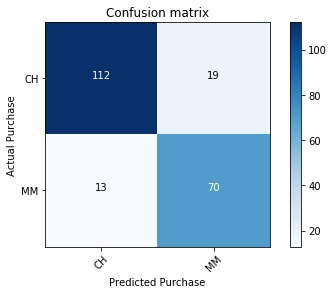

In [108]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [109]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.85 0.84]

Precision for both classes [0.9  0.79]

Recall Score: 0.8491676630184861

Precision Score: 0.8412584269662922

F1-Score: 0.8444767441860466

Accuracy = 0.85

Kappa = 0.69

Matthews correlation coefficient = 0.69


### 7. Support Vector Machines

In [110]:
from sklearn import svm
clf = svm.SVC(gamma='scale', random_state = 123)
clf.fit(X, y)

y_pred = clf.predict(X_test)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=123, shrinking=True, tol=0.001,
    verbose=False)

###### Model Parameters - 7. Support Vector Machines

confusion matrix:
 [[130   1]
 [ 73  10]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


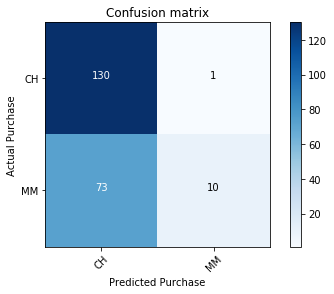

In [111]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [112]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.99 0.12]

Precision for both classes [0.64 0.91]

Recall Score: 0.5564241699622919

Precision Score: 0.7747424988804299

F1-Score: 0.4956045356096318

Accuracy = 0.65

Kappa = 0.13

Matthews correlation coefficient = 0.25


#### Model Tuning - 7. Support Vector Machines

In [113]:
parameters = {'C':[0.1, 1, 10, 100, 1000],
              'gamma':[0.1, 1, 10, 100],
              'kernel':('rbf', 'linear'), 
             'random_state':[123]}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=123, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.1, 1, 10, 100],
                         'kernel': ('rbf', 'linear'), 'random_state': [123]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(cohen_kappa_score), verbose=0)

array(['CH', 'CH', 'CH', 'CH', 'MM', 'CH', 'CH', 'CH', 'CH', 'CH', 'CH',
       'CH', 'CH', 'MM', 'CH', 'MM', 'CH', 'MM', 'CH', 'MM', 'CH', 'CH',
       'CH', 'MM', 'MM', 'MM', 'CH', 'CH', 'MM', 'MM', 'MM', 'MM', 'MM',
       'CH', 'MM', 'MM', 'CH', 'CH', 'CH', 'CH', 'CH', 'MM', 'MM', 'CH',
       'CH', 'CH', 'CH', 'MM', 'CH', 'CH', 'CH', 'CH', 'CH', 'MM', 'MM',
       'CH', 'MM', 'CH', 'CH', 'CH', 'MM', 'CH', 'MM', 'MM', 'MM', 'CH',
       'CH', 'CH', 'MM', 'CH', 'CH', 'MM', 'CH', 'MM', 'CH', 'MM', 'CH',
       'CH', 'MM', 'MM', 'MM', 'MM', 'MM', 'CH', 'CH', 'CH', 'MM', 'CH',
       'CH', 'MM', 'CH', 'CH', 'MM', 'CH', 'CH', 'CH', 'CH', 'MM', 'MM',
       'MM', 'MM', 'MM', 'CH', 'CH', 'MM', 'MM', 'MM', 'CH', 'MM', 'CH',
       'CH', 'MM', 'MM', 'CH', 'CH', 'CH', 'MM', 'MM', 'CH', 'CH', 'MM',
       'MM', 'CH', 'CH', 'MM', 'CH', 'CH', 'MM', 'MM', 'CH', 'CH', 'CH',
       'CH', 'CH', 'CH', 'CH', 'CH', 'CH', 'MM', 'CH', 'MM', 'CH', 'CH',
       'MM', 'CH', 'CH', 'CH', 'CH', 'CH', 'CH', 'C

#### Tuned Model Parameters - 7. Support Vector Machines

confusion matrix:
 [[112  19]
 [ 14  69]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


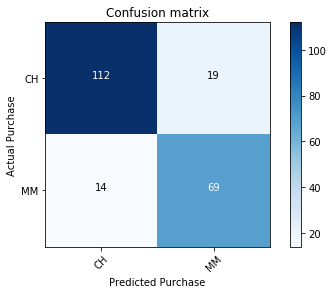

In [114]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [115]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))




Recall for both classes [0.85 0.83]

Precision for both classes [0.89 0.78]

Recall Score: 0.843143566632944

Precision Score: 0.836489898989899

F1-Score: 0.8393064372994743

Accuracy = 0.85

Kappa = 0.68

Matthews correlation coefficient = 0.68


### 8. Extreme Gradient Boosting

In [133]:
from xgboost import XGBClassifier

#we have to convert into arrays first due to a bug.
X_train = np.array(X_train)
X_test = np.array(X_test)

# fit model no training data
clf = XGBClassifier(learning_rate =0.1, n_estimators=1000, 
                        max_depth=5, min_child_weight=1, gamma=0, 
                        subsample=0.8, colsample_bytree=0.8, 
                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, random_state = 123)

# Fit the xg boost model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=123,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

###### Model Parameters - 8. Extreme Gradient Boosting

confusion matrix:
 [[115  16]
 [ 23  60]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


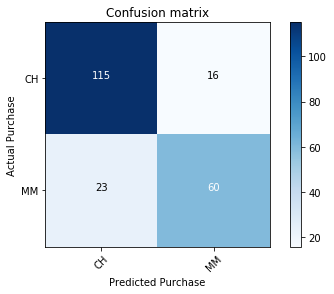

In [134]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [135]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))



Recall for both classes [0.88 0.72]

Precision for both classes [0.83 0.79]

Recall Score: 0.8003770808424537

Precision Score: 0.8114035087719298

F1-Score: 0.8048677842463352

Accuracy = 0.82

Kappa = 0.61

Matthews correlation coefficient = 0.61


#### Model Tuning - 8. Extreme Gradient Boosting

In [128]:
from sklearn.model_selection import GridSearchCV


parameters = {'learning_rate':[0.1, 0.05, 0.01], 
              'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 15, 20, 25], 
              'min_impurity_decrease':[0, 0.1, 0.2], 
              'colsample_bytree': [0.5, 0.8, 0.9], 
              'random_state':[123]}

kappa_scorer = make_scorer(cohen_kappa_score)
clf = GridSearchCV(clf, parameters, scoring=kappa_scorer, cv=5, return_train_score=True,iid=False)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.8, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     missing=None, n_estimators=1000, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=123, reg_alpha=0,
                                     reg...
                                     seed=None, silent=None, subsample=0.8,
                                     verbosity=1),
             iid=False, n_jobs=None,
             param_grid={'colsample_bytree': [0.5, 0.8, 0.9],
                         'learning_rate': [0.1, 0.05, 0.01],
                         'max_d

#### Tuned Model Parameters - 8. Extreme Gradient Boosting

confusion matrix:
 [[114  17]
 [ 18  65]]


<Figure size 432x288 with 0 Axes>

Confusion matrix, without normalization


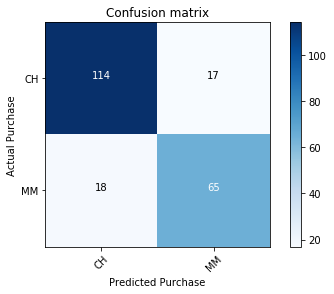

In [131]:
cm = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm)

np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm, classes=[0,1],
                      title='Confusion matrix')

In [132]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
print("\nRecall for both classes", recall)
print("\nPrecision for both classes", precision )

print("\nRecall Score:", np.mean(recall))
print("\nPrecision Score:", np.mean(precision))

print("\nF1-Score:", np.mean(2*precision*recall/(precision + recall)))
print("\nAccuracy = {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("\nKappa = {:.2f}".format(metrics.cohen_kappa_score(y_test, y_pred)))

print("\nMatthews correlation coefficient = {:.2f}".format(metrics.matthews_corrcoef(y_test, y_pred)))




Recall for both classes [0.87 0.78]

Precision for both classes [0.86 0.79]

Recall Score: 0.8266807688770348

Precision Score: 0.8281596452328159

F1-Score: 0.8273994699850213

Accuracy = 0.84

Kappa = 0.65

Matthews correlation coefficient = 0.65
